# <b><h1>Disco Data Processing Script</h1>
<h2>Part 1 Reading and Cleaning Data</h2></b>

Prior to running the script, please ensure you have inserted all the books you would like to be analyzed inside the input directory. The code will create custom output folders based on the name of the input books, so nothing overwrites. This code supports polymer data from the NMR analysis in "Book Format" (See PAA.xlsx for example) and "Batch Format" (See Batch 1, Batch 2 files for an example of what this looks like). 

For Batch Format inputs, please ensure unique observations intended to be analyzed together follow the same naming format. For example, if there are 4 total CMC results, 3 from one day to be analyzed together, and 1 from a separate occasion, the sheet tabs should be named according to one format: CMC (1), CMC (2), CMC (3) {These 3 will be analyzed together. The 4th CMC tab should be named something different, such as CMC_other, and will be treated separately.
    
<b>Your Input Folder Should Look Like:</b>    
- disco-data-processing.py
- disco-data-processing.ipynb
- input/"raw_book_with_a_short_title_you_like.xlsx" (i.e. "PAA.xlsx")

Then simply hit run on the .Py script, or use the Jupyter notebook if you wish to interact with the data directly/easily modify it. 

<h2>Part 2 Statistical Analysis</h2>

<p>Use the exploratory data visualizations from part 1 to see if you're on the right track, and to give context to the statistical analysis.</p>


In [337]:
# importing required libraries:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
from scipy.stats import t
import scipy.stats as stats
from scipy.optimize import curve_fit
import os 
import glob

# define handy shortcut for indexing a multi-index dataframe
idx = pd.IndexSlice

Make sure to run all of the function definition cells below first if you are in Jupyter Notebook.

In [338]:
def convert_excel_to_dataframe(b):
    '''
    This function converts raw Excel books containing outputs from DISCO-NMR experiments into cleaned and 
    organized Pandas DataFrames for further processing.
    
    Inputs are:
    b = The file path to the excel book of interest, obtained generalizably from the "list_of_raw_books" defined above
    
    Output is a tuple (clean_tuple) in a "key-value pair format,"" where the key (at index 0 of the tuple) is:
        current_book_title, a string containing the title of the current excel input book
   
    And the value (at index 1 of the tuple) is:
        clean_df, the cleaned pandas dataframe corresponding to that book title!

    '''
    # PREPARE AND INITIALIZE REQUIRED VARIABLES FOR DATA WRANGLING --------------
    
    # grab the current book title, and drop the file extension from current book title for easier file naming in the rest of the code
    current_book_title = os.path.basename(str(b))
    sep = '.'
    current_book_title = current_book_title.split(sep, 1)[0]
    
    print("The current book being analyzed is: ", current_book_title)

    # determine the number of sheets, samples, & controls in the workbook
    name_sheets = pd.ExcelFile(b).sheet_names
    num_sheets = (len(pd.ExcelFile(b).sheet_names))
    
    # initialize number of samples and controls to zero, then initialize the "list initializers" which will hold book-level data to eventually add to the book-level dataframe.
    num_samples = 0
    num_controls = 0
    sample_control_initializer = []
    sample_replicate_initializer = []
    control_replicate_initializer = []
    
    # initialize a list to contain the mini experimental dataframes collected from within the current book, which will be concatenated at the end to create one dataframe "organized_df" that represents this book
    df_list = []
    
    # BEGIN WRANGLING DATA FROM THE EXCEL FILE, AND TRANSLATING INTO ORGANIZED DATAFRAME ----------------

    # loop through sheet names to determine number of samples and controls in this book
    for s in range(len(name_sheets)):
        
        # if the current sheet is labeled Sample: 
        # increment sample counter, add a list item called 'sample' to be initialized into the 'sample_or_control' list, add a list item of the replicate number to be initialized into the 'replicate' list.
        if ('Sample' or 'sample') in name_sheets[s]:
            num_samples += 1
            sample_control_initializer.append('sample')
            sample_replicate_initializer.append(num_samples)
            
        # if the current sheet is labeled Control: 
        # increment control counter, add a list item called 'control' to be initialized into the 'sample_or_control' list, add a list item of the replicate number to be initialized into the 'replicate' list.   
        elif ('Control' or 'control') in name_sheets[s]:
            num_controls += 1
            sample_control_initializer.append('control')
            control_replicate_initializer.append(num_controls)
    
    print("There are", num_sheets, "sheets identified in the current book.")
    print("Number of samples sheets identified:", num_samples)
    print("Number of control sheets identified:", num_controls)
    
    if num_samples != num_controls:
        print('\nERROR: The number of sample sheets is not equal to the number of control sheets in', b, 'please confirm the data in the book is correct.')
    
    # combine sample and control initializers to create the total replicate index list
    total_replicate_index = sample_replicate_initializer + control_replicate_initializer
    print("Sample and control data initialization complete at the book-level. Beginning experiment-specific data acquisition.\n")
    
    #FOR TESTING, can set num_sheets = 1
#     num_sheets = 1
    
    # loop through each sheet in the workbook
    for n in range(num_sheets):

        # read in the current book's nth sheet into a Pandas dataframe
        current_sheet_raw = pd.read_excel(b, sheet_name=n)
        print("Reading Book Sheet:", n)
        
        # if the name of the sheet is not a sample or control, skip this sheet and continue to the next one 
        if (any(['ample' not in name_sheets[n]]) & any(['ontrol' not in name_sheets[n]])):
            print("Skipping sheet", n, "as not a sample or control.")
            continue

        # drop first always empty unnamed col (NOTE - consider building error handling into this to check the col is empty first)
        to_drop = ['Unnamed: 0']
        current_sheet_raw.drop(columns = to_drop, inplace = True)

        # loop through columns and "fill right" to replace all Unnamed columns with their corresponding title_string value
        for c in current_sheet_raw.columns:
            current_sheet_raw.columns = [current_sheet_raw.columns[i-1] if 'Unnamed' in current_sheet_raw.columns[i] else current_sheet_raw.columns[i] for i in range(len(current_sheet_raw.columns))]

        # identifies the coordinates of the left-most parameter in each experimental set, conc (um)
        i, c = np.where(current_sheet_raw == 'conc (um)')

        # assigns coordinates of all upper left 'conc (um) cells to an index (row) array and a column array
        conc_indices = current_sheet_raw.index.values[i]
        conc_columns = current_sheet_raw.columns.values[c]

        # determine the number of experimental rows in each NMR results sub-table
        # subtract one to exclude conc cell row itself
        num_experimental_indices = np.unique(conc_indices)[2] - np.unique(conc_indices)[1] - 1

        # determine the number of experimental columns in each NMR results sub-table
        (unique_exp_cols, count_experimental_cols) = np.unique(conc_columns, return_counts = True)
        num_experimental_cols = np.unique(count_experimental_cols)[0]

        # initialize/reset dfs, current is for CURRENT sub-tables being looped over, organized_df is to concatenate all the sub-dfs in this book
        current_exp_df = []
        organized_df = []
        
        # make a list of coordinate pair tuples for this sheet using list comprehension
        sheet_coords_list = [(conc_indices[i], conc_columns[i]) for i in range(len(conc_indices))]

        for coords in sheet_coords_list:
        
            # Determine the current 'sample_or_control' and 'replicate' values by taking the nth value (aka current sheet value) from the lists determined above
            current_sample_or_control = sample_control_initializer[n]
            current_replicate = total_replicate_index[n]

            # assign current values to the fixed experimental parameters for this experimental sub-table
            fixed_parameters_per_set = current_sheet_raw.loc[coords[0], coords[1]]
    
            # Hard coding the indices of the different parameters based on constant pattern in input file 
            current_title_string = fixed_parameters_per_set.index[0]
            current_concentration = fixed_parameters_per_set[1]
            current_sat_time = fixed_parameters_per_set[3]
            current_irrad_bool = fixed_parameters_per_set[5]

            # initialize/reset experimental lists to null for this experimental set
            list_current_ppm_experimental = []
            list_current_intensity_experimental = []
            list_current_width_experimental = []
            list_current_area_experimental = []
            list_current_type_experimental = []
            list_current_flags_experimental = []
            list_current_impuritycomp_experimental = []
            list_current_annotation_experimental = []
            list_current_range_experimental = []
            list_current_normalized_experimental = []
            list_current_absolute_experimental = []

            # now need to find and assign the sub-table's actual experimental data to the new lists 
                
            # Initializing the "boundaries" of the sub-table rectangle containing values of interest in a generalizable way, based on conc as the upper left value
            experimental_index_starter = coords[0]+1
            experimental_index_range = range(num_experimental_indices)
            experimental_column_range = range(num_experimental_cols)
            combined_experimental_index_range = experimental_index_starter + experimental_index_range

            # Obtain experimental column range using boolean mask as column labels are title_strings for each experimental set
            experimental_column_range_mask = current_sheet_raw.columns.get_loc(coords[1])
            combined_experimental_column_range = np.where(experimental_column_range_mask)
            
            # loop through and collect experimental index and experimental column range for the ith and jth experimental sub-table
            for ei in combined_experimental_index_range:
                for ec in combined_experimental_column_range:
                    
                    # use iloc to grab NMR experimental variables for this set into a series
                    variable_parameters_per_set = current_sheet_raw.iloc[ei, ec]

                    # append designated variable parameters into lists for those parameters in the current experimental sub-set
                    # this is hard coded based on known order of columns in the input file structure that should theoretically be consistent...
                    list_current_ppm_experimental.append(variable_parameters_per_set.iloc[1])
                    list_current_intensity_experimental.append(variable_parameters_per_set.iloc[2])
                    list_current_width_experimental.append(variable_parameters_per_set.iloc[3])
                    list_current_area_experimental.append(variable_parameters_per_set.iloc[4])
                    list_current_type_experimental.append(variable_parameters_per_set.iloc[5])
                    list_current_flags_experimental.append(variable_parameters_per_set.iloc[6])
                    list_current_impuritycomp_experimental.append(variable_parameters_per_set.iloc[7])
                    list_current_annotation_experimental.append(variable_parameters_per_set.iloc[8])
                    list_current_range_experimental.append(variable_parameters_per_set.iloc[11])
                    list_current_normalized_experimental.append(variable_parameters_per_set.iloc[12])
                    list_current_absolute_experimental.append(variable_parameters_per_set.iloc[13])
                    

            # after all the experimental lists are populated, define length of the experimental parameter lists (number of true experimental rows)
            exp_list_length = len(list_current_ppm_experimental)

            # create "ranged" lists of the constant experimental values to make them the same length as the unique variable experimental values, so we can add information "per observation" to the dataframe
            ranged_sample_or_control = exp_list_length * [current_sample_or_control]
            ranged_replicate = exp_list_length * [current_replicate]
            ranged_title_string = exp_list_length * [current_title_string]
            ranged_concentration = exp_list_length * [current_concentration] 
            ranged_sat_time = exp_list_length * [current_sat_time]
            ranged_irrad_bool = exp_list_length * [current_irrad_bool]
                
            # assign all current experimental values for this experimental set to a dataframe via a dictionary
            current_dict = {"sample_or_control":ranged_sample_or_control,
                                "replicate":ranged_replicate,
                                "title_string":ranged_title_string, 
                                "concentration":ranged_concentration,
                                "sat_time":ranged_sat_time, 
                                "irrad_bool":ranged_irrad_bool, 
                                "ppm":list_current_ppm_experimental, 
                                "intensity":list_current_intensity_experimental, 
                                "width":list_current_width_experimental, 
                                "area":list_current_area_experimental, 
                                "type":list_current_type_experimental, 
                                "flags":list_current_flags_experimental, 
                                "impurity_compound":list_current_impuritycomp_experimental, 
                                "annotation":list_current_annotation_experimental, 
                                "range":list_current_range_experimental, 
                                "normalized":list_current_normalized_experimental, 
                                "absolute":list_current_absolute_experimental}
            
            current_exp_df = pd.DataFrame(current_dict)
    
            # before moving on to next experimental set, append the dataframe from this experimental set to a book-level list of dataframes
            df_list.append(current_exp_df)

        print("Data frame for the experimental set at coordinates:", coords, "has been appended to the book-level list of dataframes.\n")
    
    # concatenate the mini dataframes appended to the df_list into one big organized dataframe for this book!
    organized_df = pd.concat(df_list)
    print("The input book {} has been wrangled into an organized dataframe! Now initializing dataframe cleaning steps.\n".format(current_book_title))
    
    # BEGIN CLEANING THE ORGANIZED DATAFRAME ----------------------------------------------------
    
    # Need to remove redundant rows (generated by the data processing loops above)

    # assign prosepctive redundant title rows at index zero to a variable
    organized_df_redundant = organized_df[organized_df.index == 0]

    # to make sure the standard expected redundant rows are actually redundant (expected redundant row is a duplicate of the column labels)
    # check that there is only one unique 'absolute' value (duplicate rows will only have one unique value, as they are titles)
    if organized_df_redundant.nunique().loc['absolute'] == 1:
        clean_df = organized_df[organized_df.index != 0]
    else: 
        print("Warning, assumed redundant rows for further processing are not actually redundant. Proceeding.\n")
        clean_df = organized_df
    
    # remove any duplicate rows
    clean_df = clean_df.drop_duplicates()

    # export the cleaned dataframe of the book to excel in a custom output folder
    output_directory = "output_from_{}".format(current_book_title)
    output_file_name = "{}_clean_raw_dataframe.xlsx".format(current_book_title)

    # make directory if there isn't already one for output 
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    print('Dataframe cleaning complete!\n')
    print('Now exporting the cleaned dataframe in Excel format to a custom output directory for reference.\n')
    clean_df.to_excel(os.path.join(output_directory, output_file_name))

    print('Excel export complete! Navigate to output directory to see the clean Excel file.\n')
    
    # merge current_book_title and clean_df into a tuple, as "key value pairs" that can be generically indexed
    clean_tuple = (current_book_title, clean_df)
    print('Function has returned a tuple containing the title of the current book, and the cleaned dataframe for {}.\n'.format(current_book_title))
    
    return clean_tuple


In [339]:
def attenuation_calc_equality_checker(compare_df_1, compare_df_2, batch_or_book = 'book'):
    
    '''This functions checks to see if two subset dataframes for the attenuation calculation, one where irrad bool is true, one where irrad bool is false, for calculating attenuation
    are equal and in the same order in terms of their fixed experimental parameters. 'sample_or_control', 'replicate', 'title_string', 'concentration', 
    'sat_time' '''
    
    if (compare_df_1.shape == compare_df_2.shape):
        
        if batch_or_book == 'book':
            subset_compare_1 = compare_df_1[['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time']]
            subset_compare_2 = compare_df_2[['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time']]
        
            exactly_equal = subset_compare_2.equals(subset_compare_1)
    
            return exactly_equal
    
        else:
            
            #check sample_or_control is the same
            subset_compare_1 = compare_df_1.sample_or_control.values
            subset_compare_2 = compare_df_2.sample_or_control.values
            exactly_equal_1 = np.array_equal(subset_compare_1, subset_compare_2)
            
            
            #check replicate is the same
            subset_compare_1 = compare_df_1.replicate.values
            subset_compare_2 = compare_df_2.replicate.values
            exactly_equal_2 = np.array_equal(subset_compare_1, subset_compare_2)
            #             exactly_equal_2 = subset_compare_2.equals(subset_compare_1)
            
            #check proton peak index is the same
            subset_compare_1 = compare_df_1.proton_peak_index.values
            subset_compare_2 = compare_df_2.proton_peak_index.values
            exactly_equal_3 = np.array_equal(subset_compare_1, subset_compare_2)
            
            #check sat time is the same
            subset_compare_1 = compare_df_1.sat_time.values
            subset_compare_2 = compare_df_2.sat_time.values
            exactly_equal_4 = np.array_equal(subset_compare_1, subset_compare_2)
            
            #if passes all 4 checks return true, if not false
            if exactly_equal_1 == exactly_equal_2 == exactly_equal_3 == exactly_equal_4 == True:
                return True
            
            else: return False
        
    else:
        raise ValueError("Error, irrad_false and irrad_true dataframes are not the same shape to begin with.")

def corrected_attenuation_calc_equality_checker(compare_df_1, compare_df_2, compare_df_3):  
    
    '''This functions checks to see if the three subset dataframes for calculating the corrected % attenuation
    are equal and in the same order in terms of their shared fixed experimental parameters. 'replicate', 'concentration', 
    'sat_time' '''
    
    #check if number of rows same in each df, number of columns not same as samples dfs contain attenuation data
    if (compare_df_1.shape[0] == compare_df_2.shape[0] == compare_df_3.shape[0]):
        
        #check replicate is the same
        subset_compare_1 = compare_df_1.replicate.values
        subset_compare_2 = compare_df_2.replicate.values
        subset_compare_3 = compare_df_3.replicate.values
        
        exactly_equal_1 = np.logical_and((subset_compare_1==subset_compare_2).all(), (subset_compare_2==subset_compare_3).all())
        
        #check sat time is the same
        subset_compare_1 = compare_df_1.sat_time.values
        subset_compare_2 = compare_df_2.sat_time.values
        subset_compare_3 = compare_df_3.sat_time.values
        
        exactly_equal_2 = np.logical_and((subset_compare_1==subset_compare_2).all(), (subset_compare_2==subset_compare_3).all())
        
        #check concentration is the same
        subset_compare_1 = compare_df_1.concentration.values
        subset_compare_2 = compare_df_2.concentration.values
        subset_compare_3 = compare_df_3.concentration.values
        
        exactly_equal_3 = np.logical_and((subset_compare_1==subset_compare_2).all(), (subset_compare_2==subset_compare_3).all())
        

        #if passes all 3 checks return true, if not false
        if exactly_equal_1 == exactly_equal_2 == exactly_equal_3 == True:
            return True
            
        else: return False
        
        
    else:
        raise ValueError("Error, corrected % attenuation input dataframes are not the same shape to begin with.")

In [340]:
def add_attenuation_and_corr_attenuation_to_dataframe(current_book, batch_or_book = 'book'):
    '''
    This function calculates the attenuation, and corr_%_attenuation if the dataframe passes all checks
    (based on the order of items) by means of simple arithmetic operations.
    
    Input: current_book, the dataframe output from the convert_excel_to_dataframe() function. (Or batch processing equivalent)
    
    Outut: corr_p_attenuation_df, an updated dataframe that includes the attenuation and corr_%_attenuation columns.
    
    Default is book, but it will run the batch path if 'batch' is passed to function as the second arg.
    
    '''
    
    # to get get % attenuation of peak integral, define true and false irrad dataframes below, can perform simple subtraction if passes check
    
    if batch_or_book == 'book':
        intensity_irrad_true = current_book.loc[(current_book['irrad_bool'] == 1.0), ['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time', 'ppm', 'intensity', 'range', 'normalized', 'absolute']]
        intensity_irrad_false = current_book.loc[(current_book['irrad_bool'] == 0.0), ['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time', 'ppm', 'intensity', 'range', 'normalized', 'absolute']]
    
    else:
        intensity_irrad_true = current_book.loc[(current_book['irrad_bool'] == True), ['polymer_name', 'proton_peak_index', 'ppm_range', 'ppm', 'sample_or_control', 'replicate', 'concentration', 'sat_time', 'absolute']]
        intensity_irrad_false = current_book.loc[(current_book['irrad_bool'] == False), ['polymer_name', 'proton_peak_index',  'ppm_range', 'ppm', 'sample_or_control', 'replicate', 'concentration', 'sat_time', 'absolute']]
        
        
    # check if the fixed experimental values in irrad true and irrad false are equal, in the same order, and the same size, so that one to one calculations can be performed to calculate attenuation.
    fixed_values_equality_check = attenuation_calc_equality_checker(intensity_irrad_true, intensity_irrad_false, batch_or_book)

    # if the test passes, calculate attenuation and append to dataframe
    if fixed_values_equality_check == True:

        p_attenuation_intensity = intensity_irrad_false.absolute.values - intensity_irrad_true.absolute.values
    
        #Update irradiated dataframe to include the % attenuation of the irradiated samples and controls
        intensity_irrad_true['attenuation'] = p_attenuation_intensity
        print("Test 1 passed, attenuation has been calculated and appended to dataframe.")
        
    else:
        raise ValueError("Error, intensity_irrad true and false dataframes are not equal, cannot compute signal attenutation in a one-to-one manner.")
#         print("Error, intensity_irrad true and false dataframes are not equal, cannot compute signal attenutation in a one-to-one manner.")

    # Now check we are good to calculate the corrected % attenuation, and then calculate: ------------------------

    #subset the dataframe where irrad is true for samples only
    p_atten_intensity_sample = intensity_irrad_true.loc[(intensity_irrad_true['sample_or_control'] == 'sample')]
    #subset the dataframe where irrad is true for controls only
    p_atten_intensity_control = intensity_irrad_true.loc[(intensity_irrad_true['sample_or_control'] == 'control')]
    #subset dataframe where irrad is false for samples only
    intensity_irrad_false_sample = intensity_irrad_false.loc[(intensity_irrad_false['sample_or_control'] == 'sample')]

    #check if the fixed experimental values in irrad true and irrad false are equal, in the same order, and the same size, so that one to one calculations can be performed to calculate attenuation.
    corr_atten_equality_check = corrected_attenuation_calc_equality_checker(p_atten_intensity_sample, p_atten_intensity_control, intensity_irrad_false_sample)    

    if corr_atten_equality_check == True:

        #Grab Attenuation data for subset with samples only where irrad is true  
        p_atten_intensity_sample_data = intensity_irrad_true.loc[(intensity_irrad_true['sample_or_control'] == 'sample')]['attenuation'].values
        #Grab Attenuation data for subset with controls only where irrad is true
        p_atten_intensity_control_data = intensity_irrad_true.loc[(intensity_irrad_true['sample_or_control'] == 'control')]['attenuation'].values
        #Grab Absolute peak integral data for subset with samples only where irrad is false to normalize attenuation
        intensity_irrad_false_sample_data = intensity_irrad_false.loc[(intensity_irrad_false['sample_or_control'] == 'sample')]['absolute'].values
        
        #initialize different cols depending on whether batch or book
        if batch_or_book == 'book':
            #initialize dataframe to store corrected p_attenuation with the shared fixed parameters and sample identifier parameters
            corr_p_attenuation_df = pd.DataFrame(p_atten_intensity_sample[['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time', 'ppm', 'intensity', 'range', 'normalized', 'absolute', 'attenuation']])
        else:
            #initialize dataframe to store corrected p_attenuation with the shared fixed parameters and sample identifier parameters
            corr_p_attenuation_df = pd.DataFrame(p_atten_intensity_sample[['polymer_name', 'concentration', 'sat_time', 'proton_peak_index', 'ppm_range', 'ppm', 'sample_or_control', 'replicate', 'absolute', 'attenuation']])
            
        #Calculate Corrected % Attentuation, as applies to
        corr_p_attenuation_df['corr_%_attenuation'] = ((1/intensity_irrad_false_sample_data)*(p_atten_intensity_sample_data - p_atten_intensity_control_data))
        print("Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.")
        
        return corr_p_attenuation_df

    else:
        raise ValueError("Error, input dataframes are not equal, cannot compute corrected signal attenutation in a one-to-one manner.")
#         return print("Error, input dataframes are not equal, cannot compute corrected signal attenutation in a one-to-one manner.")
        

In [341]:
def generate_concentration_plot(current_df_attenuation):
    
    '''
    This function generates a basic exploratory stripplot of polymer sample attenuation vs saturation time using
    concentration is a "hue" to differentiate points. 
    
    This function also saves the plot to a custom output folder.
    
    Input: dataframe after attenuation and corrected % attenuation have been calculated.
    Output: saves plot to file, and displays it.
    
    '''
    a4_dims = (11.7, 8.27)
    fig1, ax = pyplot.subplots(figsize = a4_dims)
    sns.stripplot(ax = ax, x = 'sat_time', y = 'corr_%_attenuation', data = current_df_attenuation, hue = 'concentration', palette = 'viridis')

    plt.title("Polymer Sample Attenuation vs Saturation Time")
    plt.ylabel("Corrected Signal Intensity Attenuation (%)")
    plt.xlabel("NMR Pulse Saturation Time (s)")
    
        
    # define file name for the concentration plot
    output_file_name_conc = "{}/exploratory_concentration_plot_from_{}.png".format(output_directory_exploratory, current_df_title)
    
    # export to file
    fig1.savefig(output_file_name_conc, dpi=300)

    return

In [342]:
def generate_ppm_plot(current_df_attenuation):
    
    '''
    This function generates a basic exploratory scatterplot of polymer sample attenuation vs saturation time using
    ppm as a "hue" to differentiate points. 
    
    This function also saves the plot to a custom output folder.
    
    Input: dataframe after attenuation and corrected % attenuation have been calculated.
    Output: saves plot to file, and displays it.
    '''
    
    a4_dims = (11.7, 8.27)
    fig2, ax2 = pyplot.subplots(figsize = a4_dims)
    sns.scatterplot(ax = ax2, x = 'sat_time', y = 'corr_%_attenuation', data = current_df_attenuation, hue ='ppm', palette = 'viridis', y_jitter = True, legend = 'brief')

    # a stripplot looks nicer than this, but its legend is unneccessarily long with each individual ppm, need to use rounded ppm to use the below line
    # sns.stripplot(ax = ax2, x = 'sat_time', y = 'corr_%_attenuation', data = corr_p_attenuation_df, hue ='ppm', palette = 'viridis', dodge = True)

    plt.title("Polymer Sample Attenuation vs Saturation Time")
    plt.ylabel("Corrected Signal Intensity Attenuation  (%) by ppm")
    plt.xlabel("NMR Pulse Saturation Time (s)")
    ax2.legend() 

    # define file name for the concentration plot
    output_file_name_ppm = "{}/exploratory_ppm_plot_from_{}.png".format(output_directory_exploratory, current_df_title)

    # export to file
    fig2.savefig(output_file_name_ppm, dpi=300)
        
    return

In [343]:
def prep_mean_data_for_stats(corr_p_attenuation_df, batch_or_book = 'book'):
    
    '''
    This function prepares the dataframe for statistical analysis after the attenuation and corr_%_attenuation
    columns have been added.
    
    Statisical analysis is performed on a "mean" basis, across many experimental replicates.
    This code prepares the per-observation data accordingly, and outputs the mean_df_for_stats.
    
    It drops the columns and rows not required for stats, calculates the mean and std of parameters we do 
    care about, and also appends the degrees of freedom and sample size.
    
    Input: current_df_attenuation
    Output: mean_current_df_for_stats 
    
    Default is book, but it will run the batch path if 'batch' is passed to function as the second arg.
    
    '''
    # follow this path if data is from a single polymer book
    if batch_or_book == 'book':
        
        # drop any rows that are entirely null from the dataframe 
        corr_p_attenuation_df = corr_p_attenuation_df.dropna(how = "any")

        # now drop the column fields that are not required for stats modelling and further analysis
        data_for_stats = corr_p_attenuation_df.drop(columns = ['title_string', 'sample_or_control', 'intensity', 'range', 'normalized', 'absolute', 'attenuation'])

        # Add a new column to data for the index of proton peaks in an experimental set of a polymer (i.e. proton peak index applies to index protons within one polymer book)
        proton_index = data_for_stats.index
        data_for_stats['proton_peak_index'] = proton_index
    
    
        # determine mean corr % attenuation and mean ppm per peak index, time, and concentration across replicates using groupby sum (reformat) and groupby mean (calculate mean)
        regrouped_df = data_for_stats.groupby(by = ['concentration', 'sat_time', 'proton_peak_index', 'replicate'])[['ppm','corr_%_attenuation']].sum()

        # generate a table that includes the mean and std for ppm and corr_%_atten across the replicates, reset index
        mean_corr_attenuation_ppm = regrouped_df.groupby(by = ['concentration', 'sat_time', 'proton_peak_index']).agg({'ppm': ['mean', 'std'], 'corr_%_attenuation': ['mean', 'std']})
        
        # prepare input for dofs function
        input_for_dofs = regrouped_df.index.get_level_values(2)
    
    # if data came from a batch, ppm value is static and 1 less DoF, so perform adjusted operations
    else: 

        # now drop the column fields that are not required for stats modelling and further analysis
        data_for_stats = corr_p_attenuation_df.drop(columns = ['sample_or_control', 'absolute', 'ppm_range'])

        # determine mean corr % attenuation per peak index, time, and concentration across replicates using groupby sum (reformat) and groupby mean (calculate mean)
        regrouped_df = data_for_stats.groupby(by = ['concentration','sat_time', 'proton_peak_index', 'replicate', 'ppm'])[['corr_%_attenuation']].sum()

        # generate a table that includes the mean and std for ppm and corr_%_atten across the replicates, reset index
        mean_corr_attenuation_ppm = regrouped_df.groupby(by = ['concentration', 'sat_time', 'proton_peak_index', 'ppm']).agg({'corr_%_attenuation': ['mean', 'std']})
        
        # prepare input for dofs function
        input_for_dofs = regrouped_df.index.get_level_values(2)
        
    
    def get_dofs(peak_indices_array):
    
        ''' This function calculates the number of degrees of freedom (i.e. number of experimental replicates minus one) for statistical calculations 
        using the "indices array" of a given experimenal set as input.
    
        Input should be in the format: (in format: 11111 22222 3333 ... (specifically, it should be the proton_peak_index column from the "regrouped_df" above)
        where the count of each repeated digit minus one represents the degrees of freedom for that peak (i.e. the number of replicates -1).
        With zero based indexing, the function below generates the DOFs for the input array of proton_peak_index directly, in a format
        that can be directly appended to the stats table.
        '''

        dof_list = []
        dof_count = 0
        global_count = 0

        # loop through range of the peak indices array 
        for i in range(len(peak_indices_array)):
            global_count = global_count +1

            # if at the end of the global range, append final incremented dof count
            if global_count == len(peak_indices_array):
                dof_count = dof_count+1
                dof_list.append(dof_count)
                break

            # if current index is not equal to the value of the array at the next index, apply count of current index to DOF list, and reset DOF counter
            elif peak_indices_array[i] != peak_indices_array[i+1]:
                dof_list.append(dof_count)
                dof_count = 0

            # otherwise, increment DOF count and continue
            else:
                dof_count = dof_count + 1

        return dof_list
    
    # Calculate degrees of freedom and sample size for each datapoint using function above
    peak_index_array = np.array(input_for_dofs)
    dofs = get_dofs(peak_index_array)

    # append a new column with the calculated degrees of freedom to the table for each proton peak index
    mean_corr_attenuation_ppm['dofs'] = dofs
    mean_corr_attenuation_ppm['sample_size'] = np.asarray(dofs) + 1
        
        
    return mean_corr_attenuation_ppm 

In [344]:
def prep_replicate_data_for_stats(corr_p_attenuation_df, batch_or_book = 'book'):
    
    '''
    This function prepares the dataframe for statistical analysis after the attenuation and corr_%_attenuation
    columns have been added.
    
    This code prepares the per-observation data accordingly, and outputs the replicate_df_for_stats.
    
    It drops the columns and rows not required for stats, and adds the proton peak index.
    
    Input: current_df_attenuation
    Output: replicate_current_df_for_stats 
    
    Defaults to book processing path, but if 'batch' is passed to function will pursue batch path.
    
    '''
    
    # drop any rows that are entirely null from the dataframe 
    corr_p_attenuation_df = corr_p_attenuation_df.dropna(how = "any")
    
    if batch_or_book == 'book':
        # now drop the column fields that are not required for stats modelling and further analysis
        replicate_df_for_stats = corr_p_attenuation_df.drop(columns = ['title_string', 'sample_or_control', 'intensity', 'range', 'normalized', 'absolute', 'attenuation'])
        
        # Add a new column to data for the index of proton peaks in an experimental set of a polymer (i.e. proton peak index applies to index protons within one polymer book)
        proton_index = replicate_df_for_stats.index
        replicate_df_for_stats['proton_peak_index'] = proton_index
    
    else:
        replicate_df_for_stats = corr_p_attenuation_df.drop(columns = ['sample_or_control', 'absolute', 'attenuation'])
    
    return replicate_df_for_stats

In [345]:
def get_t_test_results(mean_corr_attenuation_ppm, p=0.95):

    ''' 
        Procedure followed from: https://machinelearningmastery.com/critical-values-for-statistical-hypothesis-testing/ 

        One sample t test: tests whether the mean of a population is significantly different than a sample mean.
        A proper t-test analysis performs calculations to help infer what the expected population mean (that 
        contains the sample) given just a sample mean. (Inferential statistics).

        Null Hypothesis: population mean = sample mean (avg corr % attenuation for a proton peak of N replicates at fixed experimental parameters)
        Alternative Hypothesis: population mean >= sample mean (avg corr % attenuation for a proton peak of N replicates at fixed experimental parameters)

        Population parameters used are that of the student's t distribution.
        Alpha = 0.1 for statistical significance. 

        Still theoretically need to validate sample data meets assumptions for one sample t test: normal dist, homegeneity of variance, & no outliers. **
        
        Input: current_df_mean after having been prepared for stats (output from prep_mean_data_for_stats)
        Output: The same df as input, only now with the t test values and results appended
        
        Book and batch paths are the same.
        
        Target p value defaults to 0.95 unless other argument passed.
        
    '''

    # Initialize Relevant t test Parameters
    dof = mean_corr_attenuation_ppm['dofs']
    mean_t = mean_corr_attenuation_ppm['corr_%_attenuation']['mean'].abs()
    std_t = mean_corr_attenuation_ppm['corr_%_attenuation']['std']
    sample_size_t = mean_corr_attenuation_ppm['sample_size']

    # retrieve value <= probability from t distribution, based on DOF for sample 
    crit_t_value = t.ppf(p, dof)
    # print(crit_t_value)

    # confirm the p value with cdf, for sanity checking 
    # p = t.cdf(crit_t_value, dof)
    # print(p)

    #perform one sample t-test for significance, significant if t_test_results < 0 
    t_test_results =  mean_t - crit_t_value * (std_t/(np.sqrt(sample_size_t)))
    mean_corr_attenuation_ppm['t_results'] = t_test_results
    mean_corr_attenuation_ppm['significance'] = mean_corr_attenuation_ppm['t_results'] > 0

    #Return the dataframe with the new t test columns appended
    return mean_corr_attenuation_ppm

In [346]:
def compute_amplification_factor(current_mean_stats_df, current_replicate_stats_df, af_denominator):
    '''
    This function computes an amplification factor for the mean stats df and the replicate stats df.
    Each polymer may have a different denominator to consider for the amp factor calculation, so it
    is passed into this function as a variable.
    
    Input: mean_stats_df, replicates stats df, the denominator for amp factor calculation
    Output: mean_stats_df, replicates_stats_df with the amp factor column 
    
    For each concentration, compute the amplification factor AFconc = Cj/10. 
    
    Defaults to book path but will take batch path if 'batch' is passed.
    
    Might need to do some further work with custom af_denominators
    
    '''
    
    amp_factor_denominator = af_denominator
    amp_factor = np.array(current_mean_stats_df.index.get_level_values(0))/amp_factor_denominator
    current_mean_stats_df['amp_factor'] = amp_factor

    # Calculate the amplification factor for the data_for_stats ungrouped table as well (i.e. per replicate data table)
    current_replicate_stats_df['amp_factor'] = np.array(current_replicate_stats_df[['concentration']])/amp_factor_denominator

    # return the mean data table with the amp_factor added
    return current_mean_stats_df, current_replicate_stats_df

In [347]:
def drop_bad_peaks(current_df_mean, current_df_replicates, batch_or_book = 'book'):

    '''
    This function identifies whether proton peaks pass or fail an acceptance criterion to allow
    them to be further analyzed. If the peaks fail, they are dropped from further analysis.
    
    Criterion for dropping peaks from Further consideration: If more than two proton peak datapoints are flagged as not significant in the mean dataframe 
    WITHIN a given concentration, the associated proton peak is removed from further analysis.
    
    Input: current_df_mean and current_df_replicats
    Outputs: the same dataframes, after dropping proton peaks that fail criterion, writes a text file of which points have been dropped

    '''

    #initialize a df that will keep data from the current mean df that meet the criterion above
    significant_corr_attenuation = current_df_mean

    #The below code checks data for the criterion and then removes rows if they do not pass for the mean df --------

    # Assign unique protons to a list to use for subsetting the df via multi-index and the multi-index slicing method
    unique_protons = current_df_replicates.proton_peak_index.unique()
    unique_concentrations = current_df_replicates.concentration.unique().tolist()

    #initialize list to contain the points to remove 
    pts_to_remove = []

    if batch_or_book == 'book':
        for p in unique_protons:
            for c in unique_concentrations:

                #subset the df via index slice based on the current peak and concentration
                current_subset_df = significant_corr_attenuation.loc[idx[c, :, p]]

                #subset further for where significance is false
                subset_insignificant = current_subset_df.loc[(current_subset_df['significance'] == False)]

                #if there's more than 2 datapoints where significance is False within the subset, drop p's proton peaks for c's concentration from the significant_corr_attenuation df
                if len(subset_insignificant) > 2:

                    pts_to_remove.append(current_subset_df.index)
                    significant_corr_attenuation = significant_corr_attenuation.drop(current_subset_df.index, inplace = False)  

    #     print('Removed insignificant points are:', pts_to_remove)
        print('Removed insignificant points have been printed to the output folder for {}.'.format(current_df_title))

        #create and print dropped points to a summary file
        dropped_points_file = open("{}/dropped_insignificant_points.txt".format(output_directory), "w")
        dropped_points_file.write("The datapoints dropped from consideration due to not meeting the criteria for significance are: \n{}".format(pts_to_remove))
        dropped_points_file.close()

        #define a mean df of the data that passed to return
        current_df_mean_passed = significant_corr_attenuation

        #The below code removes the same bad points from the replicate df ------------

        # Reset index and drop the old index column, just getting the dataframe ready for this, not sure why this works
        current_df_replicates = current_df_replicates.reset_index()
        current_df_replicates = current_df_replicates.drop('index', axis = 1)

        #drop the points
        for num_pts in pts_to_remove:
            for exp_parameters in num_pts:
                drop_subset = (current_df_replicates.loc[(current_df_replicates['concentration'] == exp_parameters[0]) & (current_df_replicates['sat_time'] == exp_parameters[1]) & (current_df_replicates['proton_peak_index'] == exp_parameters[2])])
                current_df_replicates = current_df_replicates.drop(drop_subset.index)

        #define a replicate df of the data that passed to return (reset index might not actually be needed? but I know this way works...) 
        current_df_replicates_passed = current_df_replicates.reset_index()

        return current_df_mean_passed, current_df_replicates_passed


    else:
        
        for p in unique_protons:
            for c in unique_concentrations:
                    
                #subset the df via index slice based on the current peak and concentration, ppm is part of index here
                current_subset_df = significant_corr_attenuation.loc[idx[c, :, p, :]]
                
                #subset further for where significance is false
                subset_insignificant = current_subset_df.loc[(current_subset_df['significance'] == False)]

                #if there's more than 2 datapoints where significance is False within the subset, drop p's proton peaks for c's concentration from the significant_corr_attenuation df
                if len(subset_insignificant) > 2:
                    
                    # recreate the corresponding parent multi index based on the identified points to drop to feed to parent dataframe
                    index_to_drop_sat_time = np.array(current_subset_df.index.get_level_values(0))
                    index_to_drop_ppm = np.array(current_subset_df.index.get_level_values(1))
                    index_to_drop_conc = np.full(len(index_to_drop_sat_time), c)
                    index_to_drop_proton_peak = np.full(len(index_to_drop_sat_time), p)

                    array_indexes_to_drop = [index_to_drop_conc, index_to_drop_sat_time, index_to_drop_proton_peak, index_to_drop_ppm]
                    multi_index_to_drop_input = list(zip(*array_indexes_to_drop))
                    multi_index_to_drop = pd.MultiIndex.from_tuples(multi_index_to_drop_input, names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
                    
                    #append multi index to pts to remove
                    pts_to_remove.append(multi_index_to_drop)
                    print("points being dropped are:", multi_index_to_drop)
                    
                    # pass the multi index to drop to drop points from the parent dataframe
                    significant_corr_attenuation = significant_corr_attenuation.drop(multi_index_to_drop, inplace = False)                     
#                     display(significant_corr_attenuation)
        print('Removed insignificant points have been printed to the output folder for {}.'.format(current_df_title))

        #create and print dropped points to a summary file
        dropped_points_file = open("{}/dropped_insignificant_points.txt".format(output_directory), "w")
        dropped_points_file.write("The datapoints dropped from consideration due to not meeting the criteria for significance are: \n{}".format(pts_to_remove))
        dropped_points_file.close()

        #define a mean df of the data that passed to return
        current_df_mean_passed = significant_corr_attenuation

        #The below code removes the same bad points from the replicate df ------------

        # Reset index and drop the old index column, just getting the dataframe ready for this, not sure why this works
        current_df_replicates = current_df_replicates.reset_index()
        current_df_replicates = current_df_replicates.drop('index', axis = 1)

        #drop the points
        for num_pts in pts_to_remove:
            for exp_parameters in num_pts:
                
                drop_subset = (current_df_replicates.loc[(current_df_replicates['concentration'] == exp_parameters[0]) & (current_df_replicates['sat_time'] == exp_parameters[1]) & (current_df_replicates['proton_peak_index'] == exp_parameters[2])])
                current_df_replicates = current_df_replicates.drop(drop_subset.index)

        #define a replicate df of the data that passed to return (reset index might not actually be needed? but I know this way works...) 
        current_df_replicates_passed = current_df_replicates.reset_index()

        return current_df_mean_passed, current_df_replicates_passed

In [348]:
def y_hat_fit(t, a, b):
    '''
    This function returns y_ikj_hat as the fit model based on alpha and beta.
    
    Some useful scipy example references for curve fitting:
    1) https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares
    2) https://lmfit.github.io/lmfit-py/model.html
    3) https://astrofrog.github.io/py4sci/_static/15.%20Fitting%20models%20to%20data.html 

    '''
    return a * (1 - np.exp(t * -b))

In [349]:
def execute_curvefit(stats_df_mean, stats_df_replicates, batch_or_book = 'book'):
    '''
    
    We are now ready to calculate the nonlinear curve fit models (or "hat" models), 
    for both individual replicate data (via stats_df_replicates), and on a mean (or "bar") basis (via stats_df_mean). 
    
    This function carries out the curve fitting process for the current dataframe.
    It calculates the nonlinear curve fit, then the SSE and AFo on a mean and replicate basis using only significant points.
    
    Input: stats_df_mean, stats_df_replicates after all other pre processing activities have occurred/bad pts dropped
    Output: returns final updated dataframes, figures are displayed, figures are saved to file in custom directory, and dataframes saved to Excel file with final results
    
    Some housekeeping notes to avoid confusion: ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    Mean, average, and bar are used equivalently in this part of the code.

    ikj sub-scripts are used in this script to keep track of the fixed experimental variables pertinent to this analysis. 
    For clarity:
     i = NMR saturation time (sat_time) column
     k = Sample proton peak index (proton_peak_index) column
     j = Sample concentration (concentration) column
 
    yikj = response model (Amp Factor x Corr % Attenuation) on a per replicate basis (not mean), fits with stats_df_replicates
    yikj_bar = response model (Amp Factor x Corr % Attenuation) on an average basis, fits with stats_df_mean
    yikj_hat = the fitted nonlinear model according to the levenburg marquadt minimization of least squares algorithm
    
    '''
    
    # first assign yijk to the replicate dataframe 
    stats_df_replicates['yikj'] = stats_df_replicates[['corr_%_attenuation']].values*(stats_df_replicates[['amp_factor']].values)

    # then assign yijk_bar to the mean dataframe
    stats_df_mean['yikj_bar'] = (stats_df_mean['corr_%_attenuation']['mean'])*(stats_df_mean['amp_factor'])
    
    # Assign unique protons to a list to use for subsetting the df via the shortcut multi-index index slicing method
    unique_protons = stats_df_replicates.proton_peak_index.unique().tolist()
    unique_concentrations = stats_df_replicates.concentration.unique().tolist()
    unique_replicates = stats_df_replicates.replicate.unique().tolist()
    ppm_index = stats_df_replicates['ppm']


    # Now preparing to curve fit, export the curve fit plots to a file, and tabulate the final results ------------------------------

    print('Exporting all mean and individual curve fit figures to an output directory... this may take a moment.')    
    
    
    # book path
    if batch_or_book == 'book':
    
        for c in unique_concentrations:
            for p in unique_protons:        

                #COMPLETE MEAN CURVE FITTING OPERATIONS PER PROTON & PER CONCENTRATION

                # subset the df into the data for one graph, via index slice based on the current peak and concentration
                one_graph_data_mean = stats_df_mean.loc[idx[c, :, p]]

                #Make a boolean significance mask based on the one graph subset, for calculating parameters based on only significant pts
                boolean_sig_mask = one_graph_data_mean.significance == True

                #assign ALL datapoints and ALL data times to test_data variables for this ONE GRAPH
                all_yikj_bar = one_graph_data_mean['yikj_bar']
                all_sat_time = np.asarray(all_yikj_bar.index.get_level_values(1))

                #apply boolean significance mask to create the data to be used for actual curve fitting/parameter generation
                significant_yikj_bar = all_yikj_bar[boolean_sig_mask]
                significant_sat_time = all_sat_time[boolean_sig_mask]

                # grab the current mean ppm for this graph to use in naming and plotting
                ppm_bar = one_graph_data_mean['ppm']['mean'].values.mean().astype(float).round(4)

                # this will skip the graphing and analysis for cases where an insignificant proton peak has been removed from consideration PREVIOUSLY due to cutoff
                if all_yikj_bar.size == 0: continue

                # initial guess for alpha and beta (applies equally to replicate operations below)
                initial_guess = np.asarray([1, 1])

                # Generate best alpha & beta parameters for data based on only significant pts, for the current proton and concentration, optimizing for minimization of square error via least squares levenburg marquadt algorithm
                best_param_vals_bar, covar_bar = curve_fit(y_hat_fit, significant_sat_time, significant_yikj_bar, p0 = initial_guess, method = 'lm', maxfev=5000)

                # calculate ultimate sum of square errors after minimization for each time point
                sse_bar = np.square(y_hat_fit(significant_sat_time, *best_param_vals_bar) - significant_yikj_bar)

                #append sum of square error calculated for this graph to the PARENT mean dataframe at this c and p
                stats_df_mean.loc[idx[c, :, p], ('SSE_bar')] = sse_bar.sum()

                # append best parameters to variables, and then generate the instantaneous amplification factor 
                a_kj_bar = best_param_vals_bar[0]
                b_kj_bar = best_param_vals_bar[1]

                amp_factor_instantaneous_bar = a_kj_bar * b_kj_bar

                #append instantaneous amplification factor calculated to the PARENT mean dataframe, for all datapoints in this graph
                stats_df_mean.loc[idx[c, :, p], ('AFo_bar')] = [amp_factor_instantaneous_bar]*(len(all_yikj_bar))

                # define file name for curve fits by mean
                output_file_name_figsmean = "{}/mean_concentration{}_ppm{}_CurveFit.png".format(output_directory2, c, ppm_bar)

                # PLOT MEAN DF CURVE FITS with the original data and save to file
                fig1, (ax1) = plt.subplots(1, figsize = (8, 4))
                ax1.plot(all_sat_time, y_hat_fit(all_sat_time, a_kj_bar, b_kj_bar), 'g-', label='model_w_significant_params')
                ax1.plot(all_sat_time, all_yikj_bar, 'g*', label='all_raw_data')
                ax1.set_title('Mean Curve Fit, Concentration = {} µmolar, ppm = {}'.format(c,ppm_bar))
                ax1.set_xlabel('NMR Saturation Time (s)')
                ax1.set_ylabel('I/Io')
                plt.rcParams.update({'figure.max_open_warning': 0})
                fig1.tight_layout()

                # export to file
                fig1.savefig(output_file_name_figsmean, dpi=300)

                for r in unique_replicates:

                    #COMPLETE REPLICATE SPECIFIC CURVE FIT OPERATIONS - subset the df via index slice based on the current peak, concentration, and replicate
                    one_graph_data = stats_df_replicates.loc[(stats_df_replicates['proton_peak_index'] == p) & (stats_df_replicates['concentration'] == c) & (stats_df_replicates['replicate'] == r)]

                    # define the experimental data to compare square error with (amp_factor * atten_corr_int), for y_ikj
                    y_ikj = one_graph_data['yikj']

                    #this will skip the graphing and analysis for cases where a proton peak has been removed from consideration 
                    if y_ikj.size == 0: continue

                    # define sat_time to be used for the x_data 
                    sat_time = one_graph_data[['sat_time']].values.ravel()

                    #Fit Curve for curren proton, concentration and replicate, optimizing for minimization of square error via least squares levenburg marquadt algorithm
                    best_param_vals, covar = curve_fit(y_hat_fit, sat_time, y_ikj, p0 = initial_guess, method = 'lm', maxfev=5000)
        #             print('Best Alpha and Beta Vals for this Replicate: {}'.format(best_vals))

                    #calculate ultimate sum of square errors after minimization for each time point, and append to list
                    sse = np.square(y_hat_fit(sat_time, *best_param_vals) - y_ikj)
        #             print('SSE for this Replicate: {}'.format(sse))

                    #appends sum of square error calculated to the PARENT stats replicate dataframe, summed for all datapoints in this graph
                    stats_df_replicates.loc[(stats_df_replicates['proton_peak_index'] == p) & (stats_df_replicates['concentration'] == c) & (stats_df_replicates['replicate'] == r), ('SSE')] = sse.sum()    

                    # solve for the instantaneous amplification factor
                    a_kj = best_param_vals[0]
                    b_kj = best_param_vals[1]
                    amp_factor_instantaneous = a_kj * b_kj

                    #appends instantaneous amplification factor calculated to the PARENT stats replicate dataframe, for all datapoints in this graph
                    stats_df_replicates.loc[(stats_df_replicates['proton_peak_index'] == p) & (stats_df_replicates['concentration'] == c) & (stats_df_replicates['replicate'] == r), ('AFo')] = [amp_factor_instantaneous]*(len(y_ikj))

                    #determine mean current ppm across the sat_times for this replicate so that we can add it to the file name
                    mean_current_ppm = one_graph_data.loc[(one_graph_data['concentration'] == c) & (one_graph_data['proton_peak_index'] == p) & (one_graph_data['replicate'] == r)]['ppm'].mean().astype(float).round(4)    

                    # file name for curve fits by replicate 
                    output_file_name_figsrep = "{}/replicate{}_concentration{}_ppm{}_CurveFit.png".format(output_directory2, r, c, mean_current_ppm)

                    # PLOT CURVE FITS with original data per Replicate and save to file
                    fig2, (ax2) = plt.subplots(1, figsize = (8, 4))
                    ax2.plot(sat_time, y_hat_fit(sat_time, *best_param_vals), 'b-', label='data')
                    ax2.plot(sat_time, y_ikj, 'b*', label='data')
                    ax2.set_title('Replicate = {} Curve Fit, Concentration = {} µmolar, ppm = {}'.format(r, c, mean_current_ppm))
                    ax2.set_xlabel('NMR Saturation Time (s)')
                    ax2.set_ylabel('I/Io')
                    plt.rcParams.update({'figure.max_open_warning': 0})
                    fig2.tight_layout()

                    #export to file
                    fig2.savefig(output_file_name_figsrep, dpi=300)

        print('Export of all figures to file complete!')

        #export tabulated results to file and return updated dataframes
        output_file_name = "stats_analysis_output_replicate_{}.xlsx".format(current_df_title) 

        #export replicates final results table to a summary file in Excel
        stats_df_replicates.to_excel(os.path.join(output_directory3, output_file_name))

        #export mean final results table to a summary file in Excel
        output_file_name = "stats_analysis_output_mean_{}.xlsx".format(current_df_title)
        stats_df_mean.to_excel(os.path.join(output_directory3, output_file_name))

        return stats_df_mean, stats_df_replicates
    
    #batch path
    else:
        for c in unique_concentrations:
            for p in unique_protons:        

                #COMPLETE MEAN CURVE FITTING OPERATIONS PER PROTON & PER CONCENTRATION

                # subset the df into the data for one graph, via index slice based on the current peak and concentration
                one_graph_data_mean = stats_df_mean.loc[idx[c, :, p]]

                #Make a boolean significance mask based on the one graph subset, for calculating parameters based on only significant pts
                boolean_sig_mask = one_graph_data_mean.significance == True

                #assign ALL datapoints and ALL data times to test_data variables for this ONE GRAPH
                all_yikj_bar = one_graph_data_mean['yikj_bar']
                all_sat_time = np.asarray(all_yikj_bar.index.get_level_values(0))

                #apply boolean significance mask to create the data to be used for actual curve fitting/parameter generation
                significant_yikj_bar = all_yikj_bar[boolean_sig_mask]
                significant_sat_time = all_sat_time[boolean_sig_mask]

                # grab the current ppm for this graph to use in naming and plotting
                ppm_bar = one_graph_data_mean.index.get_level_values(1)[0].astype(float).round(4)

                # this will skip the graphing and analysis for cases where an insignificant proton peak has been removed from consideration PREVIOUSLY due to cutoff
                if all_yikj_bar.size == 0: continue

                # initial guess for alpha and beta (applies equally to replicate operations below)
                initial_guess = np.asarray([1, 1])

                # Generate best alpha & beta parameters for data based on only significant pts, for the current proton and concentration, optimizing for minimization of square error via least squares levenburg marquadt algorithm
                best_param_vals_bar, covar_bar = curve_fit(y_hat_fit, significant_sat_time, significant_yikj_bar, p0 = initial_guess, method = 'lm', maxfev=5000)

                # calculate ultimate sum of square errors after minimization for each time point
                sse_bar = np.square(y_hat_fit(significant_sat_time, *best_param_vals_bar) - significant_yikj_bar)

                #append sum of square error calculated for this graph to the PARENT mean dataframe at this c and p
                stats_df_mean.loc[idx[c, :, p], ('SSE_bar')] = sse_bar.sum()

                # append best parameters to variables, and then generate the instantaneous amplification factor 
                a_kj_bar = best_param_vals_bar[0]
                b_kj_bar = best_param_vals_bar[1]

                amp_factor_instantaneous_bar = a_kj_bar * b_kj_bar

                #append instantaneous amplification factor calculated to the PARENT mean dataframe, for all datapoints in this graph
                stats_df_mean.loc[idx[c, :, p], ('AFo_bar')] = [amp_factor_instantaneous_bar]*(len(all_yikj_bar))

                # define file name for curve fits by mean
                output_file_name_figsmean = "{}/mean_concentration{}_ppm{}_CurveFit.png".format(output_directory2, c, ppm_bar)

                # PLOT MEAN DF CURVE FITS with the original data and save to file
                fig1, (ax1) = plt.subplots(1, figsize = (8, 4))
                ax1.plot(all_sat_time, y_hat_fit(all_sat_time, a_kj_bar, b_kj_bar), 'g-', label='model_w_significant_params')
                ax1.plot(all_sat_time, all_yikj_bar, 'g*', label='all_raw_data')
                ax1.set_title('Mean Curve Fit, Concentration = {} µmolar, ppm = {}'.format(c,ppm_bar))
                ax1.set_xlabel('NMR Saturation Time (s)')
                ax1.set_ylabel('I/Io')
                plt.rcParams.update({'figure.max_open_warning': 0})
                fig1.tight_layout()

                # export to file
                fig1.savefig(output_file_name_figsmean, dpi=300)

                for r in unique_replicates:

                    #COMPLETE REPLICATE SPECIFIC CURVE FIT OPERATIONS - subset the df via index slice based on the current peak, concentration, and replicate
                    one_graph_data = stats_df_replicates.loc[(stats_df_replicates['proton_peak_index'] == p) & (stats_df_replicates['concentration'] == c) & (stats_df_replicates['replicate'] == r)]

                    # define the experimental data to compare square error with (amp_factor * atten_corr_int), for y_ikj
                    y_ikj = one_graph_data['yikj']

                    #this will skip the graphing and analysis for cases where a proton peak has been removed from consideration 
                    if y_ikj.size == 0: continue

                    # define sat_time to be used for the x_data 
                    sat_time = one_graph_data[['sat_time']].values.ravel()

                    #Fit Curve for curren proton, concentration and replicate, optimizing for minimization of square error via least squares levenburg marquadt algorithm
                    best_param_vals, covar = curve_fit(y_hat_fit, sat_time, y_ikj, p0 = initial_guess, method = 'lm', maxfev=5000)
        #             print('Best Alpha and Beta Vals for this Replicate: {}'.format(best_vals))

                    #calculate ultimate sum of square errors after minimization for each time point, and append to list
                    sse = np.square(y_hat_fit(sat_time, *best_param_vals) - y_ikj)
        #             print('SSE for this Replicate: {}'.format(sse))

                    #appends sum of square error calculated to the PARENT stats replicate dataframe, summed for all datapoints in this graph
                    stats_df_replicates.loc[(stats_df_replicates['proton_peak_index'] == p) & (stats_df_replicates['concentration'] == c) & (stats_df_replicates['replicate'] == r), ('SSE')] = sse.sum()    

                    # solve for the instantaneous amplification factor
                    a_kj = best_param_vals[0]
                    b_kj = best_param_vals[1]
                    amp_factor_instantaneous = a_kj * b_kj

                    #appends instantaneous amplification factor calculated to the PARENT stats replicate dataframe, for all datapoints in this graph
                    stats_df_replicates.loc[(stats_df_replicates['proton_peak_index'] == p) & (stats_df_replicates['concentration'] == c) & (stats_df_replicates['replicate'] == r), ('AFo')] = [amp_factor_instantaneous]*(len(y_ikj))

                    #determine mean current ppm across the sat_times for this replicate so that we can add it to the file name
                    mean_current_ppm = one_graph_data.loc[(one_graph_data['concentration'] == c) & (one_graph_data['proton_peak_index'] == p) & (one_graph_data['replicate'] == r)]['ppm'].values[0].astype(float).round(4)    
#                     mean_current_ppm = one_graph_data
    
                    # file name for curve fits by replicate 
                    output_file_name_figsrep = "{}/replicate{}_concentration{}_ppm{}_CurveFit.png".format(output_directory2, r, c, mean_current_ppm)

                    # PLOT CURVE FITS with original data per Replicate and save to file
                    fig2, (ax2) = plt.subplots(1, figsize = (8, 4))
                    ax2.plot(sat_time, y_hat_fit(sat_time, *best_param_vals), 'b-', label='data')
                    ax2.plot(sat_time, y_ikj, 'b*', label='data')
                    ax2.set_title('Replicate = {} Curve Fit, Concentration = {} µmolar, ppm = {}'.format(r, c, mean_current_ppm))
                    ax2.set_xlabel('NMR Saturation Time (s)')
                    ax2.set_ylabel('I/Io')
                    plt.rcParams.update({'figure.max_open_warning': 0})
                    fig2.tight_layout()

                    #export to file
                    fig2.savefig(output_file_name_figsrep, dpi=300)
        

        #export tabulated results to file and return updated dataframes
        output_file_name = "stats_analysis_output_replicate_{}.xlsx".format(current_df_title) 

        #export replicates final results table to a summary file in Excel
        display(stats_df_replicates)
        stats_df_replicates.to_excel(os.path.join(output_directory3, output_file_name))
        
        #if there are replicates, and mean data was created, export the final mean data to excel as well
        if current_df_mean.shape[0] != 0:

            #export mean final results table to a summary file in Excel
            display(stats_df_mean)
            output_file_name = "stats_analysis_output_mean_{}.xlsx".format(current_df_title)
            stats_df_mean.to_excel(os.path.join(output_directory3, output_file_name))
        
        print('Export of all figures to file complete!')
        return stats_df_mean, stats_df_replicates      

In [350]:
def initialize_excel_batch_replicates(b):
    
    '''
    This function determines the unique polymers contained in an excel book,
    the number of replicates of those polymers, and also returns an iterable of 
    the sheet names without Complete in them.
    
    '''
    all_sheets_iterator = []
    all_data_sheets = []
    name_sheets = []
    unique_polymers = []
    unique_polymer_replicates = []
    all_sheets_complete_removed = []
    intermediate_string = []
    match_checker = []
    
    # load excel book into Pandas 
    current_book_title = os.path.basename(str(b))
#     print("The current book being analyzed is: ", current_book_title)

    # determine the number and names of sheets in the book
    name_sheets = pd.ExcelFile(b).sheet_names
    
    # remove sheets with complete from the list
    all_sheets_iterable = [sheet for sheet in name_sheets]
    
    def DropComplete(x): 
        if "omplete" in x: return False 
        else: return True
        
    all_sheets_complete_removed = list(filter(DropComplete, all_sheets_iterable))
    
    # sort all sheets with complete removed alphebetically for generalizable replicate ordering and processing
    all_sheets_complete_removed = sorted(all_sheets_complete_removed)
    
    # generate a list of unique polymers in the book 
    for sheet in range(len(all_sheets_complete_removed)):
        # drop string after brackets
        intermediate_string = all_sheets_complete_removed[sheet].split('(', 1)[0]
    
        #if there's a trailing space after dropping the bracket, remove it as well
        if intermediate_string[-1] == ' ':
            intermediate_string = intermediate_string[0:-1]
        
        unique_polymers.append(intermediate_string) 
    
    # drop duplicates to generate a unique polymers list
    unique_polymers = list(dict.fromkeys(unique_polymers))
    
    # initialize zero array that corresponds to each unique_polymer
    unique_polymer_replicates = np.zeros(len(unique_polymers))
    
    # calculate the number of replicates of the polymers in the book by matching unique polymers to sheet names
    for i in range(len(unique_polymers)):
        for j in range(len(all_sheets_complete_removed)):
        
            #calculate the current match checker the same way unique polymers were calculated
            match_checker = all_sheets_complete_removed[j].split('(', 1)[0]
            if match_checker[-1] == ' ':
                match_checker = match_checker[0:-1]

            #if unique polymer name matches the checker, increment replicate counter for that polymer
            if (unique_polymers[i] == match_checker):
                unique_polymer_replicates[i] +=1
    
    return unique_polymers, unique_polymer_replicates, all_sheets_complete_removed    

In [351]:
# define a function for batch processing books into the clean_df format

def convert_excel_batch_to_dataframe(b):
    
    '''
    This function converts and cleans excel books of type "Batch" (containing many polymers in one book) into dataframes for further analysis.
    
    Input: Excel Batch Book (b)
    Output: List of tuples, where each tuple contains ('polymer_name', CleanPolymerDataFrame)
    
    '''
    # initialize an empty list and dataframe to contain the mini experimental dataframes collected from one polymer, which will be ultimately appended to the global list_of_clean_dfs as a tuple with the polymer name
    current_polymer_df_list = []
    list_of_clean_dfs = []
    current_polymer_df = pd.DataFrame([],[])
    replicate_index = []
    
    # initialize current_polymer_name and last_polymer_sheet to empty strings
    current_polymer_name = ' '
    last_polymer_sheet = ' '
    
    #load excel book into Pandas and 
    current_book_title = os.path.basename(str(b))
    
    print("The current book being analyzed is: ", current_book_title)
    
    # return list of unique polymer names in the book, their replicates, and the sheets containing raw data to loop through
    unique_polymers, unique_polymer_replicates, name_sheets = initialize_excel_batch_replicates(b)
    
    # generate a new replicate index list that holds the nth replicate associated with each raw data sheet in book
    for i in range(len(unique_polymer_replicates)):
        current_replicate_range = range(1,int(unique_polymer_replicates[i]+1),1)
        for j in current_replicate_range:
            replicate_index.append(j)
    
    
    # BEGIN WRANGLING DATA FROM THE EXCEL FILE, AND TRANSLATING INTO ORGANIZED DATAFRAME ----------------

    # loop once through every sheet in the book containing raw data, and execute actions along the way
    for i in range(len(name_sheets)):
    
        #assign current sheet name to current sheet
        current_sheet = name_sheets[i]
        
        # read in the current book's current sheet into a Pandas dataframe
        current_sheet_df = pd.read_excel(b, sheet_name = current_sheet)
        
        #initialize nth_replicate to the correct replicate index
        nth_replicate = replicate_index[i]
        
        # if it's the first replicate of a polymer AND it's not the first datasheet being assessed, append old polymer info to df and reset
        if (nth_replicate == 1 and (i != 0)):
            
            # concatenate the current_polymer_df_list into the current polymer_df
            current_polymer_df = pd.concat(current_polymer_df_list)
            
            # append the current polymer df to the global list_of_clean_dfs as a tuple with the polymer name
            list_of_clean_dfs.append((current_polymer_name, current_polymer_df))
            
            # reset the current_polymer_df_list to empty so that the next polymer can be appended to it
            current_polymer_df_list = []
            
        print("Reading in Data From Sheet: ", current_sheet)
        
        # update current polymer name, if it's the first replicate
        if nth_replicate == 1: current_polymer_name = current_sheet
             
        # Now that we know it's not a Complete sheet, and have ensured values have been reset as required, enter current sheet
            
        # use np.where to get sheet sub-table coordinates, and infer the table bounds from its surroundings
        sub_table_indicator = 'Range'
            
        i, c = np.where(current_sheet_df == sub_table_indicator)

        # assigns coordinates of all upper left 'Range' cells to an index (row) array and a column numerical index
        table_indices = i
        table_columns = c

        # determine the number of experimental rows in each NMR results sub-table
        # minus 1 to exclude Range cell row itself
        num_experimental_indices = np.unique(table_indices)[2] - np.unique(table_indices)[1] - 1

        # minus 2 to account for an empty row and the indices of the next column, as Range is the defining word
        num_experimental_cols = np.unique(table_columns)[1] - np.unique(table_columns)[0] - 2

        # initialize/reset current_exp_df, current is for CURRENT sub-tables being looped over
        current_exp_df = []

        # make a list of coordinate pair tuples for this sheet using list comprehension
        sheet_coords_list = [(table_indices[i], table_columns[i]) for i in range(len(table_indices))]

        # iterate through coordinates
        for coords in sheet_coords_list:
            
            #makes coords mutable as a numpy array unlike tuples
            coords_copy = np.asarray([coords[0], coords[1]])
            
            # assign current values to the fixed experimental parameters for this experimental sub-table relative to Range...
    
            # sat time is one cell up and one cell to the left of Range, chain indexed at second col in the row generated by loc
            current_sat_time = current_sheet_df.iloc[(coords_copy[0]-1), (coords_copy[1]-1)]
            # irrad_bool is one cell above Range in same column, chain indexed at third col in the row generated by loc
            current_irrad_bool = current_sheet_df.iloc[(coords_copy[0]-1), (coords_copy[1])]
            # Hard coding arbitrary concentration as batches were from industry and only know the volume conc (9mg/ml we know)
            current_concentration = 9
            # sample or control is one cell above Range in one column to the right, chain indexed at fourth col in the row generated by loc
            current_sample_or_control = current_sheet_df.iloc[(coords_copy[0]-1), (coords_copy[1]+1)]
            current_replicate = nth_replicate
                
            # initialize/reset experimental lists to null for this experimental set
            list_current_subtable_experimental = []

            # now need to find and assign the sub-table's actual experimental data to the new lists 

            # Initializing the indexing "boundaries" of the sub-table rectangle containing values of interest in a generalizable way, based on white cell left of Range
            experimental_index_starter = coords_copy[0]+1
            experimental_index_range = range(num_experimental_indices)
            experimental_column_range = range(num_experimental_cols)
            combined_experimental_index_range = experimental_index_starter + experimental_index_range
            experimental_column_starter = coords_copy[1]
            combined_experimental_column_range = experimental_column_starter + experimental_column_range
            
            # for ease of reading, designating index start and end variables
            index_slice_start = experimental_index_starter
            index_slice_end = experimental_index_starter + num_experimental_indices -1
            column_slice_start = experimental_column_starter -1
            column_slice_end = experimental_column_starter + num_experimental_cols
            
            #make new mini dataframe of the current experimetnal subtable values
            current_subtable_experimental = pd.DataFrame(current_sheet_df.iloc[index_slice_start:index_slice_end,column_slice_start:column_slice_end])
            
            # define length of the experimental parameter lists (number of experimental rows per subtable)
            exp_list_length = index_slice_end - index_slice_start

            # create "ranged" lists of the constant experimental values to make them the same length as the unique variable experimental values, so we can add information "per observation" to the dataframe
            ranged_sample_or_control = exp_list_length * [current_sample_or_control]
            ranged_replicate = exp_list_length * [current_replicate]
            ranged_polymer_name = exp_list_length * [current_polymer_name]
            ranged_concentration = exp_list_length * [current_concentration]
            ranged_sat_time = exp_list_length * [current_sat_time]
            ranged_irrad_bool = exp_list_length * [current_irrad_bool]
            
        
            # assign all current sub-table experimental values for this experimental sub-table to a dataframe via a dictionary
            current_dict = {        "polymer_name":ranged_polymer_name,
                                    "concentration":ranged_concentration,
                                    "proton_peak_index":current_subtable_experimental.iloc[:,0],
                                    "ppm_range":current_subtable_experimental.iloc[:,1],
                                    "absolute":current_subtable_experimental.iloc[:,3],
                                    "sample_or_control":ranged_sample_or_control,
                                    "replicate":ranged_replicate,
                                    "sat_time":ranged_sat_time, 
                                    "irrad_bool":ranged_irrad_bool,  
                                    }
        

            # this is now a dataframe of a polymer sub-table
            current_exp_df = pd.DataFrame(current_dict)

            # append the dataframe of the polymer sub-table to the global polymer-level list of dataframes
            current_polymer_df_list.append(current_exp_df)
            
        # after we have looped through all the coordinates of one sheet, before going to the next sheet, assign the last_sheet polymer variable to this sheet's name
        last_polymer_sheet = current_sheet
        
        # if it's the last sheet, append final polymer info to dfs
        if current_sheet == name_sheets[-1]:
            
            # concatenate the current_polymer_df_list into the current polymer_df
            current_polymer_df = pd.concat(current_polymer_df_list)
            
            # append the current polymer df to the global list_of_clean_dfs as a tuple with the polymer name
            list_of_clean_dfs.append((current_polymer_name, current_polymer_df))
            
            # reset the current_polymer_df_list to empty so that the next polymer can be appended to it
            current_polymer_df_list = []
    
    # After all is said and done, return a list of the clean dfs containing polymer tuples of format (polymer_name, polymer_df)
    print("Returning a list of tuples containing all polymer information from Batch: ", b)
    
    return list_of_clean_dfs

In [352]:
def clean_the_batch_tuple_list(list_of_clean_dfs):
    '''
    This function performs simple data cleaning operations on 
    batch processed data such that further analysis can be performed equivalently 
    on inputs of batch or individual data formats.
    
    Outputs a list of clean polymer dataframes.
    
    '''
    
    print("Beginning batch data cleaning.")

    final_clean_polymer_df_list = []
    
    # batch is a list of n batches provided as excel inputs
    for batch in list_of_clean_dfs:

        #batch[i][1] is the ith polymer dataframe within the batch 
        for i in range(len(batch)):
            
            current_df = batch[i][1]
            
            #reset the index of the current df for easier cleaning/avoiding the setting with copy warning
            current_df = current_df.reset_index()
            
            # drop NaN rows from the current df and the old index column
            current_df = current_df.dropna(axis = 0, how = 'any', inplace = False)
            current_df = current_df.drop(columns = 'index')

            # remove brackets from polymer name if there are any            
            clean_polymer_name = current_df['polymer_name'].apply(lambda x: x.split('(')[0])
            current_df.loc[:,'polymer_name'] = clean_polymer_name

            # change BSM and Control to 'sample' and 'control' 
            sample_mask = current_df['sample_or_control'].str.contains('BSM')
            control_mask = current_df['sample_or_control'].str.contains('ontrol') 
            current_df.loc[sample_mask, 'sample_or_control'] = 'sample'
            current_df.loc[control_mask, 'sample_or_control'] = 'control'

            # change irrad bool On/Off flags to True and False if not already a bool list
            if type(current_df['irrad_bool'].iloc[0]) != bool:
                irrad_true_mask = current_df['irrad_bool'].str.contains('On')
                irrad_false_mask = current_df['irrad_bool'].str.contains('Off')
                current_df.loc[irrad_true_mask, 'irrad_bool'] = True
                current_df.loc[irrad_false_mask, 'irrad_bool'] = False

#             # convert ppm range to mean value in a new column
            ppm_content = current_df['ppm_range'].apply(lambda x: (float(x.split(' .. ')[0]) + float(x.split(' .. ')[1]))*(1/2) )
            current_df.insert(4, 'ppm', ppm_content)
            
            # convert proton_peak_index values from floats into ints via numpy int method
            ppi_content = current_df['proton_peak_index'].values.astype(int)
            current_df.loc[:,'proton_peak_index'] = ppi_content
            
            # append cleaned df to clean polymer data list
            final_clean_polymer_df_list.append(current_df)

    print("Batch data cleaning completed.") 
    return final_clean_polymer_df_list

<h1> The main code starts here! </h1>

In [353]:
# ESTABLISH LOCAL DIRECTORY PATHS ---------------------

#assign the local path to the raw Excel books 
raw_book_path = os.path.abspath('input')
print('Searching in directory:', raw_book_path, '\n')

#list all raw books in file
list_of_raw_books = glob.glob("input/*.xlsx")
print('List of raw books to be analyzed are: ', list_of_raw_books, '\n')

# PERFORM DATA WRANGLING - CONVERT ALL EXCEL BOOKS IN INPUT FOLDER TO DATAFRAMES ---------------------

# initialize global lists to hold all tuples generated, one tuple per polymer input will be generated (current_book_title, clean_df)
clean_book_tuple_list = []
batch_tuple_list = []

# Convert all Excel books in the input folder into tuple key-value pairs that can be indexed
for book in list_of_raw_books:
    
    # indicates the book should be handled via batch processing data cleaning function
    if "Batch" in book:
        print("This should be cleaned via batch processing! Entering batch processing function.")
        
        #append tuples from the list output of the batch processing function, so that each unique polymer tuple is assigned to the clean_batch_tuple_list
        batch_tuple_list.append([polymer for polymer in convert_excel_batch_to_dataframe(book)]) 
        
    # indicates book is ok to be handled via the individual data cleaning function before appending to the clean data list    
    else: 
        print("Book contains individual polymer, entering individual processing function.")
        clean_book_tuple_list.append(convert_excel_to_dataframe(book))


Searching in directory: /Users/s.stuart/Documents/Python/disco-data-processing/input 

List of raw books to be analyzed are:  ['input/Integration Data (Batch 1).xlsx', 'input/KHA.xlsx', 'input/Integration Data (Batch 2).xlsx', 'input/PAA.xlsx'] 

This should be cleaned via batch processing! Entering batch processing function.
The current book being analyzed is:  Integration Data (Batch 1).xlsx
Reading in Data From Sheet:  CMC (2)
Reading in Data From Sheet:  CMC (3)
Reading in Data From Sheet:  CMC (4)
Reading in Data From Sheet:  CMC_ours
Reading in Data From Sheet:  HEMAcMPC (1)
Reading in Data From Sheet:  HEMAcMPC (2)
Reading in Data From Sheet:  HEMAcMPC (3)
Reading in Data From Sheet:  HEMAcMPC (4)
Reading in Data From Sheet:  HPMC E3
Reading in Data From Sheet:  HPMC E3 (2)
Reading in Data From Sheet:  HPMC E3 (3)
Reading in Data From Sheet:  HPMC E4M
Reading in Data From Sheet:  HPMC E4M (2)
Reading in Data From Sheet:  HPMC E4M (3)
Reading in Data From Sheet:  PDMA (1)
Reading

In [354]:
# PERFORM DATA CLEANING ON ALL BOOKS PROCESSED VIA BATCH PROCESSING ----------------

#if there has been batch data processing, call the batch cleaning function
if len(batch_tuple_list) != 0: 
    clean_batch_list = clean_the_batch_tuple_list(batch_tuple_list)

# convert clean batch list to a clean batch tuple list format (polymer_name, df) for further processing
clean_batch_tuple_list = [(clean_batch_list[i]['polymer_name'].iloc[0], clean_batch_list[i]) for i in range(len(clean_batch_list))]

# uncomment to view individual datafames
# clean_batch_tuple_list[4][1]

Beginning batch data cleaning.
Batch data cleaning completed.


polymer_name  concentration  proton_peak_index         ppm_range      ppm  \
0       HPMC E4M              9                  1  4.7660 .. 4.1985  4.48225   
1       HPMC E4M              9                  2  4.1985 .. 3.8996  4.04905   
2       HPMC E4M              9                  3  3.8996 .. 3.5247  3.71215   
3       HPMC E4M              9                  4  3.5247 .. 3.2359  3.38030   
4       HPMC E4M              9                  5  3.2359 .. 2.9217  3.07880   
..           ...            ...                ...               ...      ...   
499     HPMC E4M              9                  2  4.1985 .. 3.8996  4.04905   
500     HPMC E4M              9                  3  3.8996 .. 3.5247  3.71215   
501     HPMC E4M              9                  4  3.5247 .. 3.2359  3.38030   
502     HPMC E4M              9                  5  3.2359 .. 2.9217  3.07880   
503     HPMC E4M              9                  6  1.3308 .. 0.9862  1.15850   

    absolute sample_or_control  replicate  sat_time irrad_bool  
0    1013.69           control          1      0.25       True  
1     1917.2           control          1      0.25       True  
2    12779.7           control          1      0.25       True  
3    11162.3           control          1      0.25       True  
4    2698.57           control          1      0.25       True  
..       ...               ...        ...       ...        ...  
499  2403.41            sample          3      1.75      False  
500  16295.7            sample          3      1.75      False  
501  15010.5            sample          3      1.75      False  
502  3944.82            sample          3      1.75      False  
503  7202.87            sample          3      1.75      False  

[504 rows x 10 columns]

Beginning data analysis for KHA...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for KHA and saving to a custom exploratory plots output folder...
Removed insignificant points have been printed to the output folder for KHA.
Exporting all mean and individual curve fit figures to an output directory... this may take a moment.


<ipython-input-349-f6ad45dd2470>:70: RuntimeWarning: Mean of empty slice.
  ppm_bar = one_graph_data_mean['ppm']['mean'].values.mean().astype(float).round(4)
/Users/s.stuart/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-349-f6ad45dd2470>:70: RuntimeWarning: Mean of empty slice.
  ppm_bar = one_graph_data_mean['ppm']['mean'].values.mean().astype(float).round(4)
/Users/s.stuart/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-349-f6ad45dd2470>:70: RuntimeWarning: Mean of empty slice.
  ppm_bar = one_graph_data_mean['ppm']['mean'].values.mean().astype(float).round(4)
/Users/s.stuart/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dt

Export of all figures to file complete!
All activities are now completed for: KHA
Beginning data analysis for PAA...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for PAA and saving to a custom exploratory plots output folder...
Removed insignificant points have been printed to the output folder for PAA.
Exporting all mean and individual curve fit figures to an output directory... this may take a moment.


<ipython-input-349-f6ad45dd2470>:70: RuntimeWarning: Mean of empty slice.
  ppm_bar = one_graph_data_mean['ppm']['mean'].values.mean().astype(float).round(4)
/Users/s.stuart/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Export of all figures to file complete!
All activities are now completed for: PAA
Hooray! All polymers in the input files have been processed.


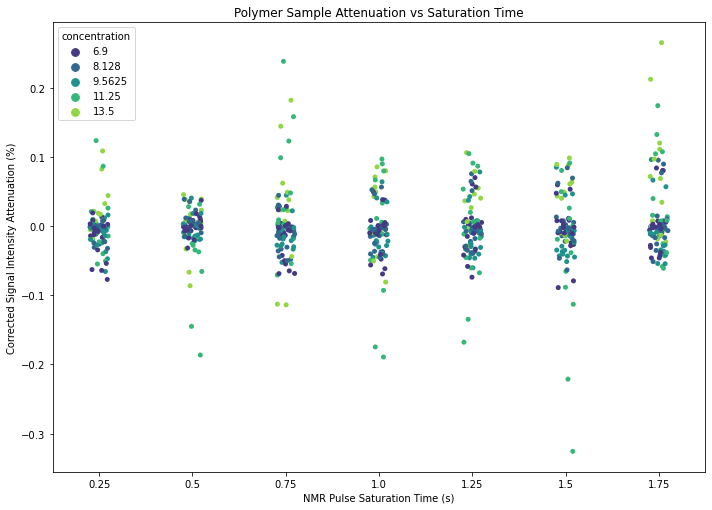

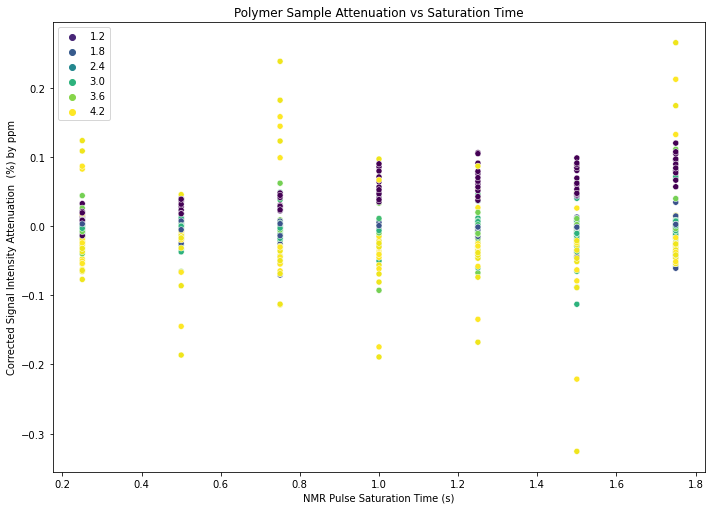

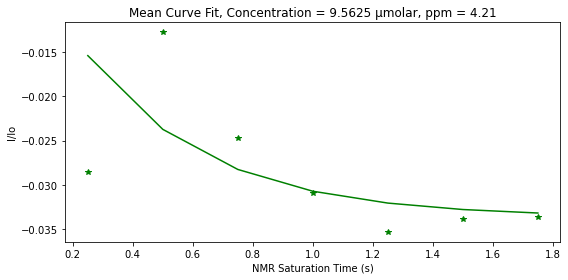

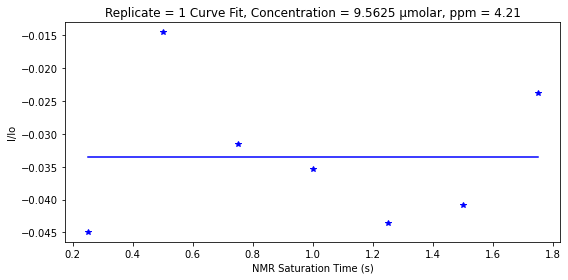

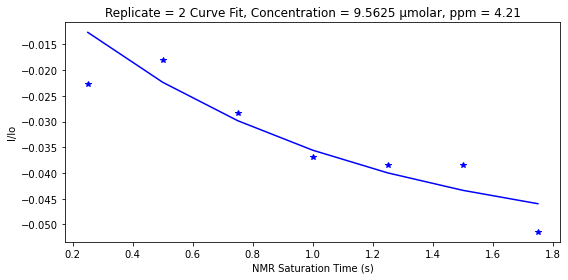

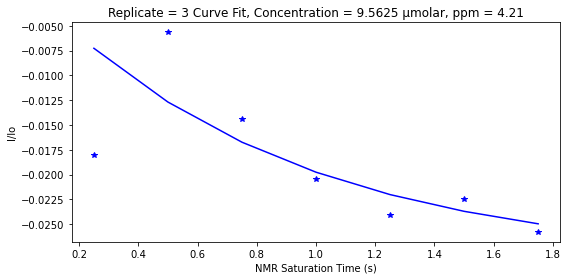

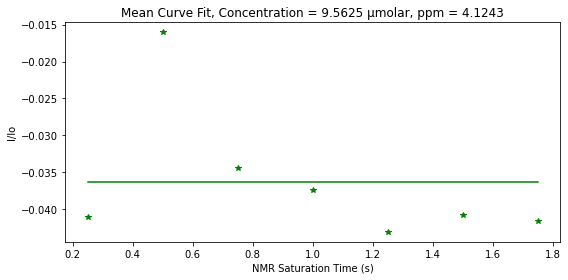

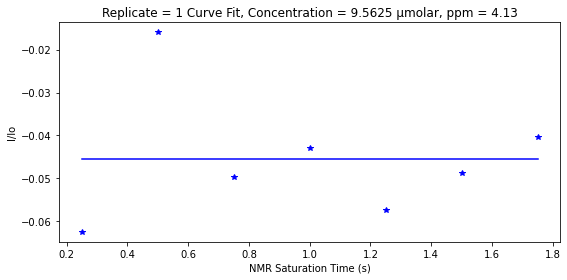

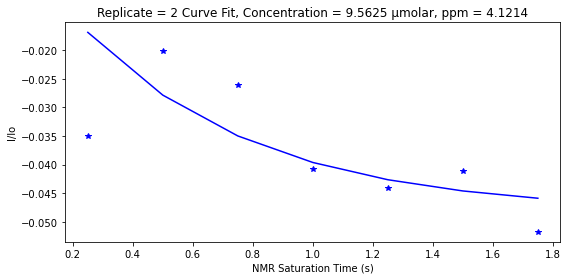

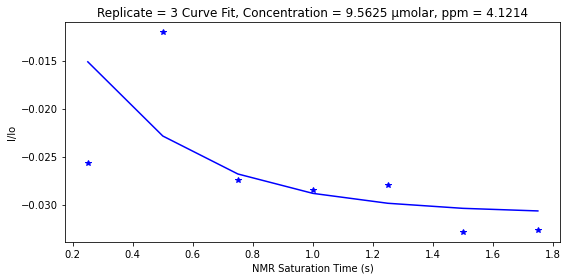

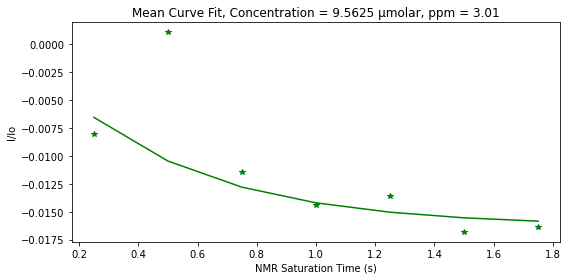

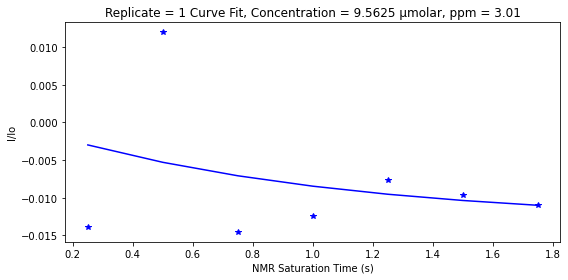

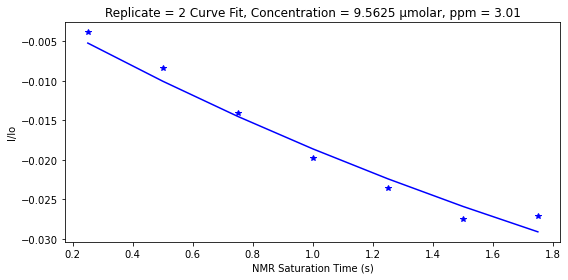

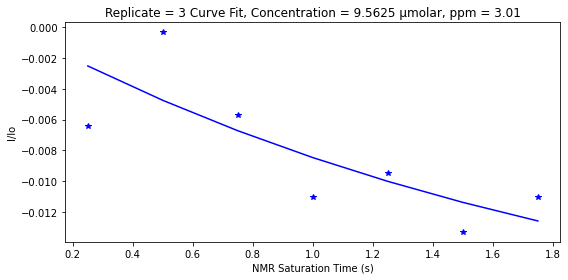

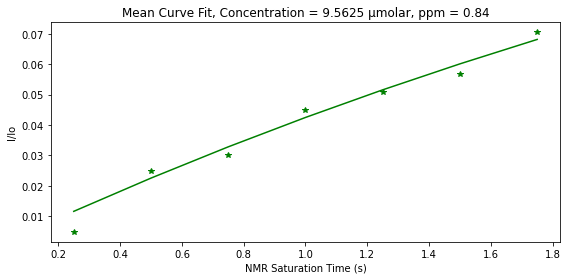

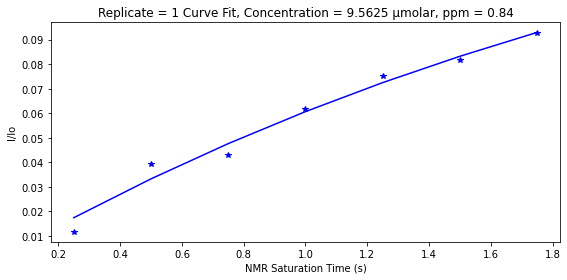

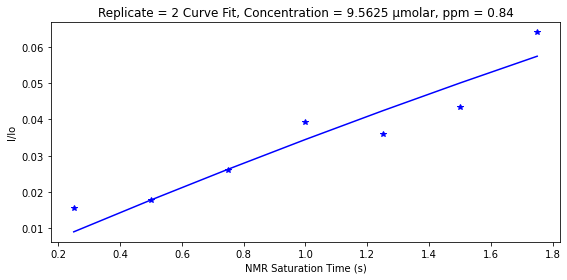

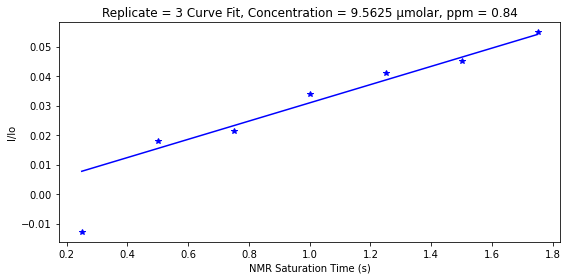

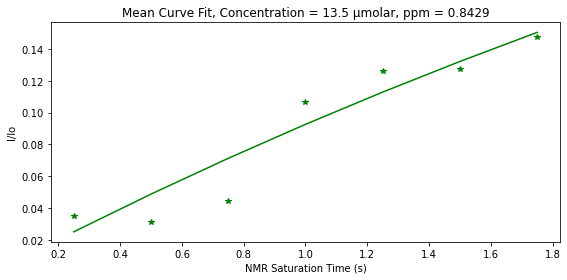

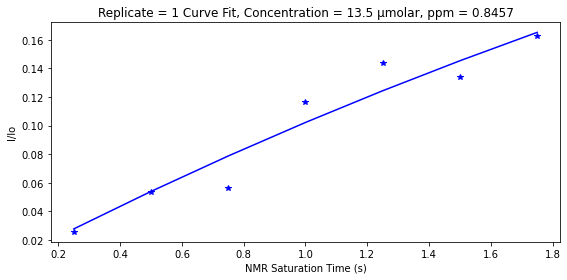

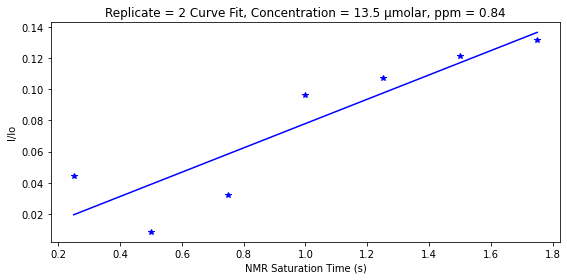

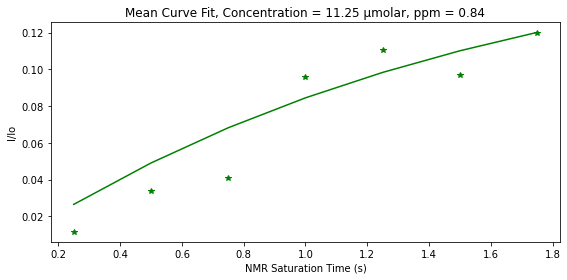

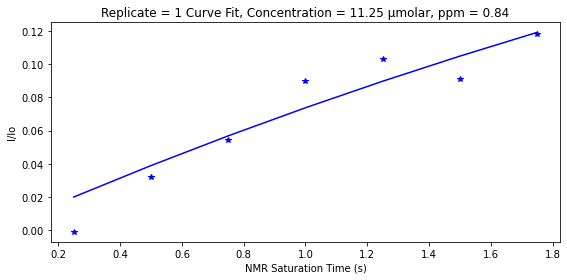

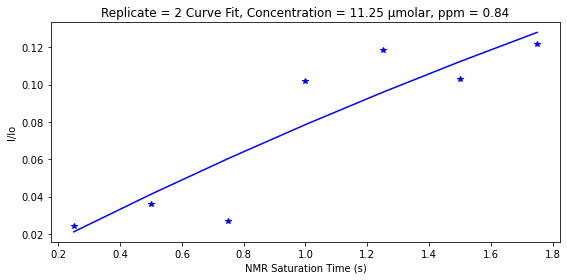

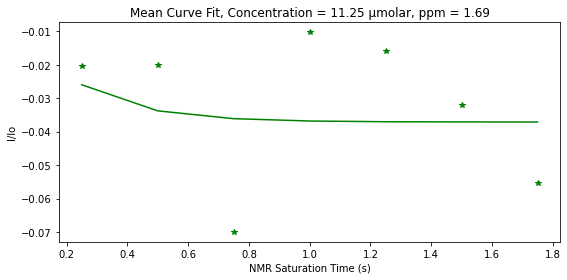

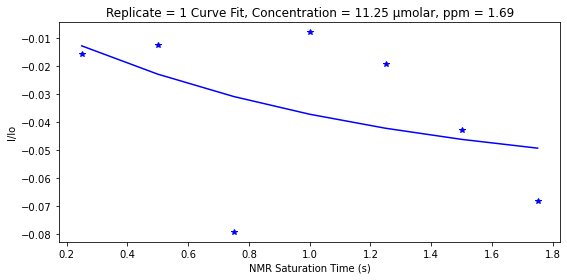

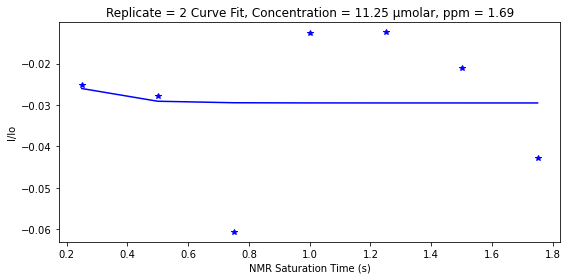

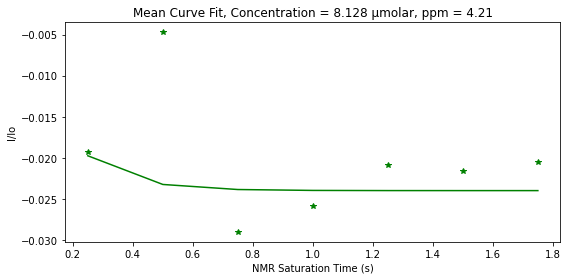

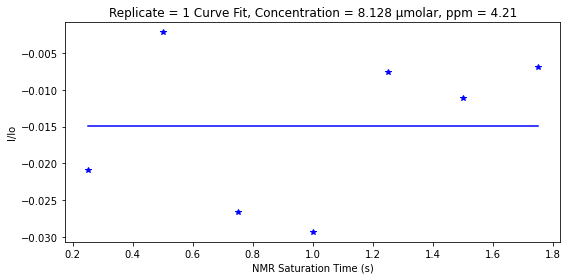

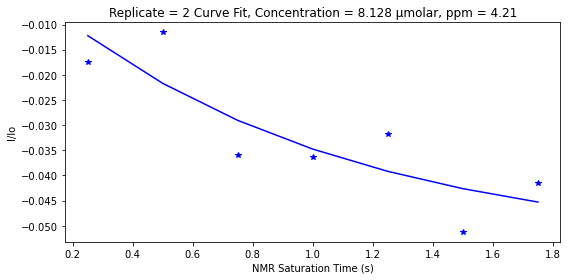

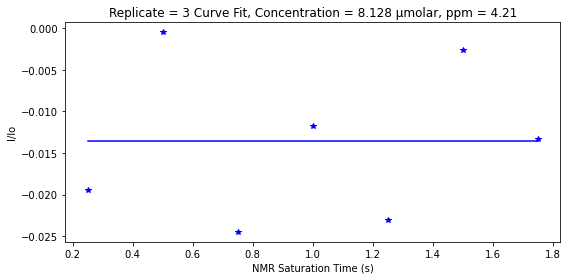

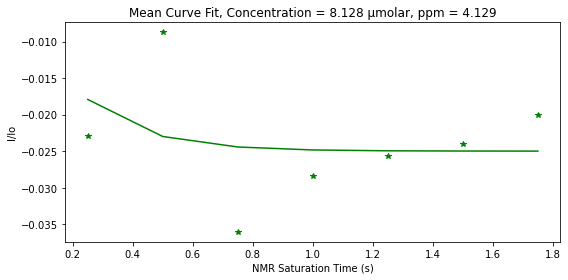

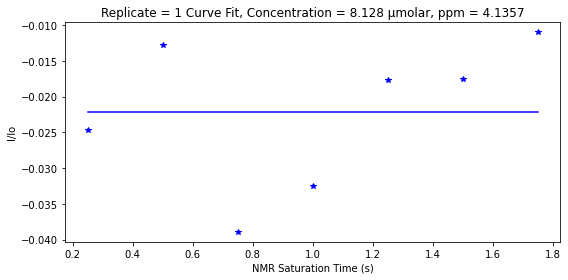

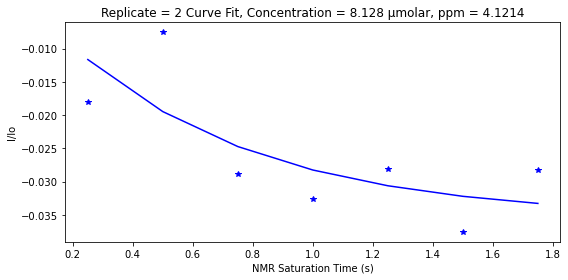

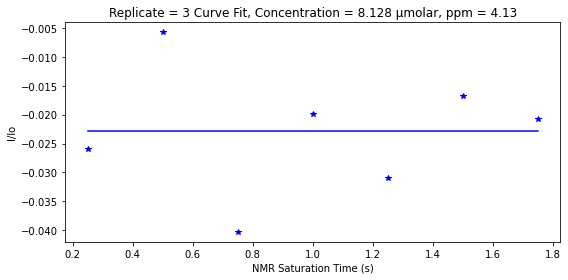

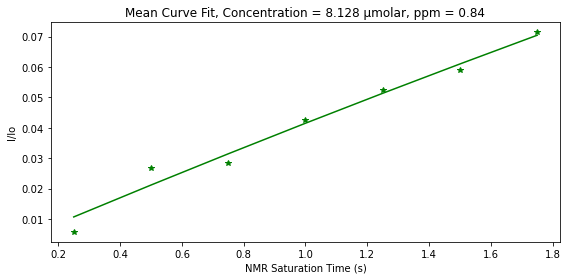

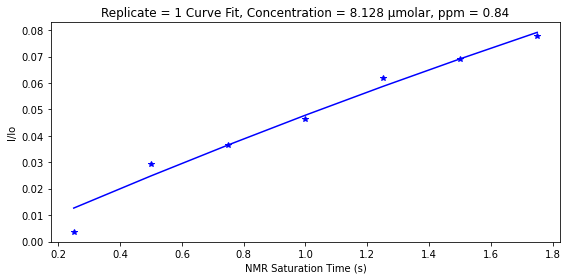

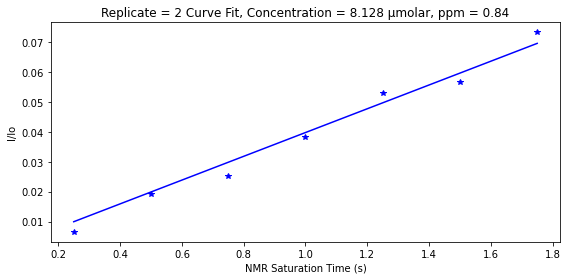

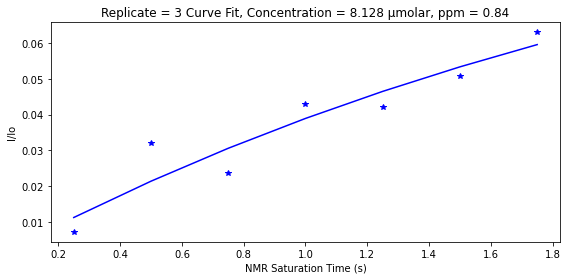

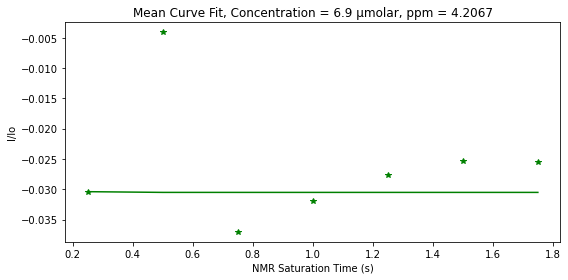

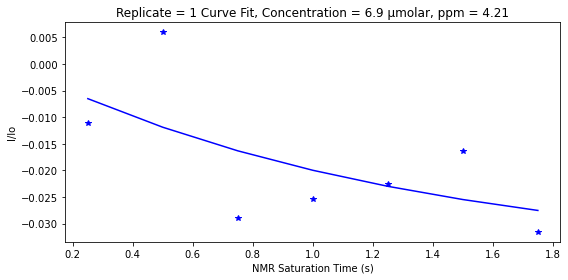

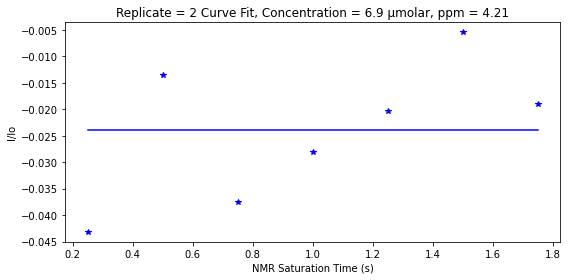

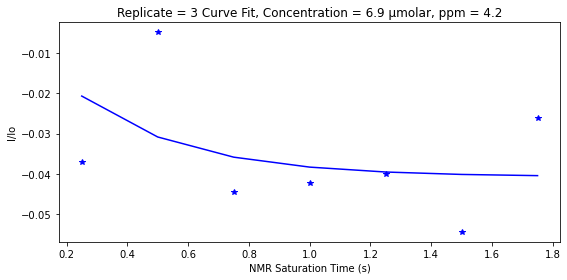

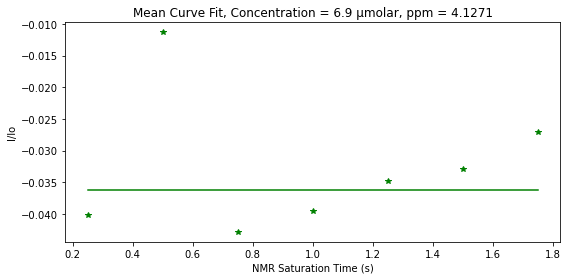

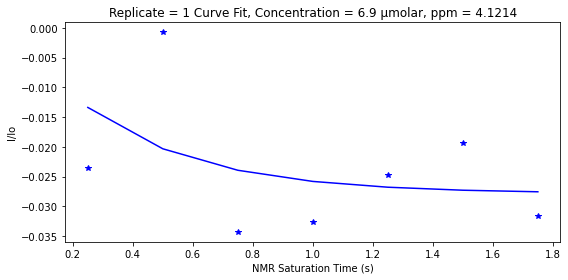

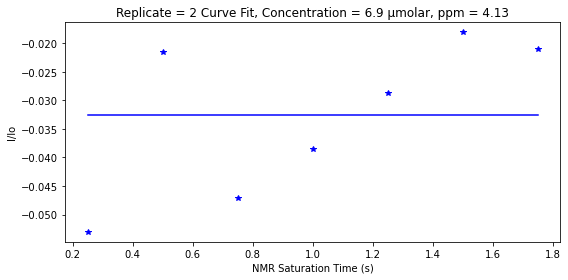

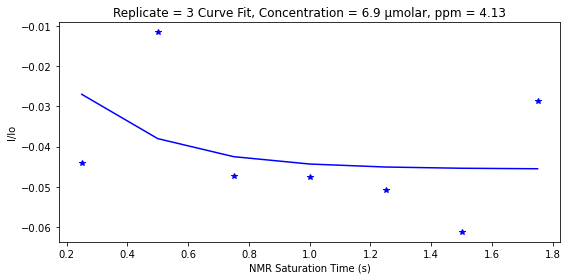

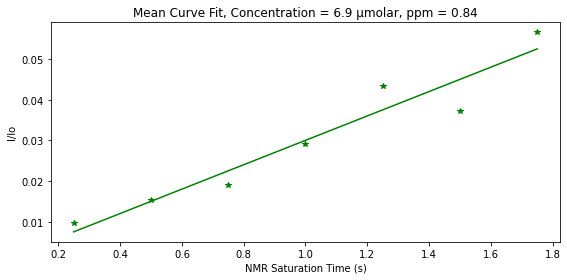

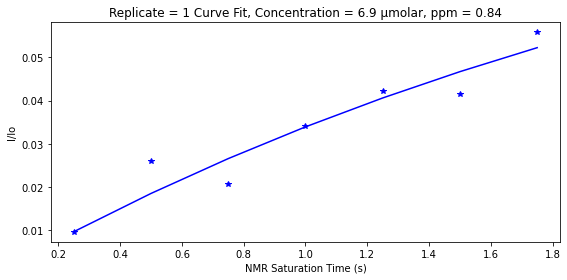

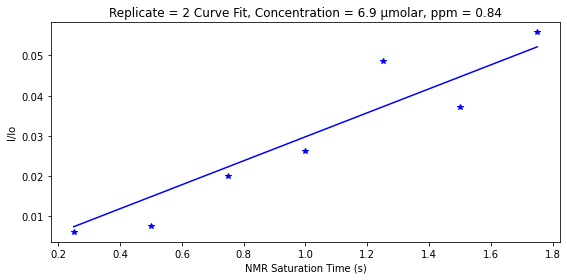

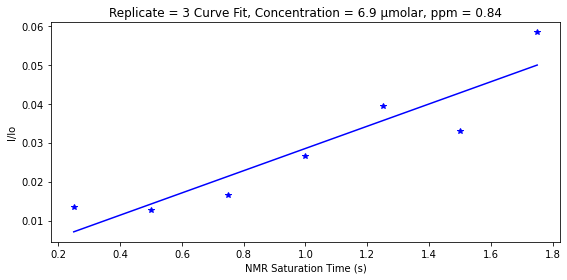

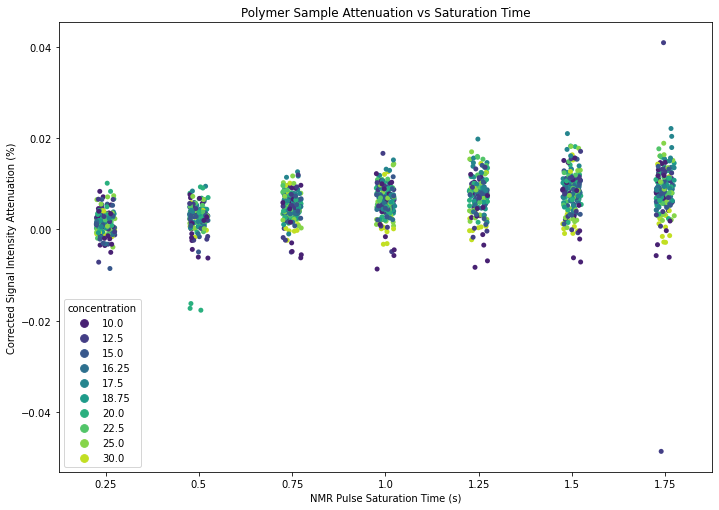

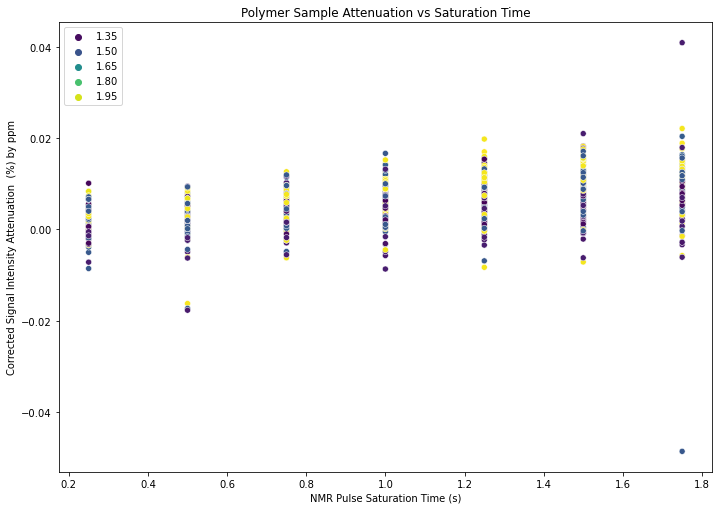

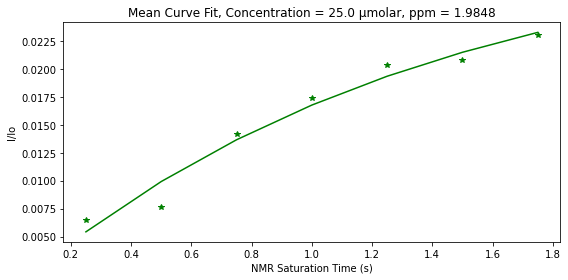

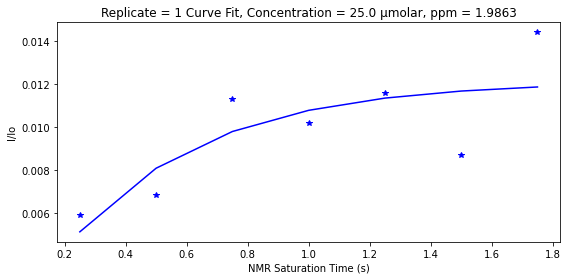

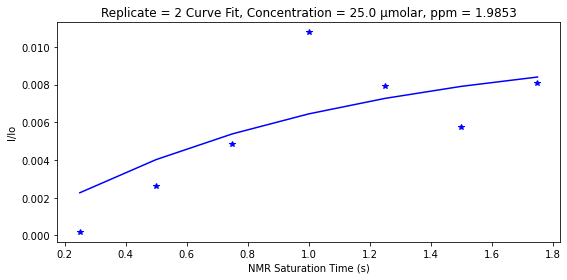

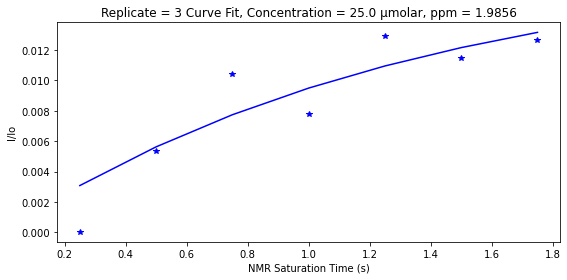

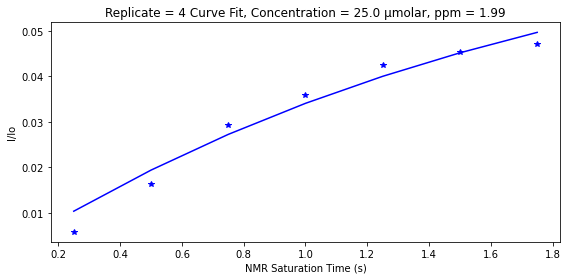

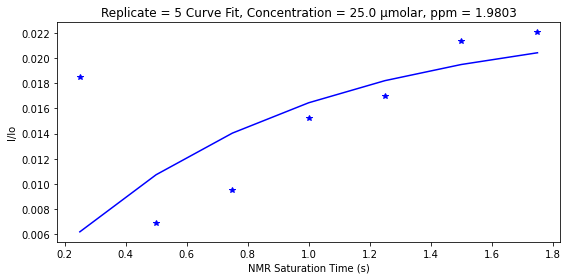

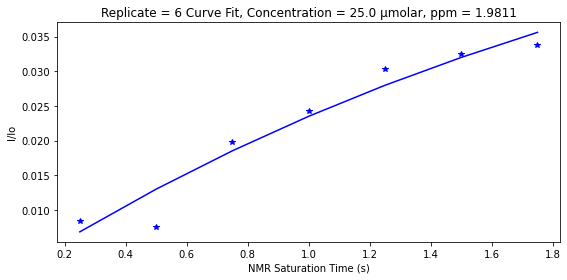

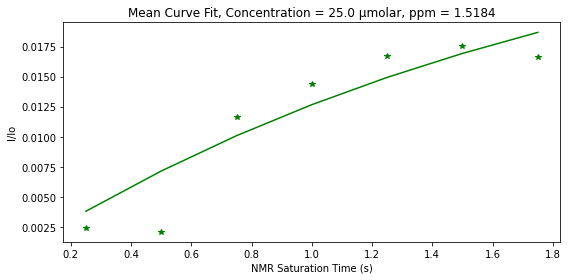

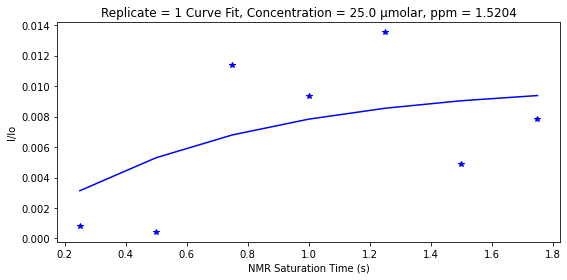

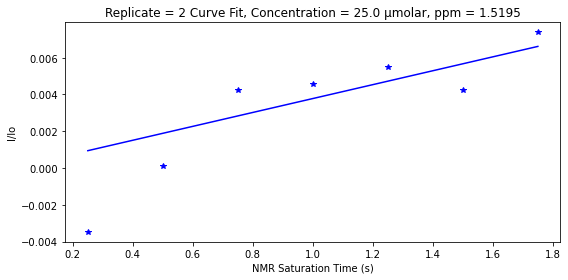

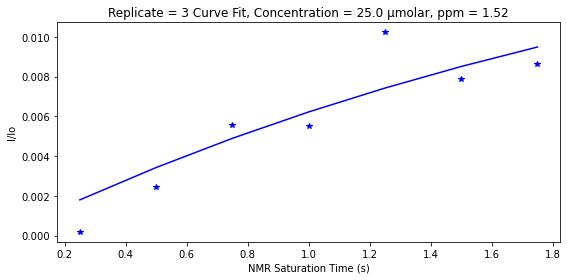

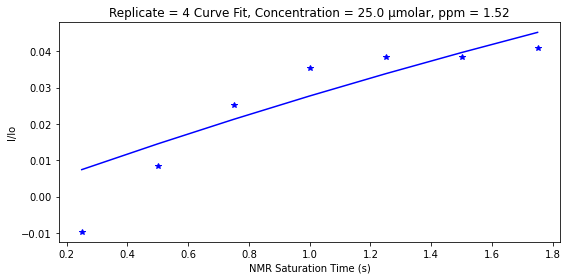

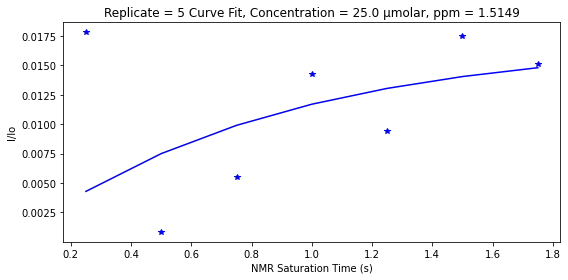

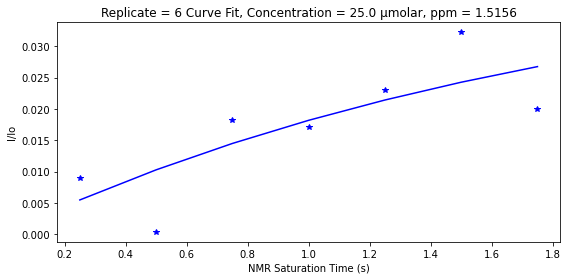

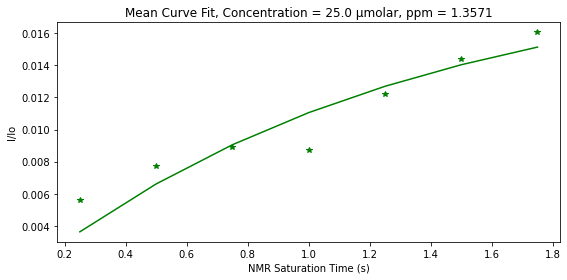

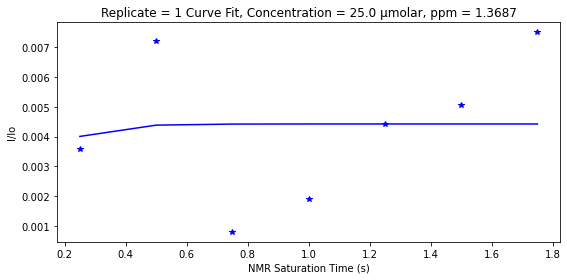

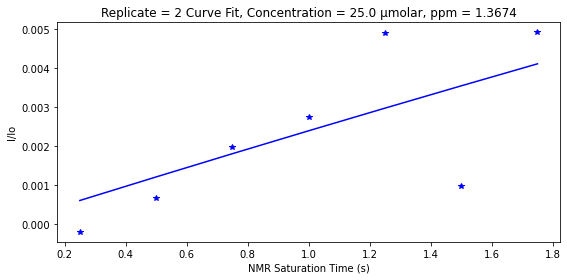

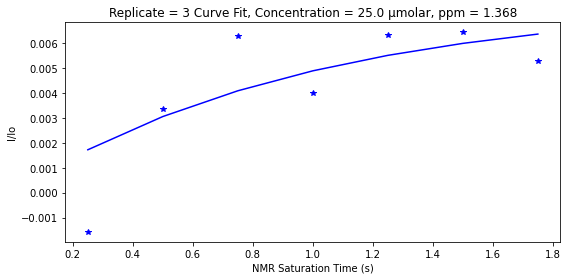

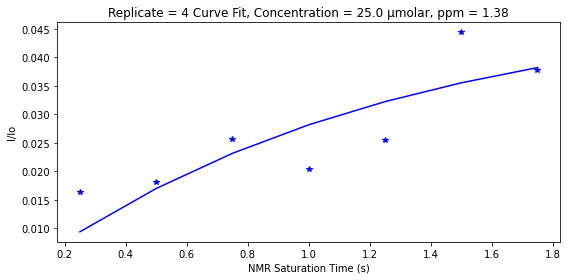

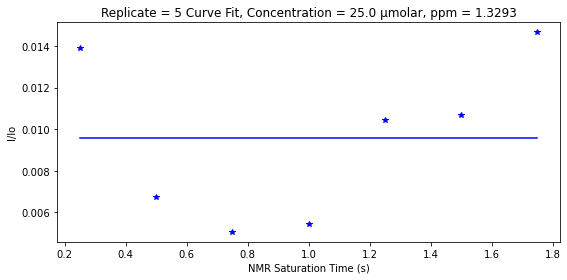

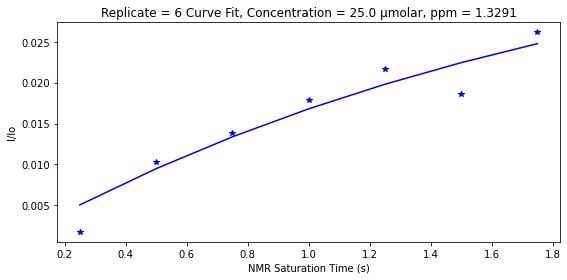

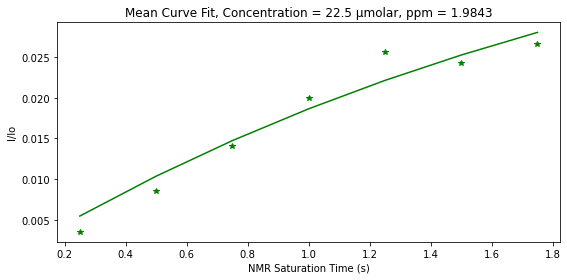

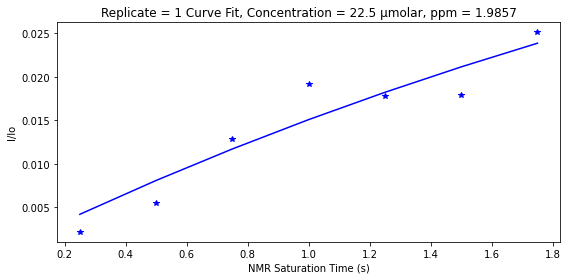

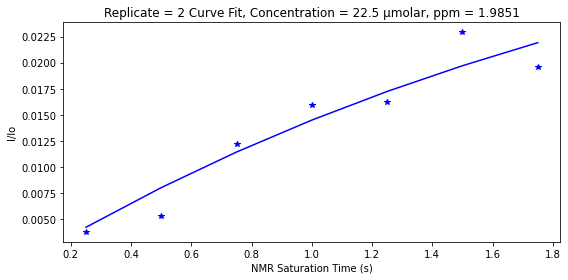

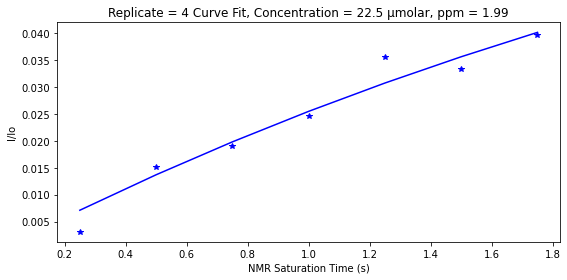

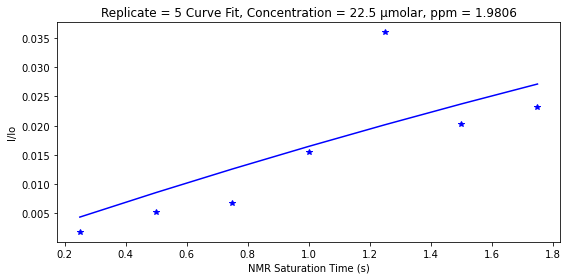

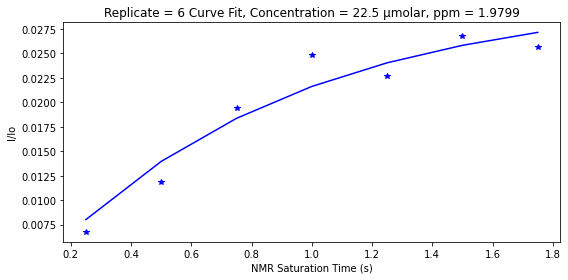

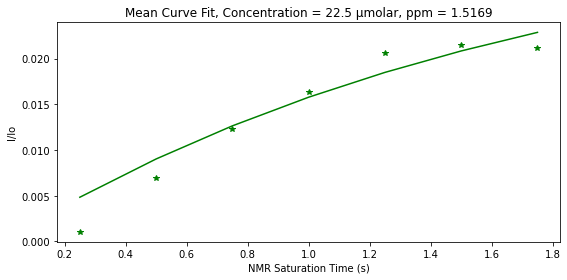

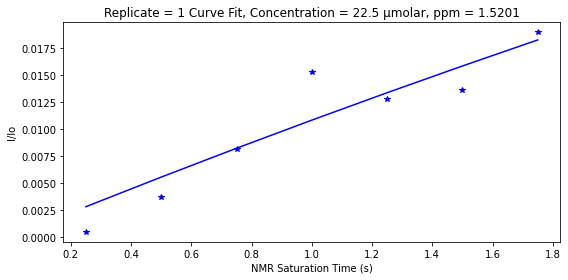

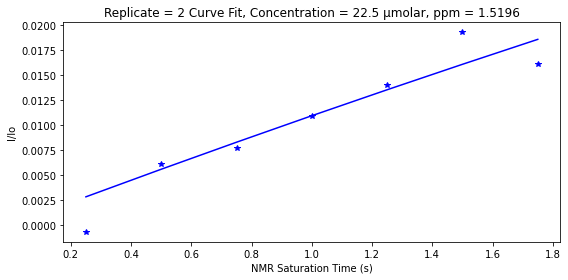

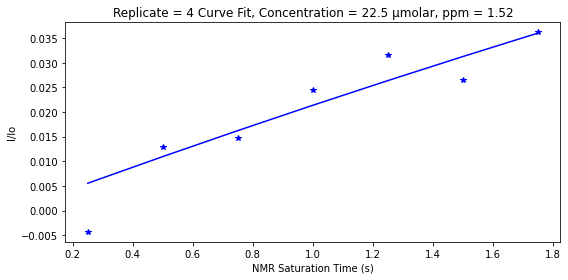

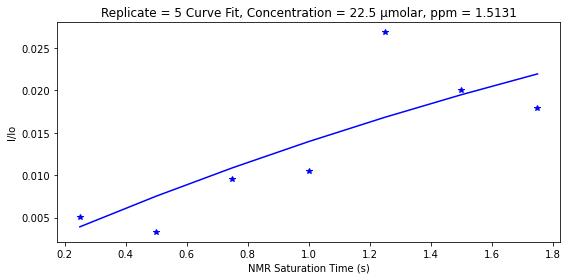

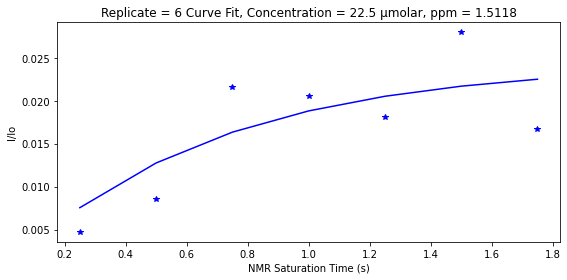

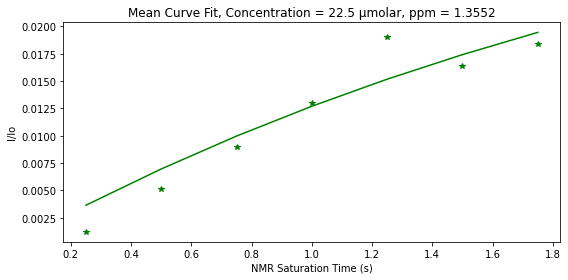

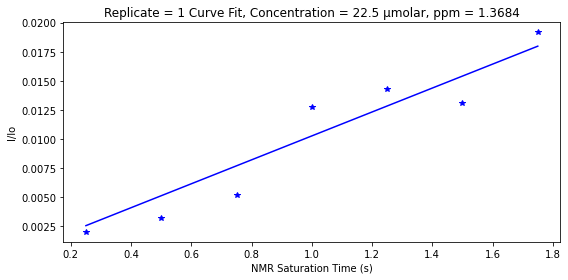

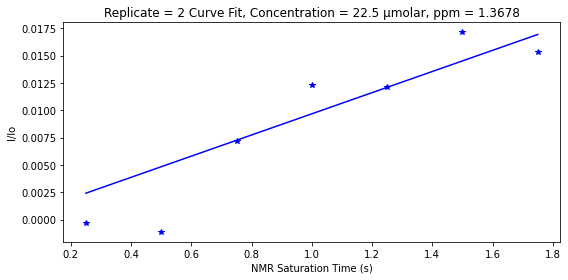

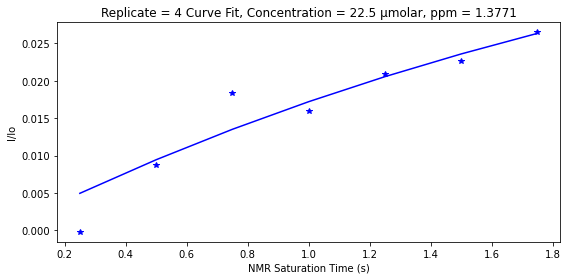

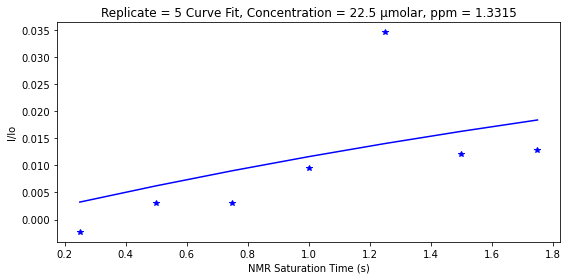

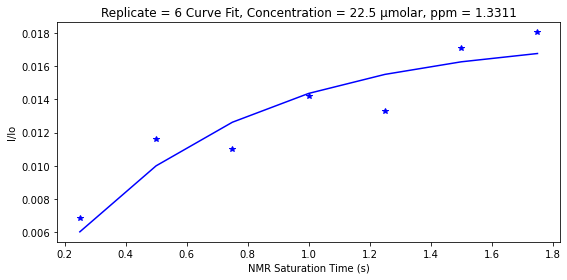

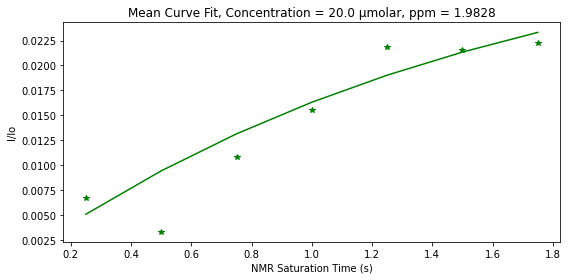

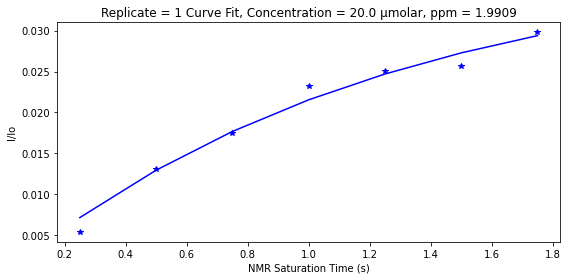

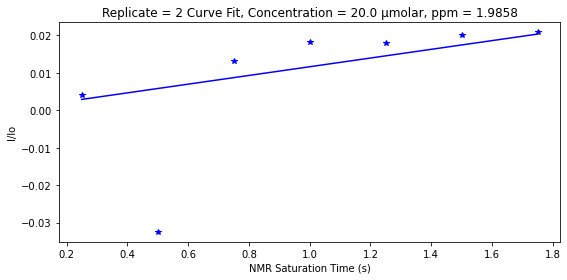

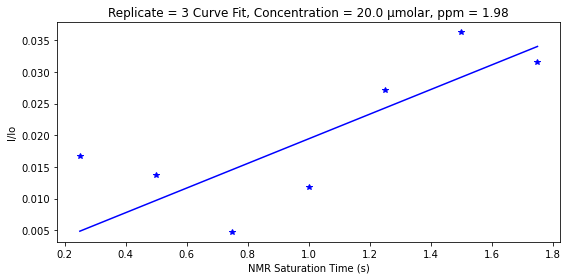

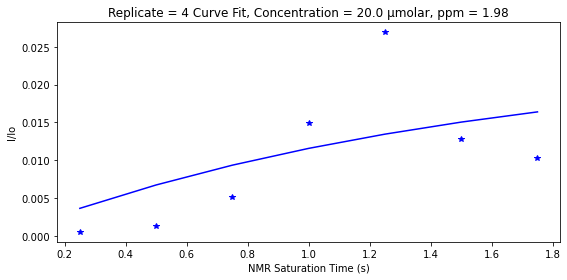

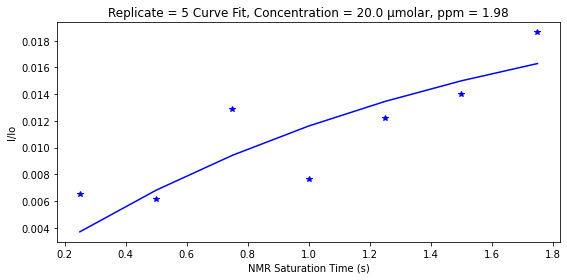

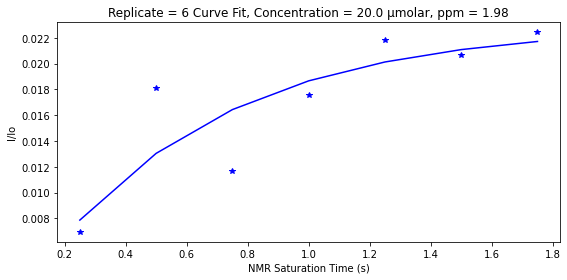

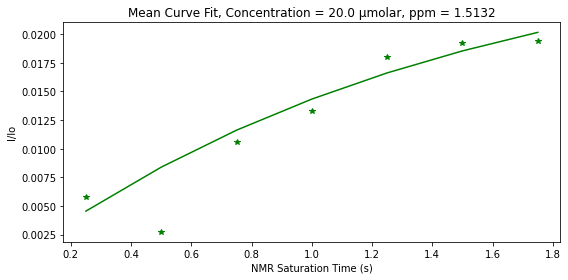

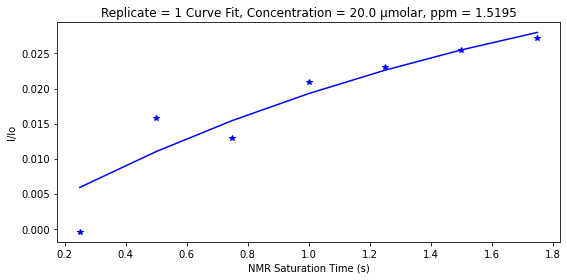

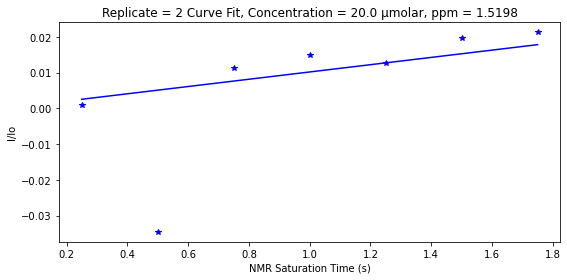

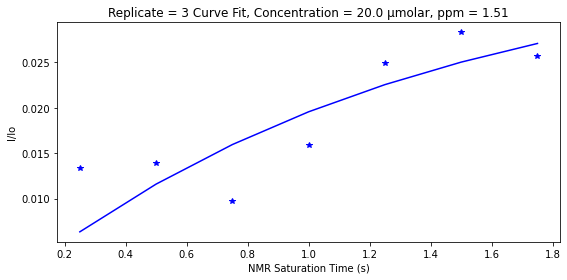

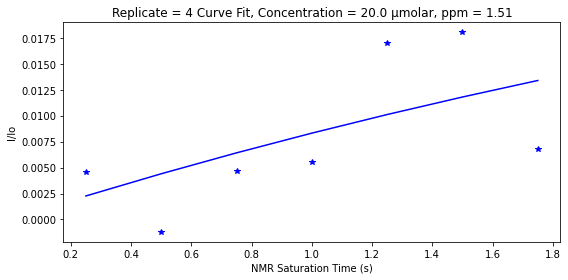

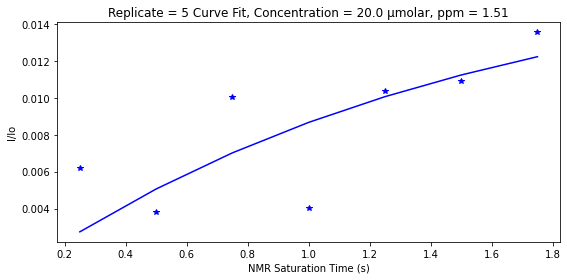

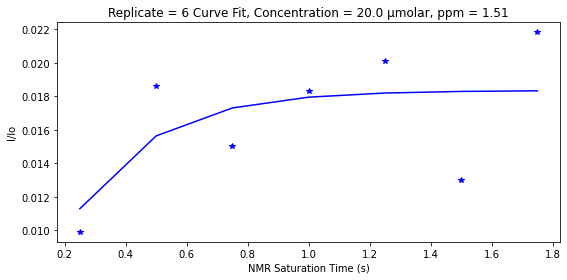

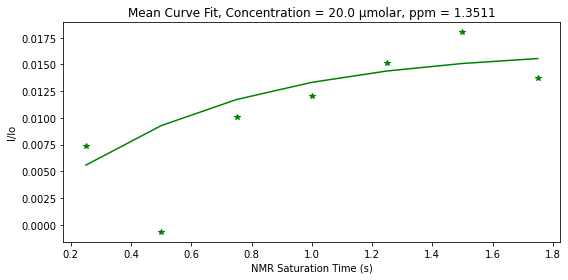

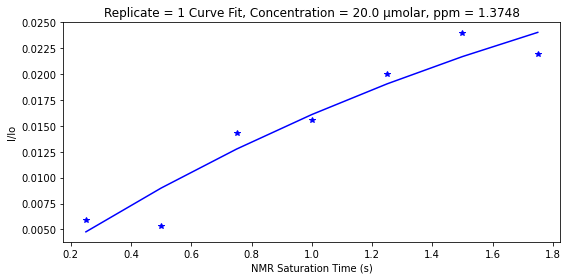

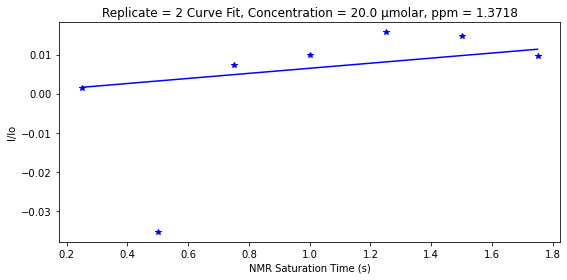

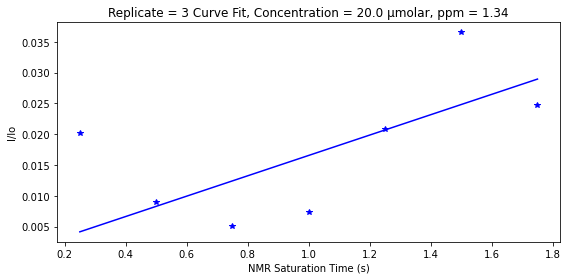

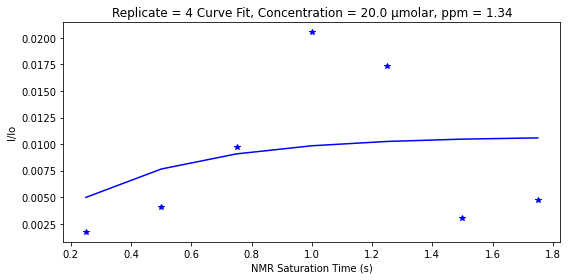

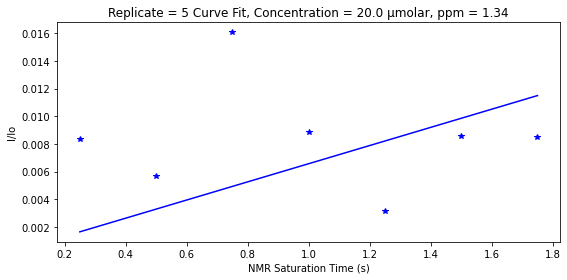

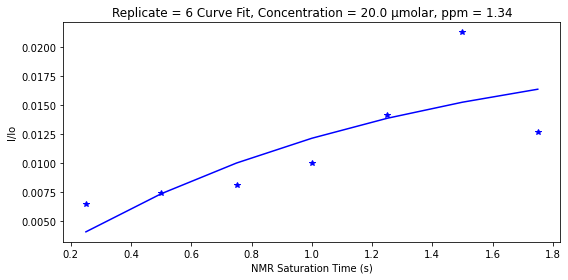

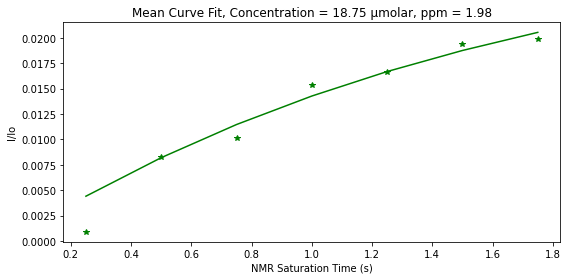

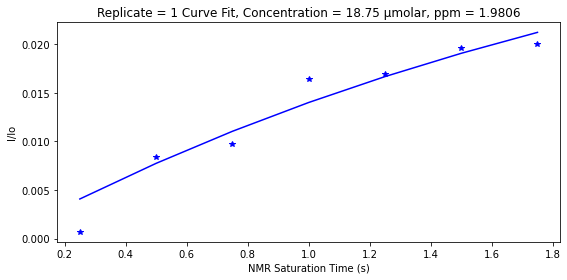

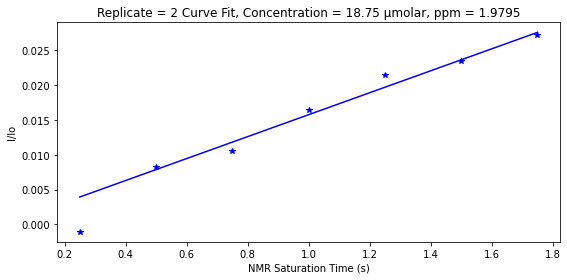

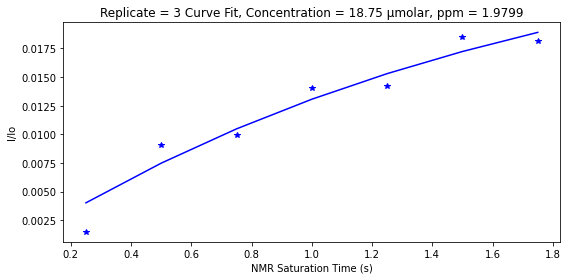

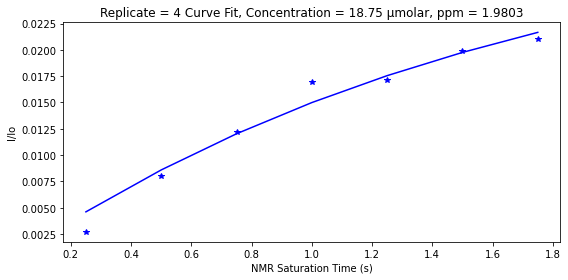

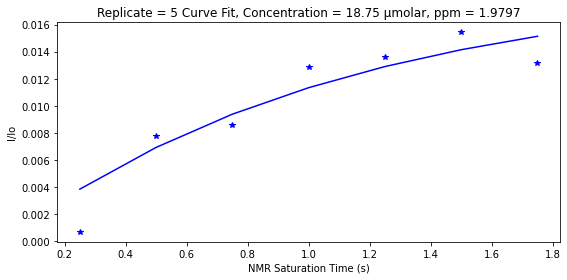

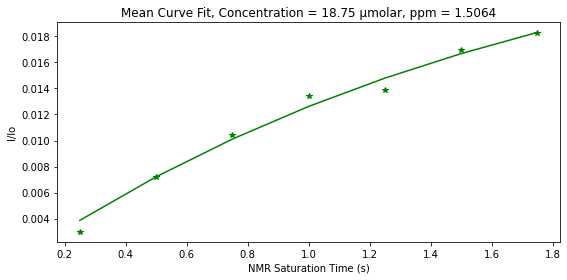

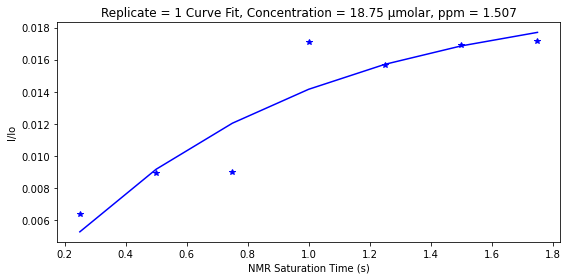

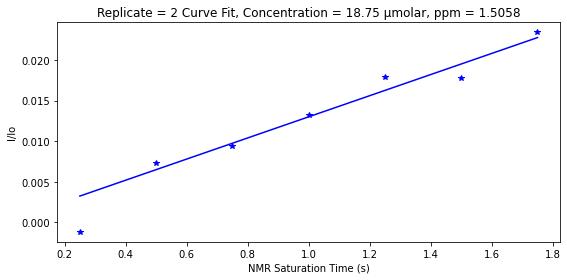

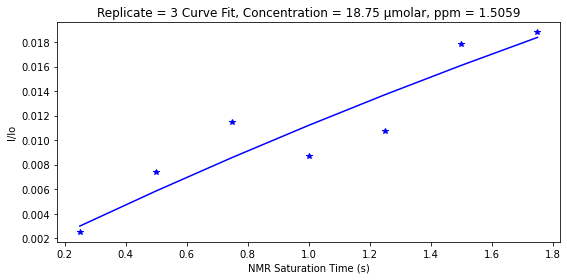

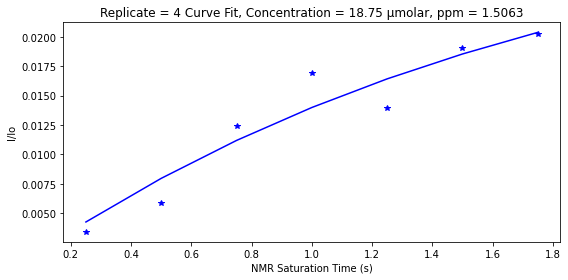

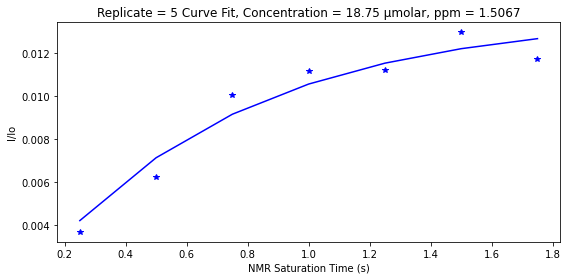

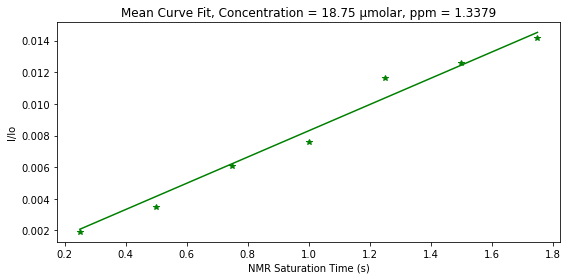

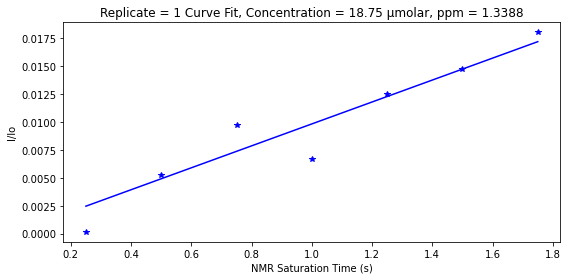

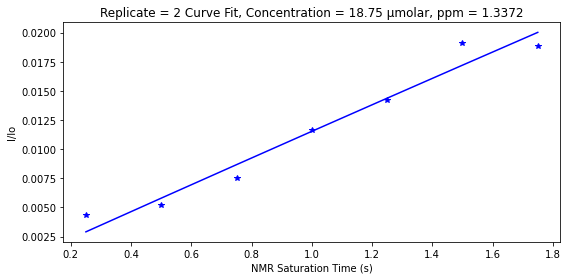

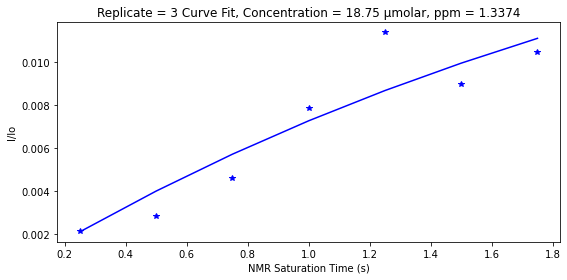

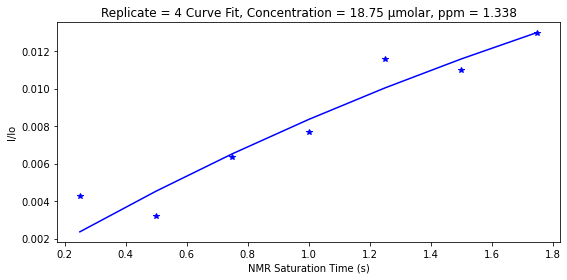

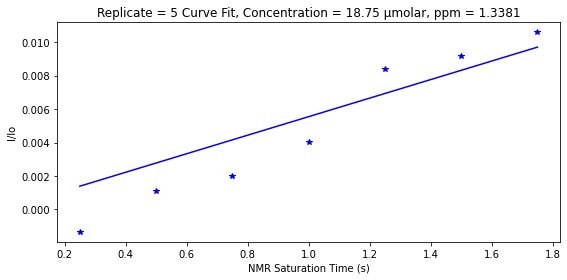

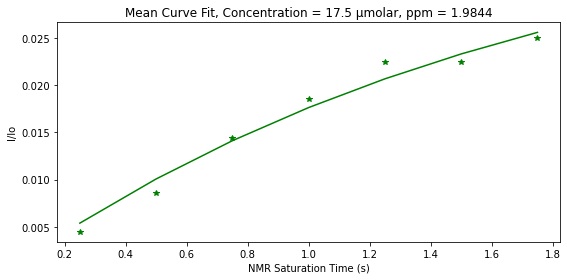

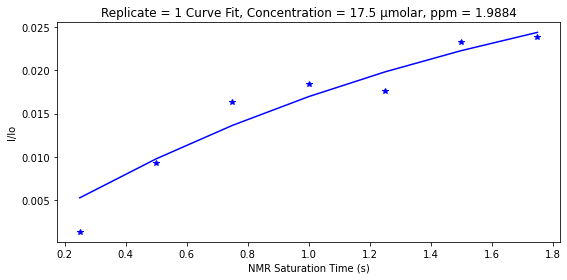

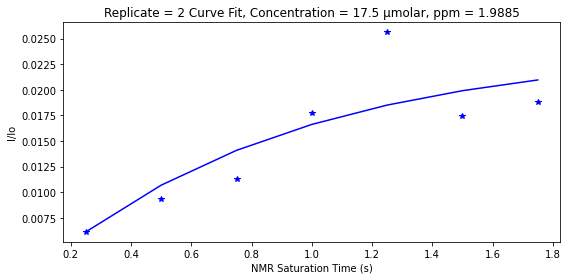

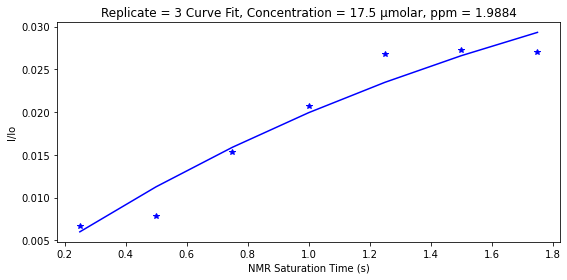

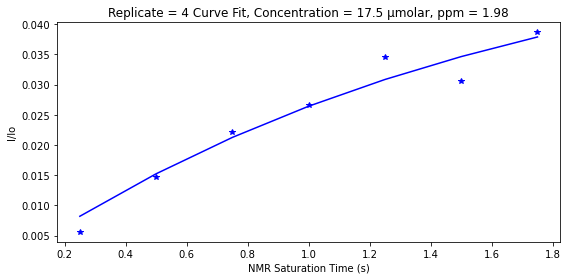

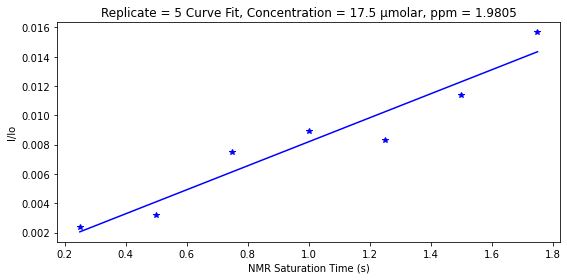

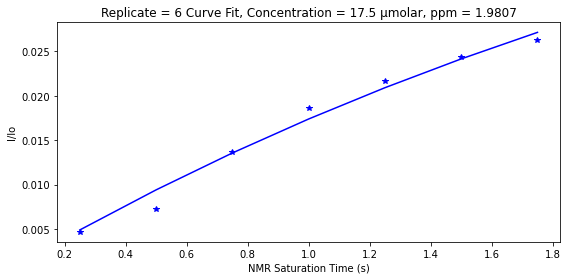

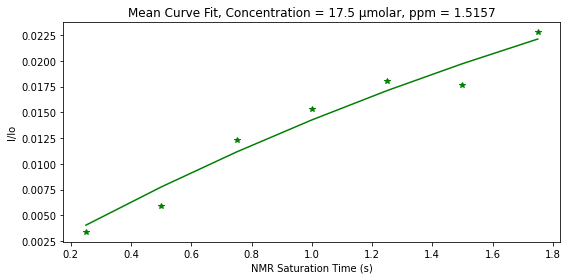

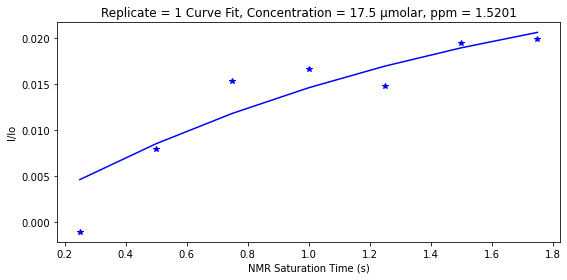

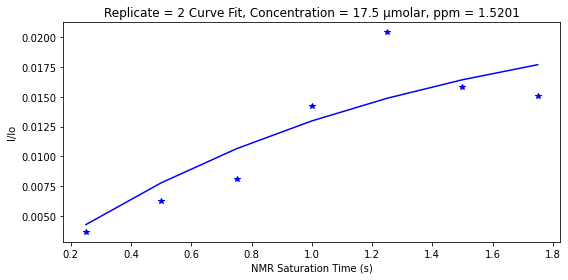

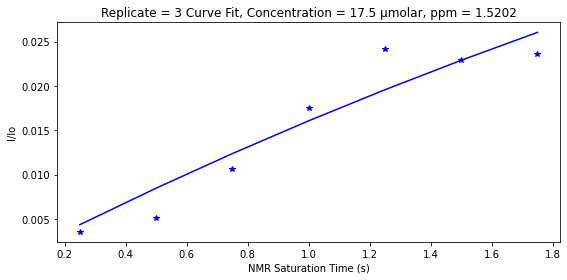

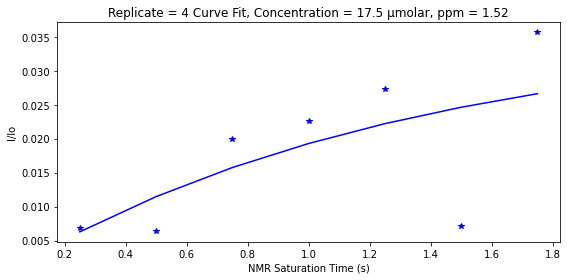

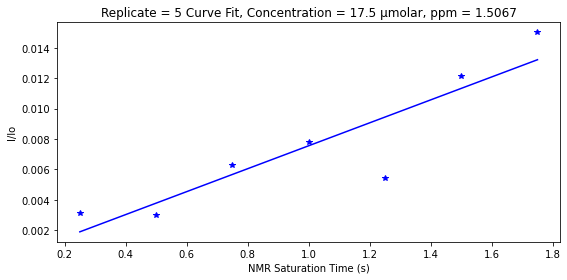

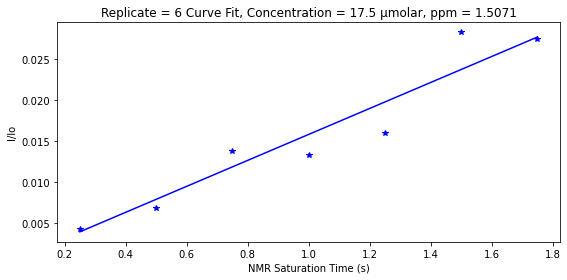

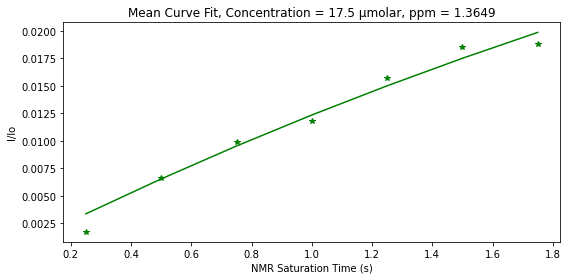

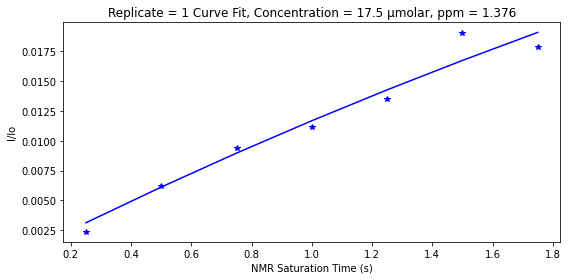

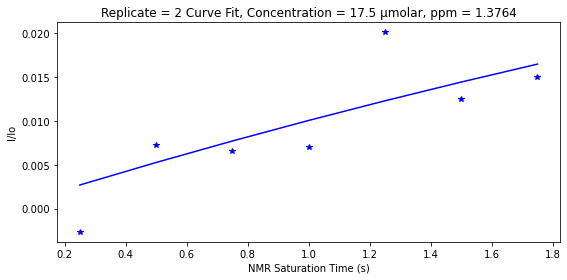

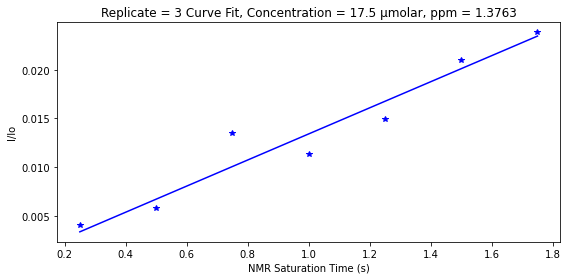

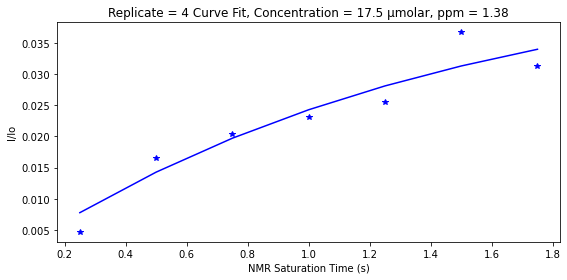

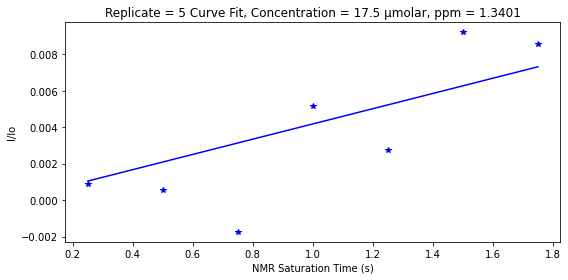

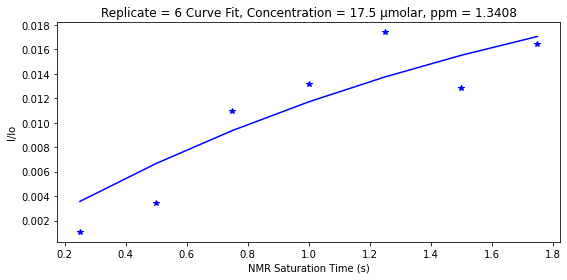

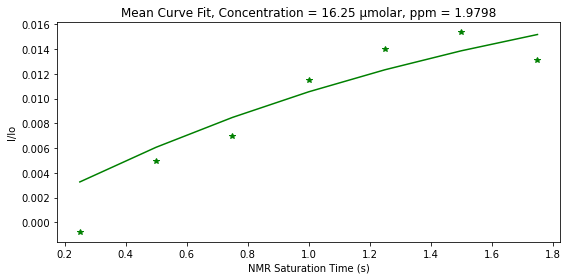

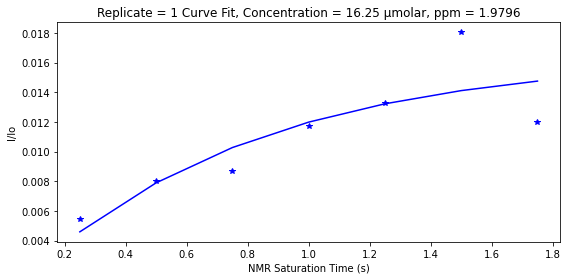

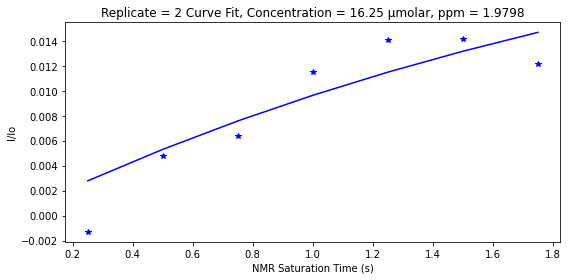

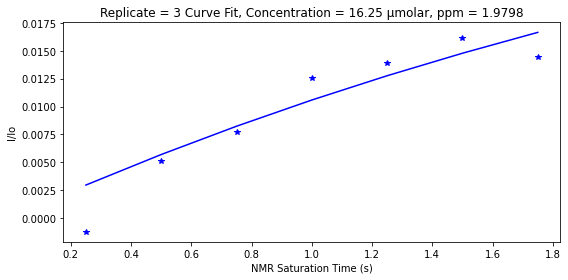

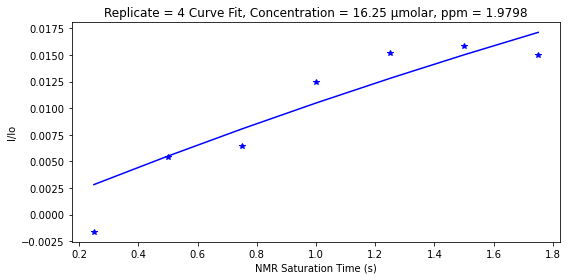

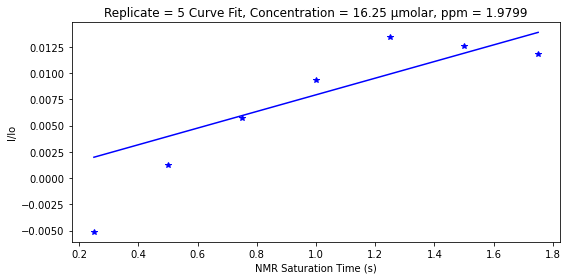

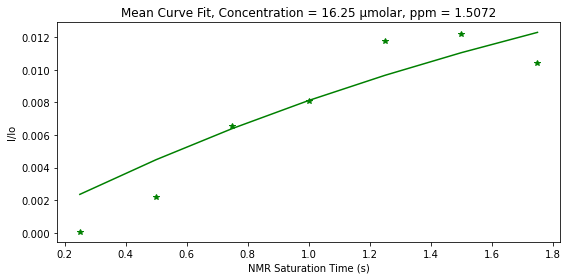

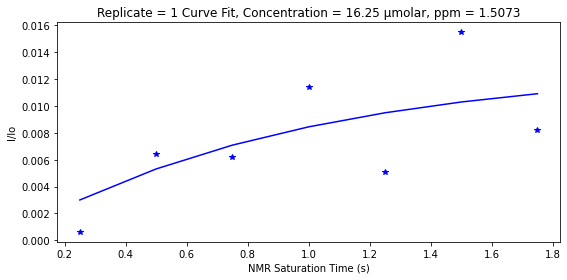

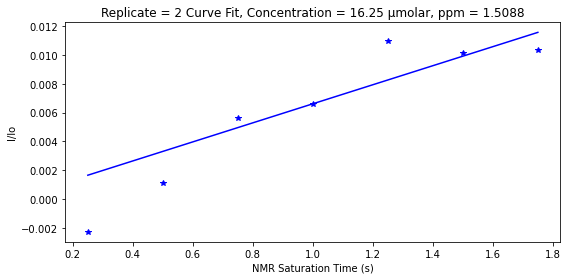

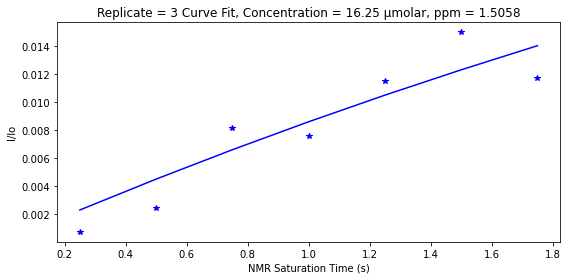

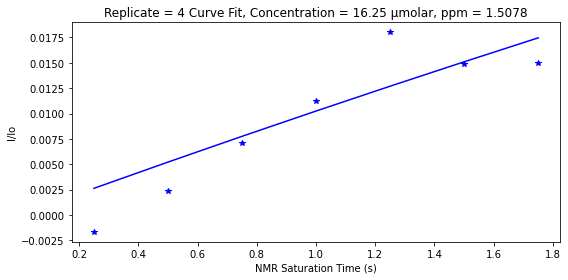

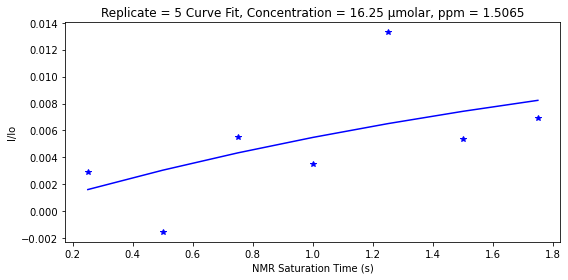

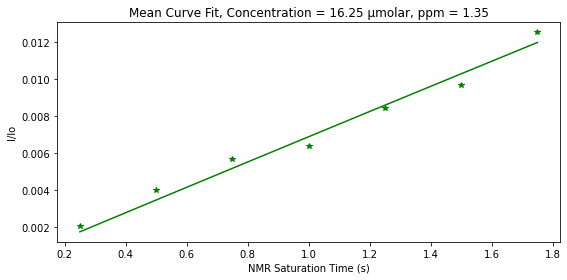

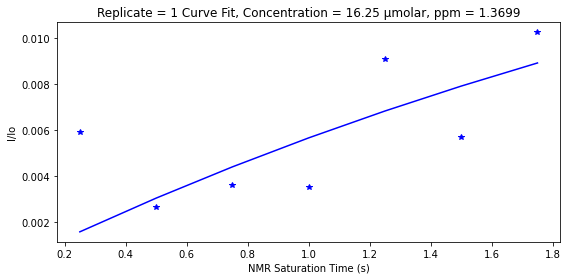

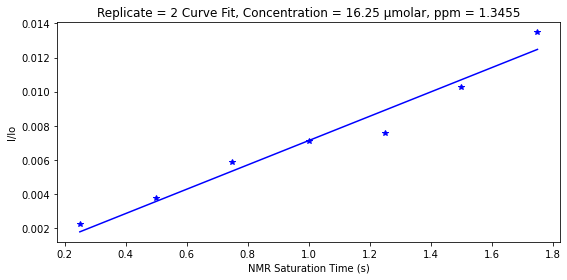

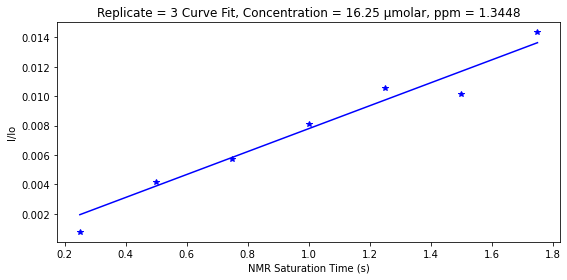

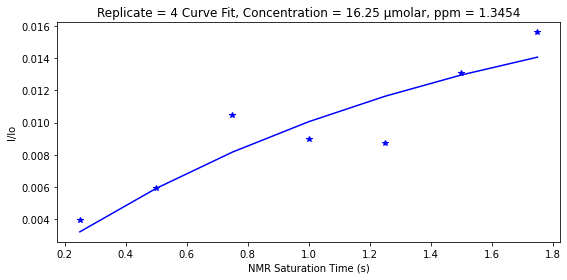

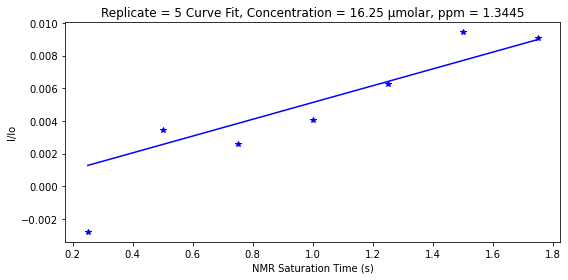

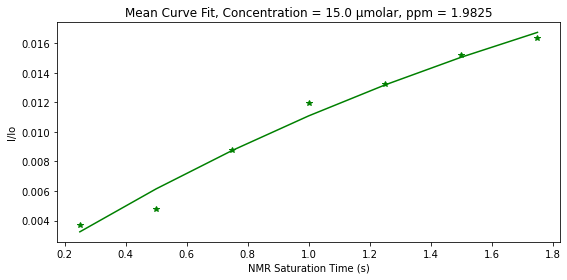

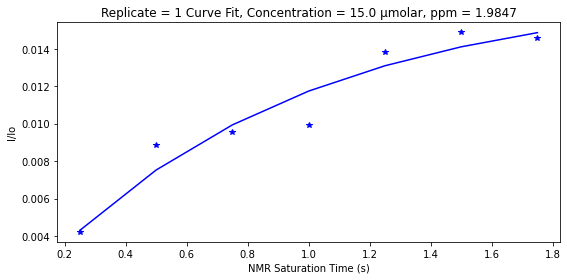

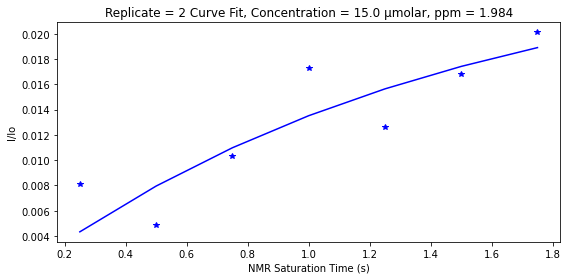

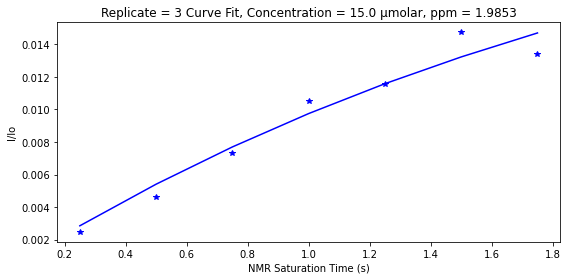

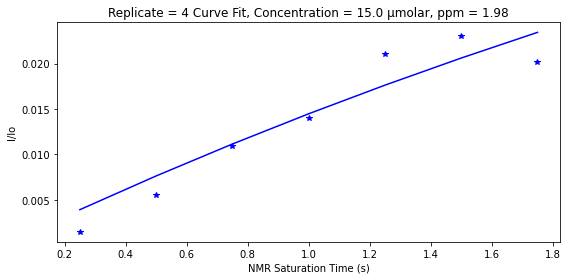

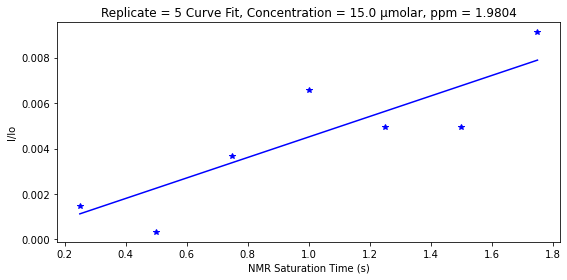

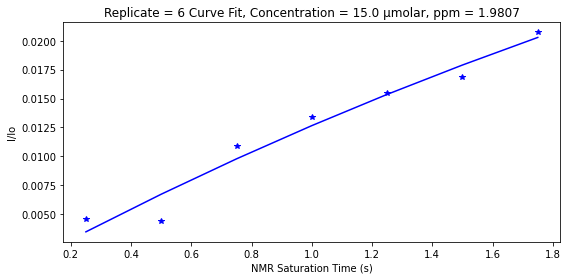

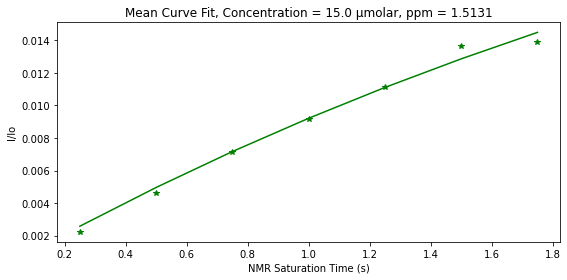

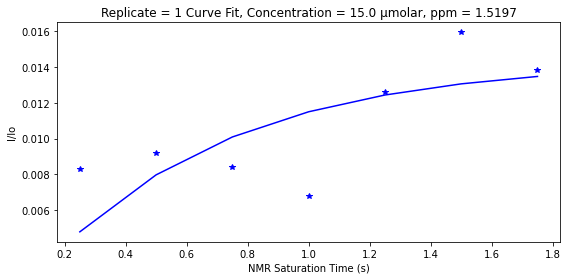

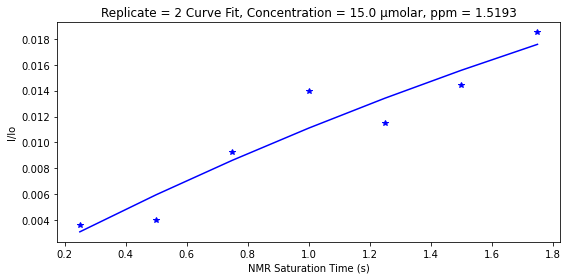

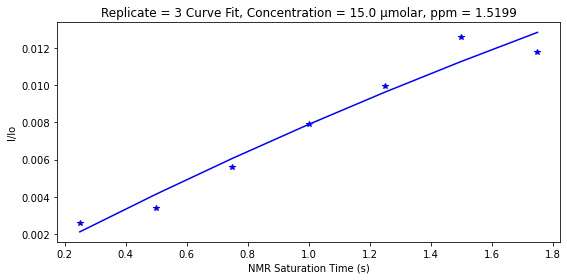

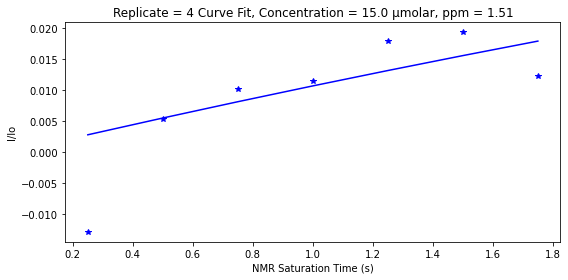

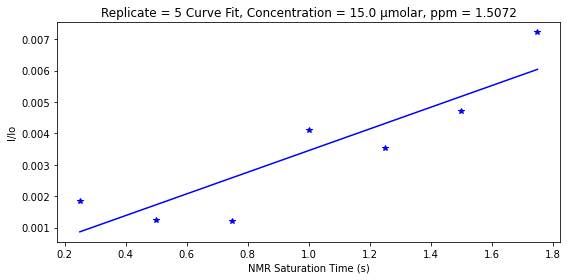

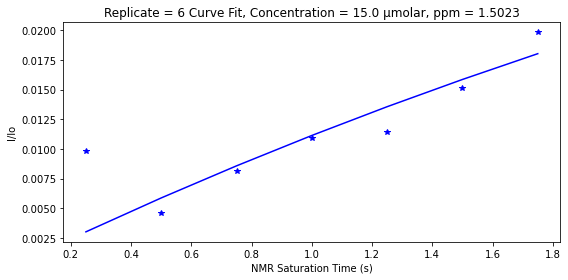

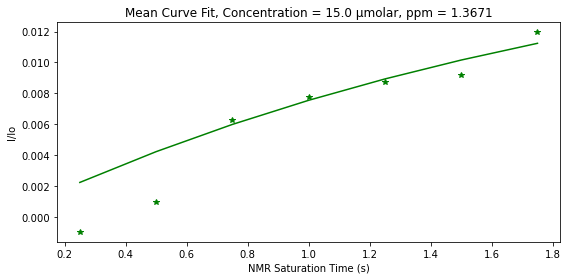

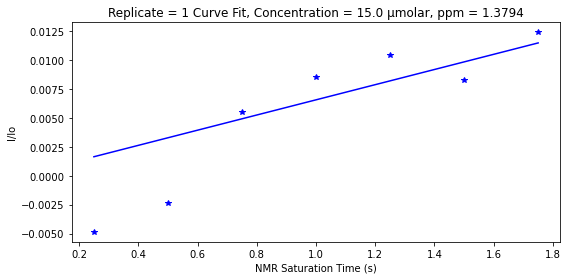

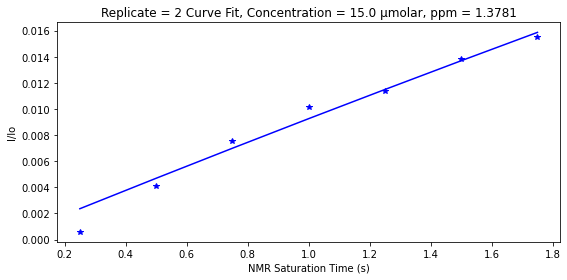

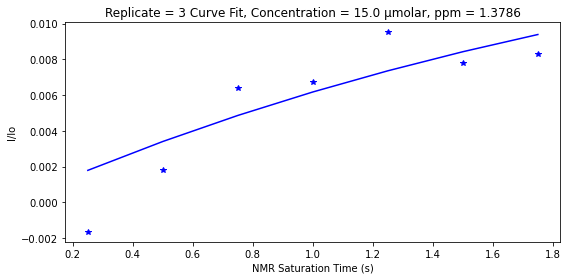

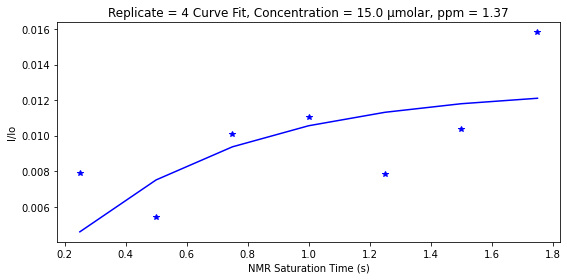

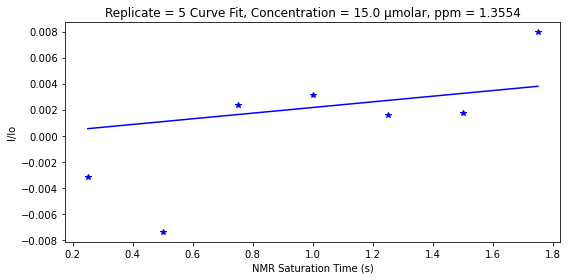

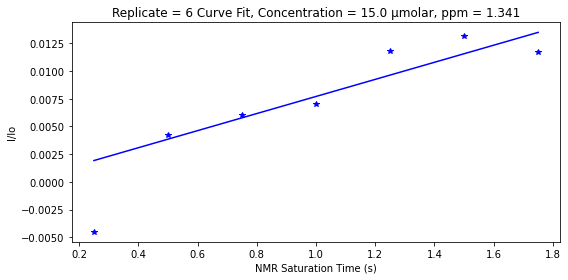

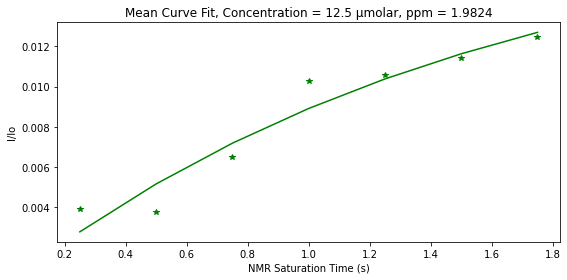

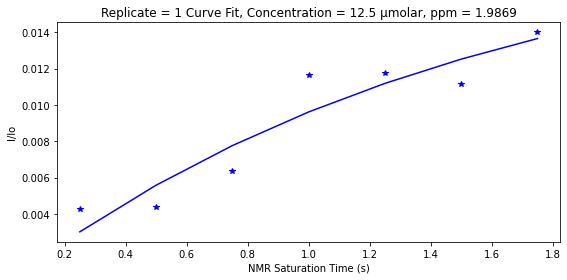

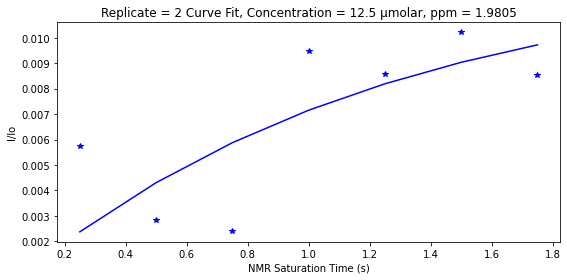

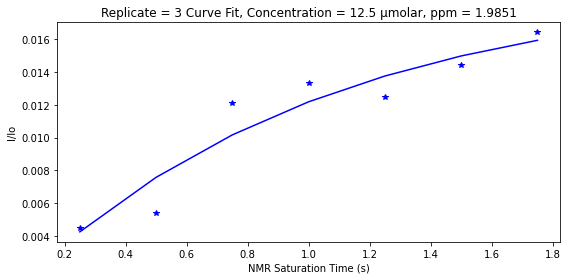

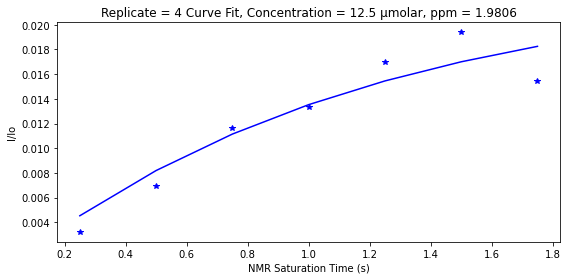

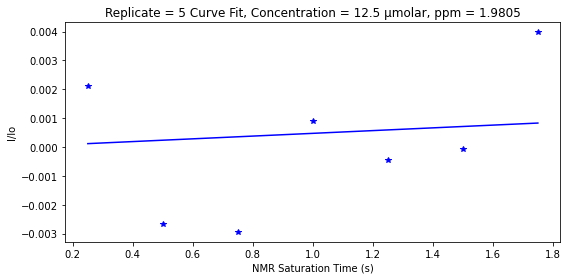

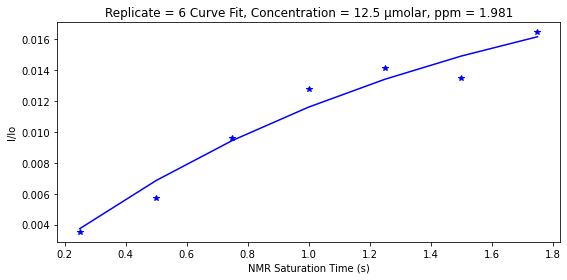

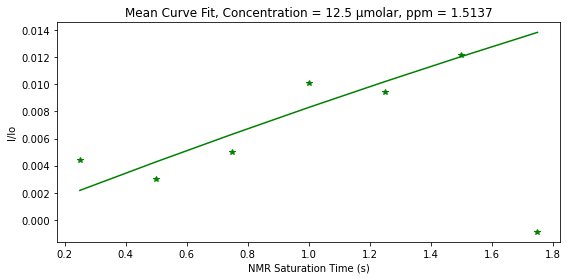

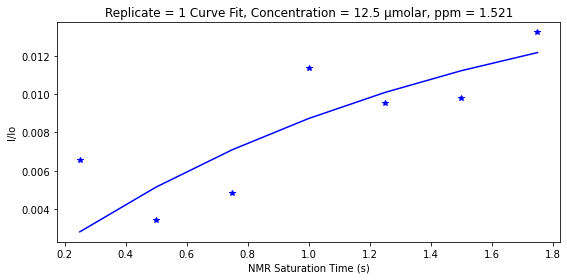

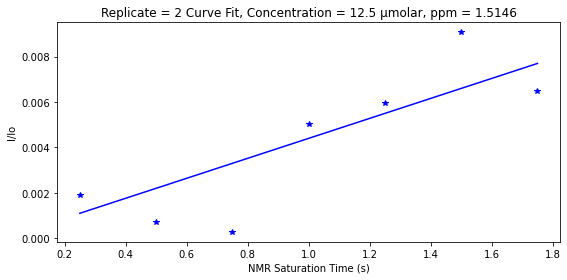

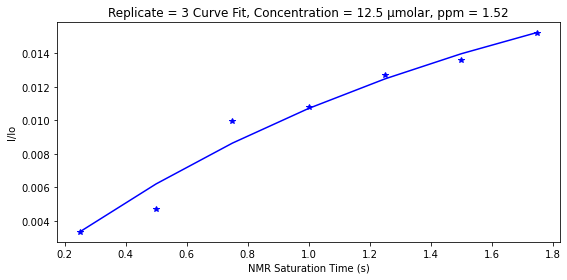

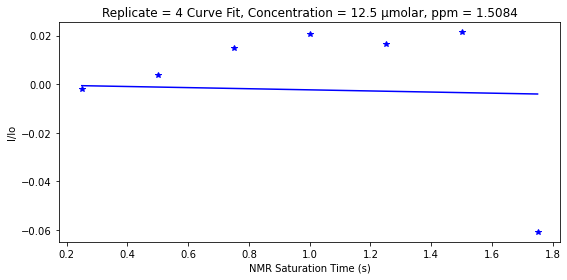

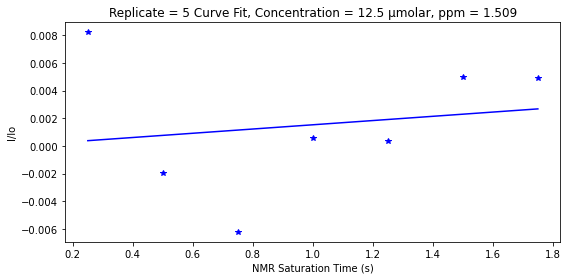

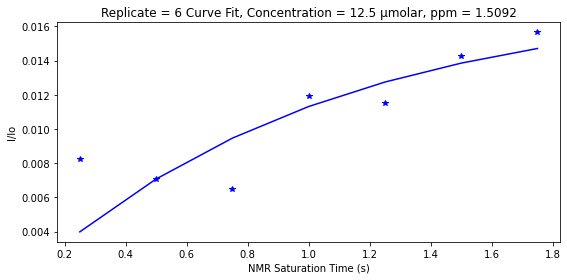

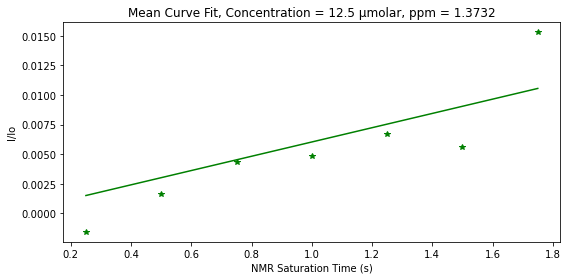

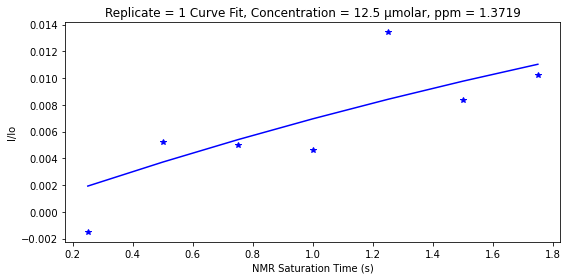

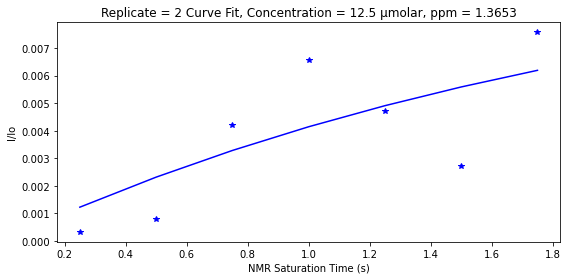

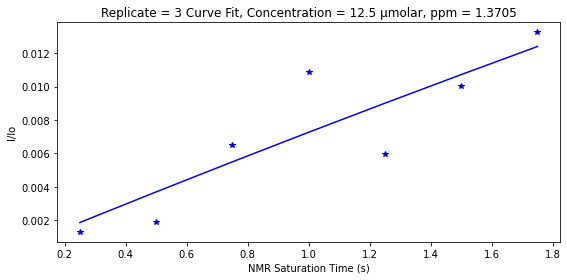

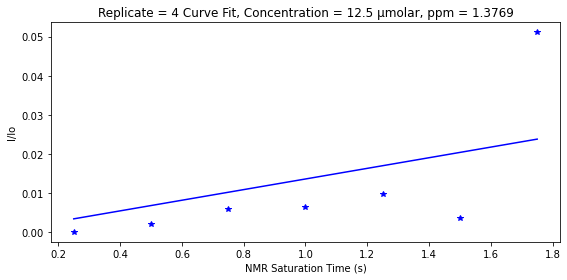

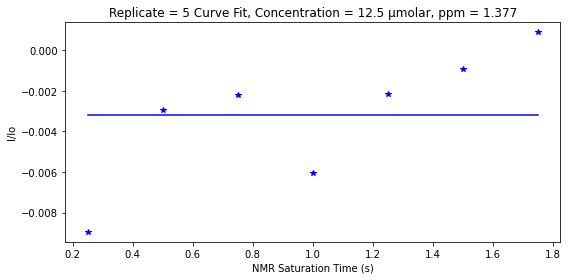

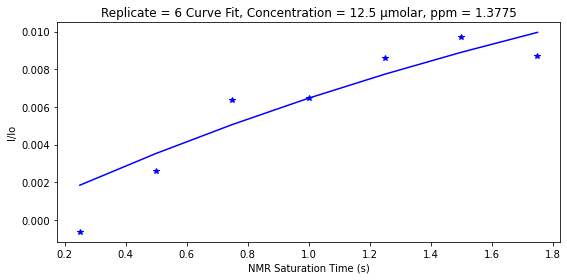

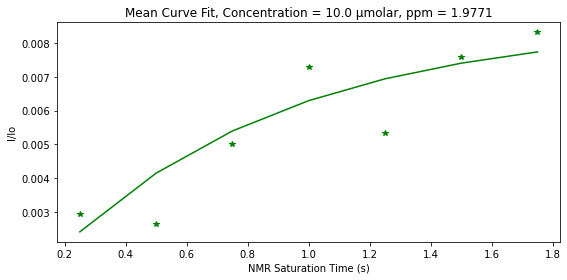

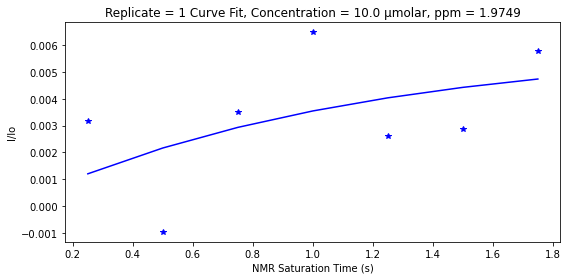

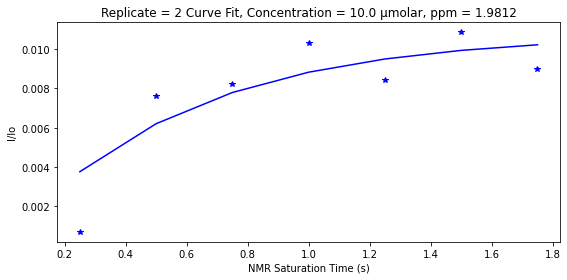

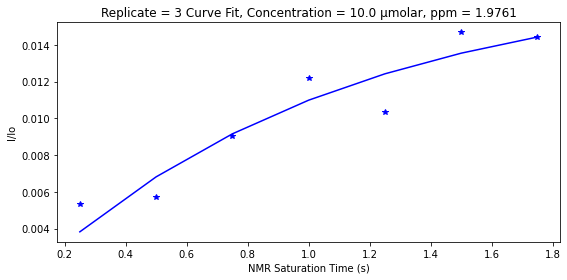

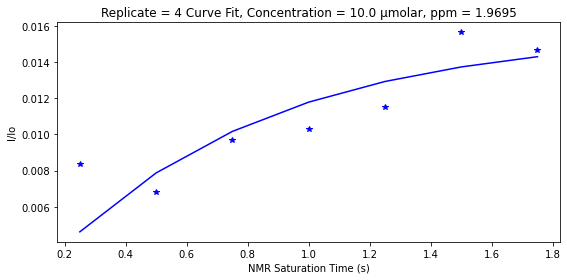

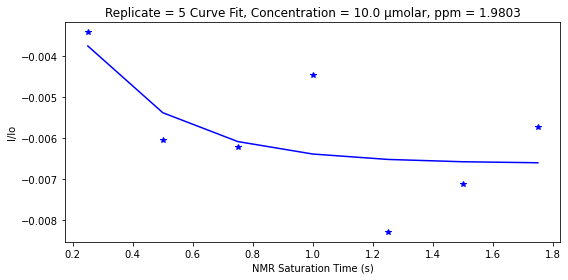

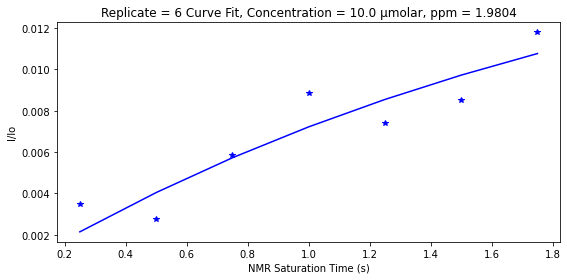

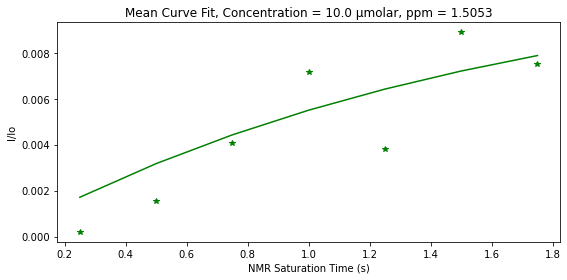

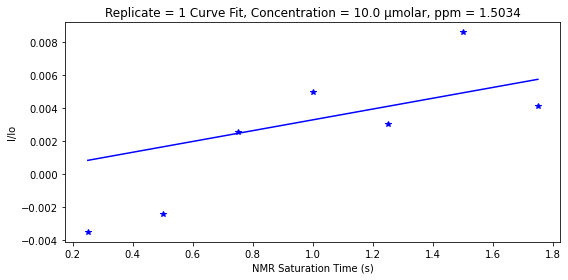

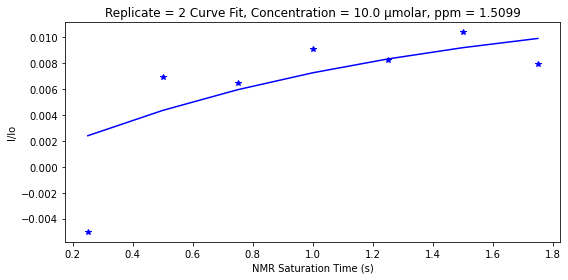

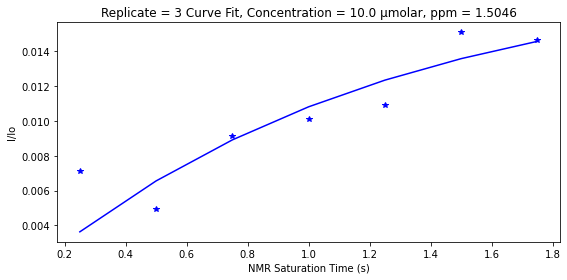

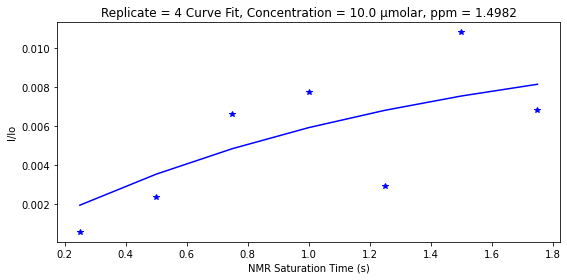

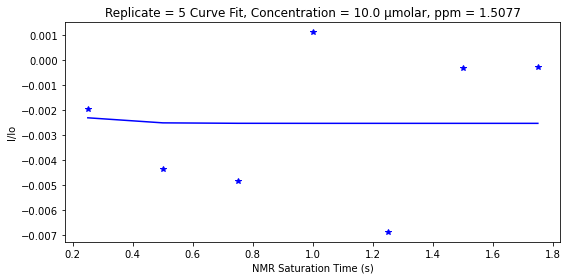

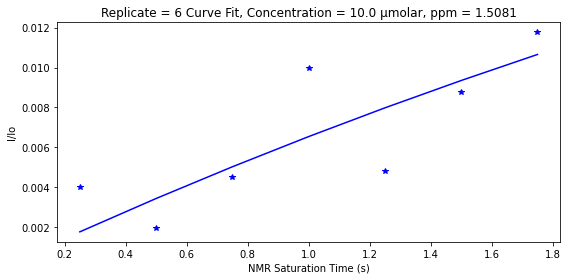

In [355]:
# LOOP THROUGH AND PROCESS EVERY CLEAN DATAFRAME IN THE POLYMER BOOK LIST GENERATED ABOVE, IF ANY ----------------------------------
# custom processing functions default to the "book" path, so no additional parameters passed here

if len(clean_book_tuple_list) != 0: 
    for i in range(len(clean_book_tuple_list)):

        # BEGINNING PART 1 -------- Reading in Data and Visualizing the Results ------------------------ 

        #define current dataframe to be analyzed and its title from the tuple output of the data cleaning code
        current_df = clean_book_tuple_list[i][1]
        current_df_title = clean_book_tuple_list[i][0]

        print("Beginning data analysis for {}...".format(current_df_title))

        # DEFINE GLOBAL CUSTOM OUTPUT DIRECTORIES FOR THIS DATAFRAME ------------------------------------------

        # Define a global custom output directory for the current df in the list
        output_directory = "output_from_{}".format(current_df_title)

        # make global directory if there isn't already one for overall output for current df
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)

        # Define a global output exploratory directory for the exploratory plots 
        output_directory_exploratory = "{}/exploratory_plots_from_{}".format(output_directory, current_df_title)

        # make directory if there isn't already one for exploratory output 
        if not os.path.exists(output_directory_exploratory):
            os.makedirs(output_directory_exploratory)

        # Define a global output directory for the curve fit plots for the current df title
        output_directory2 = "{}/curve_fit_plots_from_{}".format(output_directory, current_df_title)

        # make this directory if there isn't already one for the curve_fit_plots
        if not os.path.exists(output_directory2):
            os.makedirs(output_directory2)  

        # Define a global output directory for the final data tables after curve fitting and stats
        output_directory3 = "{}/data_tables_from_{}".format(output_directory, current_df_title)

        # make this directory if there isn't already one for the data tables
        if not os.path.exists(output_directory3):
            os.makedirs(output_directory3)    

        # CALCULATE ATTENUATION & CORR ATTENUATION -----------------------------------

        current_df_attenuation = add_attenuation_and_corr_attenuation_to_dataframe(current_df)

        # PERFORM EXPLORATORY DATA VISUALIZATION -----------------------------------

        print("Visualizing data for {} and saving to a custom exploratory plots output folder...".format(current_df_title))
        generate_concentration_plot(current_df_attenuation)
        generate_ppm_plot(current_df_attenuation)

        # This completes Part 1 - Data Preprocessing and Visualizing the Results!

        # BEGINNING PART 2 -------- Modelling the Data ---------------------------------------

        # STEP 1 OF 5 - Prepare and generate mean dataframe of current data for stats with degrees of freedom and sample size included -----
        current_df_mean = prep_mean_data_for_stats(current_df_attenuation)
        current_df_replicates = prep_replicate_data_for_stats(current_df_attenuation)

        # STEP 2 OF 5 - Perform t test for statistical significance -------------------------
        current_df_mean = get_t_test_results(current_df_mean, p=0.90)

        # STEP 3 OF 5 - Compute amplification factor -----------------------------------------
        current_df_mean, current_df_replicates = compute_amplification_factor(current_df_mean, current_df_replicates, af_denominator = 10)

        # STEP 4 OF 5 - Drop proton peaks from further analysis that fail our acceptance criteria -----------------------------------------
        current_df_mean, current_df_replicates = drop_bad_peaks(current_df_mean, current_df_replicates)

        # STEP 5 OF 5 - Perform curve fitting, generate plots, and export results to file  -----------------------------------------
        current_df_mean, current_df_replicates = execute_curvefit(current_df_mean, current_df_replicates)
        print("All activities are now completed for: {}".format(current_df_title))

    print("Hooray! All polymers in the input files have been processed.")

Beginning data analysis for CMC ...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for CMC  and saving to a custom exploratory plots output folder...
points being dropped are: MultiIndex([(9, 0.25, 1, 4.5204),
            (9,  0.5, 1, 4.5204),
            (9, 0.75, 1, 4.5204),
            (9,  1.0, 1, 4.5204),
            (9, 1.25, 1, 4.5204),
            (9,  1.5, 1, 4.5204),
            (9, 1.75, 1, 4.5204)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
points being dropped are: MultiIndex([(9, 0.25, 2, 4.3441),
            (9,  0.5, 2, 4.3441),
            (9, 0.75, 2, 4.3441),
            (9,  1.0, 2, 4.3441),
            (9, 1.25, 2, 4.3441),
            (9,  1.5, 2, 4.3441),
            (9, 1.75, 2, 4.3441)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
Removed insignificant points have been prin

index polymer_name  concentration  sat_time  proton_peak_index  \
0        2         CMC               9      0.25                  3   
1        3         CMC               9      0.25                  4   
2        4         CMC               9      0.25                  5   
3        5         CMC               9      0.25                  6   
4        6         CMC               9      0.25                  7   
..     ...          ...            ...       ...                ...   
142    184         CMC               9      1.75                  5   
143    185         CMC               9      1.75                  6   
144    186         CMC               9      1.75                  7   
145    187         CMC               9      1.75                  8   
146    188         CMC               9      1.75                  9   

            ppm_range      ppm  replicate corr_%_attenuation  amp_factor  \
0    4.2992 .. 4.2043  4.25175          1           0.018016         0.9   
1    4.1570 .. 4.0173  4.08715          1          0.0195902         0.9   
2    4.0168 .. 3.8466  3.93170          1         0.00993174         0.9   
3    3.8466 .. 3.6757  3.76115          1          0.0089812         0.9   
4    3.6757 .. 3.5642  3.61995          1          0.0107808         0.9   
..                ...      ...        ...                ...         ...   
142  4.0168 .. 3.8466  3.93170          3          0.0114929         0.9   
143  3.8466 .. 3.6757  3.76115          3         0.00224334         0.9   
144  3.6757 .. 3.5642  3.61995          3         0.00745752         0.9   
145  3.4172 .. 3.2180  3.31760          3          0.0208619         0.9   
146  3.2180 .. 3.0624  3.14020          3          0.0294832         0.9   

           yikj       SSE       AFo  
0     0.0162144  0.000122  0.058567  
1     0.0176312  0.000018  0.078943  
2    0.00893856  0.000006  0.041278  
3    0.00808308  0.000013  0.037176  
4    0.00970273  0.000027  0.043972  
..          ...       ...       ...  
142   0.0103436  0.000051  0.018444  
143    0.002019  0.000077  0.009924  
144  0.00671177  0.000063  0.011917  
145   0.0187757  0.000033  0.050102  
146   0.0265348  0.000175  0.078715  

[147 rows x 13 columns]

corr_%_attenuation            \
                                                               mean       std   
concentration sat_time proton_peak_index ppm                                    
9             0.25     3                 4.25175           0.006380  0.010289   
                       4                 4.08715           0.009683  0.008931   
                       5                 3.93170           0.006400  0.007787   
                       6                 3.76115           0.006146  0.010278   
                       7                 3.61995           0.006976  0.010186   
                       8                 3.31760           0.016235  0.008918   
                       9                 3.14020           0.031608  0.025944   
              0.50     3                 4.25175           0.017699  0.009923   
                       4                 4.08715           0.020142  0.006663   
                       5                 3.93170           0.012584  0.002419   
                       6                 3.76115           0.008530  0.001819   
                       7                 3.61995           0.009683  0.002692   
                       8                 3.31760           0.023337  0.008064   
                       9                 3.14020           0.036688  0.008289   
              0.75     3                 4.25175           0.018142  0.007790   
                       4                 4.08715           0.022434  0.007922   
                       5                 3.93170           0.014702  0.004021   
                       6                 3.76115           0.009375  0.005180   
                       7                 3.61995           0.012508  0.007698   
                       8                 3.31760           0.026966  0.012180   
                       9                 3.14020           0.044240  0.013489   
              1.00     3                 4.25175           0.029724  0.014939   
                       4                 4.08715           0.026827  0.011783   
                       5                 3.93170           0.016172  0.003999   
                       6                 3.76115           0.009669  0.003701   
                       7                 3.61995           0.011718  0.004549   
                       8                 3.31760           0.027548  0.009297   
                       9                 3.14020           0.034367  0.005887   
              1.25     3                 4.25175           0.025824  0.013284   
                       4                 4.08715           0.026469  0.011733   
                       5                 3.93170           0.015852  0.004857   
                       6                 3.76115           0.007508  0.005154   
                       7                 3.61995           0.010684  0.007388   
                       8                 3.31760           0.026000  0.012476   
                       9                 3.14020           0.030190  0.007716   
              1.50     3                 4.25175           0.026614  0.015493   
                       4                 4.08715           0.027748  0.012437   
                       5                 3.93170           0.016548  0.005883   
                       6                 3.76115           0.007466  0.006721   
                       7                 3.61995           0.011448  0.008388   
                       8                 3.31760           0.027901  0.014037   
                       9                 3.14020           0.029923  0.009242   
              1.75     3                 4.25175           0.031073  0.017446   
                       4                 4.08715           0.029783  0.013606   
                       5                 3.93170           0.019319  0.007019   
                       6                 3.76115           0.011226  0.007896   
                       7                 3.61995           0.015129  0.007572   

Export of all figures to file complete!
All activities are now completed for: CMC 
Beginning data analysis for CMC_ours...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for CMC_ours and saving to a custom exploratory plots output folder...
points being dropped are: MultiIndex([(9, 0.25, 1, 4.5204),
            (9,  0.5, 1, 4.5204),
            (9, 0.75, 1, 4.5204),
            (9,  1.0, 1, 4.5204),
            (9, 1.25, 1, 4.5204),
            (9,  1.5, 1, 4.5204),
            (9, 1.75, 1, 4.5204)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
points being dropped are: MultiIndex([(9, 0.25, 2, 4.3441),
            (9,  0.5, 2, 4.3441),
            (9, 0.75, 2, 4.3441),
            (9,  1.0, 2, 4.3441),
            (9, 1.25, 2, 4.3441),
            (9,  1.5, 2, 4.3441),
            (9, 1.75, 2, 4.3441)],
           names=['concentra

Empty DataFrame
Columns: [index, polymer_name, concentration, sat_time, proton_peak_index, ppm_range, ppm, replicate, corr_%_attenuation, amp_factor, yikj]
Index: []

Export of all figures to file complete!
All activities are now completed for: CMC_ours
Beginning data analysis for HEMAcMPC ...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for HEMAcMPC  and saving to a custom exploratory plots output folder...
points being dropped are: MultiIndex([(9, 0.25, 1, 4.3196),
            (9,  0.5, 1, 4.3196),
            (9, 0.75, 1, 4.3196),
            (9,  1.0, 1, 4.3196),
            (9, 1.25, 1, 4.3196),
            (9,  1.5, 1, 4.3196),
            (9, 1.75, 1, 4.3196)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
points being dropped are: MultiIndex([(9, 0.25, 2, 4.079000000000001),
            (9,  0.5, 2, 4.079000000000001),
            (9, 0.75, 2, 4.079000000000001),
            (9,  1.0, 2, 4.079000000000001),
            (9, 1.25, 2, 4.079000000000001),
            (9,  1.5, 2, 4.079000000

index polymer_name  concentration  sat_time  proton_peak_index  \
0       3    HEMAcMPC               9      0.25                  4   
1       4    HEMAcMPC               9      0.25                  5   
2      10    HEMAcMPC               9      0.50                  4   
3      11    HEMAcMPC               9      0.50                  5   
4      17    HEMAcMPC               9      0.75                  4   
5      18    HEMAcMPC               9      0.75                  5   
6      24    HEMAcMPC               9      1.00                  4   
7      25    HEMAcMPC               9      1.00                  5   
8      31    HEMAcMPC               9      1.25                  4   
9      32    HEMAcMPC               9      1.25                  5   
10     38    HEMAcMPC               9      1.50                  4   
11     39    HEMAcMPC               9      1.50                  5   
12     45    HEMAcMPC               9      1.75                  4   
13     46    HEMAcMPC               9      1.75                  5   
14     52    HEMAcMPC               9      0.25                  4   
15     53    HEMAcMPC               9      0.25                  5   
16     59    HEMAcMPC               9      0.50                  4   
17     60    HEMAcMPC               9      0.50                  5   
18     66    HEMAcMPC               9      0.75                  4   
19     67    HEMAcMPC               9      0.75                  5   
20     73    HEMAcMPC               9      1.00                  4   
21     74    HEMAcMPC               9      1.00                  5   
22     80    HEMAcMPC               9      1.25                  4   
23     81    HEMAcMPC               9      1.25                  5   
24     87    HEMAcMPC               9      1.50                  4   
25     88    HEMAcMPC               9      1.50                  5   
26     94    HEMAcMPC               9      1.75                  4   
27     95    HEMAcMPC               9      1.75                  5   
28    101    HEMAcMPC               9      0.25                  4   
29    102    HEMAcMPC               9      0.25                  5   
30    108    HEMAcMPC               9      0.50                  4   
31    109    HEMAcMPC               9      0.50                  5   
32    115    HEMAcMPC               9      0.75                  4   
33    116    HEMAcMPC               9      0.75                  5   
34    122    HEMAcMPC               9      1.00                  4   
35    123    HEMAcMPC               9      1.00                  5   
36    129    HEMAcMPC               9      1.25                  4   
37    130    HEMAcMPC               9      1.25                  5   
38    136    HEMAcMPC               9      1.50                  4   
39    137    HEMAcMPC               9      1.50                  5   
40    143    HEMAcMPC               9      1.75                  4   
41    144    HEMAcMPC               9      1.75                  5   
42    150    HEMAcMPC               9      0.25                  4   
43    151    HEMAcMPC               9      0.25                  5   
44    157    HEMAcMPC               9      0.50                  4   
45    158    HEMAcMPC               9      0.50                  5   
46    164    HEMAcMPC               9      0.75                  4   
47    165    HEMAcMPC               9      0.75                  5   
48    171    HEMAcMPC               9      1.00                  4   
49    172    HEMAcMPC               9      1.00                  5   
50    178    HEMAcMPC               9      1.25                  4   
51    179    HEMAcMPC               9      1.25                  5   
52    185    HEMAcMPC               9      1.50                  4   
53    186    HEMAcMPC               9      1.50                  5   
54    192    HEMAcMPC               9      1.75                  4   
55    193    HEMAcMPC               9      1.75                  5   

           pp

corr_%_attenuation            \
                                                               mean       std   
concentration sat_time proton_peak_index ppm                                    
9             0.25     4                 3.65730           0.000827  0.002994   
                       5                 3.23165           0.000253  0.002470   
              0.50     4                 3.65730           0.002650  0.000543   
                       5                 3.23165           0.002029  0.001342   
              0.75     4                 3.65730           0.002866  0.000956   
                       5                 3.23165           0.002532  0.001317   
              1.00     4                 3.65730           0.003720  0.000906   
                       5                 3.23165           0.002909  0.001360   
              1.25     4                 3.65730           0.003621  0.000956   
                       5                 3.23165           0.003404  0.001678   
              1.50     4                 3.65730           0.002948  0.001011   
                       5                 3.23165           0.003546  0.001653   
              1.75     4                 3.65730           0.004257  0.001651   
                       5                 3.23165           0.003626  0.002179   

                                                 dofs sample_size t_results  \
                                                                              
concentration sat_time proton_peak_index ppm                                  
9             0.25     4                 3.65730    3           4 -0.001625   
                       5                 3.23165    3           4 -0.001769   
              0.50     4                 3.65730    3           4  0.002205   
                       5                 3.23165    3           4  0.000930   
              0.75     4                 3.65730    3           4  0.002083   
                       5                 3.23165    3           4  0.001454   
              1.00     4                 3.65730    3           4  0.002978   
                       5                 3.23165    3           4  0.001795   
              1.25     4                 3.65730    3           4  0.002838   
                       5                 3.23165    3           4  0.002030   
              1.50     4                 3.65730    3           4  0.002119   
                       5                 3.23165    3           4  0.002192   
              1.75     4                 3.65730    3           4  0.002905   
                       5                 3.23165    3           4  0.001842   

                                                 significance amp_factor  \
                                                                           
concentration sat_time proton_peak_index ppm                               
9             0.25     4                 3.65730        False        0.9   
                       5                 3.23165        False        0.9   
              0.50     4                 3.65730         True        0.9   
                       5                 3.23165         True        0.9   
              0.75     4                 3.65730         True        0.9   
                       5                 3.23165         True        0.9   
              1.00     4                 3.65730         True        0.9   
                       5                 3.23165         True        0.9   
              1.25     4                 3.65730         True        0.9   
                       5                 3.23165         True        0.9   
              1.50     4                 3.65730         True        0.9   
                       5                 3.23165         True        0.9   
              1.75     4                 3.65730         True        0.9   
                       5                 3.23165         True        0.9   

                                  

Export of all figures to file complete!
All activities are now completed for: HEMAcMPC 
Beginning data analysis for HPMC E3...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for HPMC E3 and saving to a custom exploratory plots output folder...
points being dropped are: MultiIndex([(9, 0.25, 2, 4.00005),
            (9,  0.5, 2, 4.00005),
            (9, 0.75, 2, 4.00005),
            (9,  1.0, 2, 4.00005),
            (9, 1.25, 2, 4.00005),
            (9,  1.5, 2, 4.00005),
            (9, 1.75, 2, 4.00005)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
points being dropped are: MultiIndex([(9, 0.25, 3, 3.8044000000000002),
            (9,  0.5, 3, 3.8044000000000002),
            (9, 0.75, 3, 3.8044000000000002),
            (9,  1.0, 3, 3.8044000000000002),
            (9, 1.25, 3, 3.8044000000000002),
            (9,  1.5, 3, 3.

index polymer_name  concentration  sat_time  proton_peak_index  \
0        0      HPMC E3              9      0.25                  1   
1        3      HPMC E3              9      0.25                  4   
2        4      HPMC E3              9      0.25                  5   
3        5      HPMC E3              9      0.25                  6   
4        6      HPMC E3              9      0.25                  7   
..     ...          ...            ...       ...                ...   
121    163      HPMC E3              9      1.75                  4   
122    164      HPMC E3              9      1.75                  5   
123    165      HPMC E3              9      1.75                  6   
124    166      HPMC E3              9      1.75                  7   
125    167      HPMC E3              9      1.75                  8   

            ppm_range      ppm  replicate corr_%_attenuation  amp_factor  \
0    4.6053 .. 4.3294  4.46735          1        0.000407507         0.9   
1    3.7087 .. 3.5131  3.61090          1        0.000547763         0.9   
2    3.5131 .. 3.4427  3.47790          1        0.000380352         0.9   
3    3.4427 .. 3.2625  3.35260          1         0.00480681         0.9   
4    3.2006 .. 3.0007  3.10065          1          0.0108489         0.9   
..                ...      ...        ...                ...         ...   
121  3.7087 .. 3.5131  3.61090          3         0.00692619         0.9   
122  3.5131 .. 3.4427  3.47790          3         0.00666131         0.9   
123  3.4427 .. 3.2625  3.35260          3         0.00735999         0.9   
124  3.2006 .. 3.0007  3.10065          3         0.00916347         0.9   
125  1.3243 .. 1.0076  1.16595          3         0.00400692         0.9   

            yikj       SSE       AFo  
0    0.000366756  0.000003  0.002457  
1    0.000492987  0.000002  0.001565  
2    0.000342317  0.000020  0.005059  
3     0.00432613  0.000006  0.376276  
4     0.00976397  0.000021  0.631319  
..           ...       ...       ...  
121   0.00623357  0.000002  0.007387  
122   0.00599518  0.000010  0.007107  
123   0.00662399  0.000005  0.007406  
124   0.00824713  0.000042  0.010852  
125   0.00360623  0.000003  0.002150  

[126 rows x 13 columns]

corr_%_attenuation            \
                                                               mean       std   
concentration sat_time proton_peak_index ppm                                    
9             0.25     1                 4.46735           0.002509  0.002038   
                       4                 3.61090           0.001551  0.000876   
                       5                 3.47790           0.000786  0.000712   
                       6                 3.35260           0.002029  0.002406   
                       7                 3.10065           0.002847  0.006930   
                       8                 1.16595           0.000589  0.001428   
              0.50     1                 4.46735           0.002064  0.001137   
                       4                 3.61090           0.002127  0.001373   
                       5                 3.47790           0.001691  0.000989   
                       6                 3.35260           0.003490  0.000574   
                       7                 3.10065           0.006194  0.003043   
                       8                 1.16595           0.000932  0.000615   
              0.75     1                 4.46735           0.002227  0.001884   
                       4                 3.61090           0.003903  0.002239   
                       5                 3.47790           0.006124  0.000435   
                       6                 3.35260           0.004654  0.001413   
                       7                 3.10065           0.008777  0.001369   
                       8                 1.16595           0.002358  0.001963   
              1.00     1                 4.46735           0.002774  0.001446   
                       4                 3.61090           0.004459  0.001806   
                       5                 3.47790           0.005167  0.001184   
                       6                 3.35260           0.006149  0.001892   
                       7                 3.10065           0.009891  0.002334   
                       8                 1.16595           0.002621  0.000667   
              1.25     1                 4.46735           0.002976  0.001483   
                       4                 3.61090           0.004163  0.002115   
                       5                 3.47790           0.004747  0.004006   
                       6                 3.35260           0.006413  0.001824   
                       7                 3.10065           0.010413  0.004310   
                       8                 1.16595           0.003192  0.001500   
              1.50     1                 4.46735           0.002377  0.001605   
                       4                 3.61090           0.004367  0.002538   
                       5                 3.47790           0.004498  0.001556   
                       6                 3.35260           0.006272  0.001531   
                       7                 3.10065           0.009212  0.001618   
                       8                 1.16595           0.002653  0.001099   
              1.75     1                 4.46735           0.002688  0.001369   
                       4                 3.61090           0.005732  0.001896   
                       5                 3.47790           0.005599  0.000927   
                       6                 3.35260           0.007531  0.000685   
                       7                 3.10065           0.011594  0.002171   
                       8                 1.16595           0.004091  0.001697   

                                                 dofs sample_size t_results  \
                                                                              
concentration sat_time proton_peak_index ppm                                  
9             0.25     1                 4.46735    2           3  0.000290   
                       4                 3.61090    2           3  0.000597   
        

Export of all figures to file complete!
All activities are now completed for: HPMC E3
Beginning data analysis for HPMC E4M...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for HPMC E4M and saving to a custom exploratory plots output folder...
points being dropped are: MultiIndex([(9, 0.25, 1, 4.4822500000000005),
            (9,  0.5, 1, 4.4822500000000005),
            (9, 0.75, 1, 4.4822500000000005),
            (9,  1.0, 1, 4.4822500000000005),
            (9, 1.25, 1, 4.4822500000000005),
            (9,  1.5, 1, 4.4822500000000005),
            (9, 1.75, 1, 4.4822500000000005)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
points being dropped are: MultiIndex([(9, 0.25, 2, 4.04905),
            (9,  0.5, 2, 4.04905),
            (9, 0.75, 2, 4.04905),
            (9,  1.0, 2, 4.04905),
            (9, 1.25, 2, 4.04905),
     

Empty DataFrame
Columns: [index, polymer_name, concentration, sat_time, proton_peak_index, ppm_range, ppm, replicate, corr_%_attenuation, amp_factor, yikj]
Index: []

Export of all figures to file complete!
All activities are now completed for: HPMC E4M
Beginning data analysis for PDMA ...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for PDMA  and saving to a custom exploratory plots output folder...
points being dropped are: MultiIndex([(9, 0.25, 1, 2.98975),
            (9,  0.5, 1, 2.98975),
            (9, 0.75, 1, 2.98975),
            (9,  1.0, 1, 2.98975),
            (9, 1.25, 1, 2.98975),
            (9,  1.5, 1, 2.98975),
            (9, 1.75, 1, 2.98975)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
points being dropped are: MultiIndex([(9, 0.25, 2, 2.5583),
            (9,  0.5, 2, 2.5583),
            (9, 0.75, 2, 2.5583),
            (9,  1.0, 2, 2.5583),
            (9, 1.25, 2, 2.5583),
            (9,  1.5, 2, 2.5583),
            (9, 1.75, 2, 2.5583)],
           names=['conc

Empty DataFrame
Columns: [index, polymer_name, concentration, sat_time, proton_peak_index, ppm_range, ppm, replicate, corr_%_attenuation, amp_factor, yikj]
Index: []

Export of all figures to file complete!
All activities are now completed for: PDMA 
Beginning data analysis for PDMAcd ...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for PDMAcd  and saving to a custom exploratory plots output folder...
points being dropped are: MultiIndex([(9, 0.25, 1, 3.0689),
            (9,  0.5, 1, 3.0689),
            (9, 0.75, 1, 3.0689),
            (9,  1.0, 1, 3.0689),
            (9, 1.25, 1, 3.0689),
            (9,  1.5, 1, 3.0689),
            (9, 1.75, 1, 3.0689)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
points being dropped are: MultiIndex([(9, 0.25, 2, 2.5901),
            (9,  0.5, 2, 2.5901),
            (9, 0.75, 2, 2.5901),
            (9,  1.0, 2, 2.5901),
            (9, 1.25, 2, 2.5901),
            (9,  1.5, 2, 2.5901),
            (9, 1.75, 2, 2.5901)],
           names=['concentrat

Empty DataFrame
Columns: [index, polymer_name, concentration, sat_time, proton_peak_index, ppm_range, ppm, replicate, corr_%_attenuation, amp_factor, yikj]
Index: []

Export of all figures to file complete!
All activities are now completed for: PDMAcd 
Beginning data analysis for PEGHCO...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for PEGHCO and saving to a custom exploratory plots output folder...
points being dropped are: MultiIndex([(9, 0.25, 1, 5.40305),
            (9,  0.5, 1, 5.40305),
            (9, 0.75, 1, 5.40305),
            (9,  1.0, 1, 5.40305),
            (9, 1.25, 1, 5.40305),
            (9,  1.5, 1, 5.40305),
            (9, 1.75, 1, 5.40305)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
points being dropped are: MultiIndex([(9, 0.25, 2, 4.202450000000001),
            (9,  0.5, 2, 4.202450000000001),
            (9, 0.75, 2, 4.202450000000001),
            (9,  1.0, 2, 4.202450000000001),
            (9, 1.25, 2, 4.202450000000001),
            (9,  1.5, 2, 4.202450000

Empty DataFrame
Columns: [index, polymer_name, concentration, sat_time, proton_peak_index, ppm_range, ppm, replicate, corr_%_attenuation, amp_factor, yikj]
Index: []

Export of all figures to file complete!
All activities are now completed for: PEGHCO
Beginning data analysis for PTA ...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for PTA  and saving to a custom exploratory plots output folder...
points being dropped are: MultiIndex([(9, 0.25, 1, 3.56415),
            (9,  0.5, 1, 3.56415),
            (9, 0.75, 1, 3.56415),
            (9,  1.0, 1, 3.56415),
            (9, 1.25, 1, 3.56415),
            (9,  1.5, 1, 3.56415),
            (9, 1.75, 1, 3.56415)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
points being dropped are: MultiIndex([(9, 0.25, 3, 2.17955),
            (9,  0.5, 3, 2.17955),
            (9, 0.75, 3, 2.17955),
            (9,  1.0, 3, 2.17955),
            (9, 1.25, 3, 2.17955),
            (9,  1.5, 3, 2.17955),
            (9, 1.75, 3, 2.17955)],
           names=['c

index polymer_name  concentration  sat_time  proton_peak_index  \
0       1         PTA               9      0.25                  2   
1       6         PTA               9      0.50                  2   
2      11         PTA               9      0.75                  2   
3      16         PTA               9      1.00                  2   
4      21         PTA               9      1.25                  2   
5      26         PTA               9      1.50                  2   
6      31         PTA               9      1.75                  2   
7      36         PTA               9      0.25                  2   
8      41         PTA               9      0.50                  2   
9      46         PTA               9      0.75                  2   
10     51         PTA               9      1.00                  2   
11     56         PTA               9      1.25                  2   
12     61         PTA               9      1.50                  2   
13     66         PTA               9      1.75                  2   
14     71         PTA               9      0.25                  2   
15     76         PTA               9      0.50                  2   
16     81         PTA               9      0.75                  2   
17     86         PTA               9      1.00                  2   
18     91         PTA               9      1.25                  2   
19     96         PTA               9      1.50                  2   
20    101         PTA               9      1.75                  2   

           ppm_range      ppm  replicate corr_%_attenuation  amp_factor  \
0   3.2687 .. 2.9718  3.12025          1         0.00282575         0.9   
1   3.2687 .. 2.9718  3.12025          1         0.00167831         0.9   
2   3.2687 .. 2.9718  3.12025          1         0.00171239         0.9   
3   3.2687 .. 2.9718  3.12025          1         0.00496732         0.9   
4   3.2687 .. 2.9718  3.12025          1         0.00251795         0.9   
5   3.2687 .. 2.9718  3.12025          1         0.00452305         0.9   
6   3.2687 .. 2.9718  3.12025          1         0.00550309         0.9   
7   3.2687 .. 2.9718  3.12025          2       -0.000746884         0.9   
8   3.2687 .. 2.9718  3.12025          2       -0.000276014         0.9   
9   3.2687 .. 2.9718  3.12025          2         0.00190125         0.9   
10  3.2687 .. 2.9718  3.12025          2        0.000528821         0.9   
11  3.2687 .. 2.9718  3.12025          2         0.00467975         0.9   
12  3.2687 .. 2.9718  3.12025          2         0.00484796         0.9   
13  3.2687 .. 2.9718  3.12025          2         0.00134504         0.9   
14  3.2687 .. 2.9718  3.12025          3         0.00198971         0.9   
15  3.2687 .. 2.9718  3.12025          3         0.00246446         0.9   
16  3.2687 .. 2.9718  3.12025          3         0.00482789         0.9   
17  3.2687 .. 2.9718  3.12025          3         0.00428515         0.9   
18  3.2687 .. 2.9718  3.12025          3         0.00644462         0.9   
19  3.2687 .. 2.9718  3.12025          3         0.00860674         0.9   
20  3.2687 .. 2.9718  3.12025          3         0.00643951         0.9   

           yikj       SSE       AFo  
0    0.00254317  0.000007  0.004248  
1    0.00151047  0.000007  0.004248  
2    0.00154116  0.000007  0.004248  
3    0.00447059  0.000007  0.004248  
4    0.00226615  0.000007  0.004248  
5    0.00407074  0.000007  0.004248  
6    0.00495278  0.000007  0.004248  
7  -0.000672195  0.000015  0.001838  
8  -0.000248412  0.000015  0.001838  
9    0.00171113  0.000015  0.001838  
10  0.000475939  0.000015  0.001838  
11   0.00421177  0.000015  0.001838  
12   0.00436316  0.000015  0.001838  
13   0.00121053  0.000015  0.001838  
14   0.00179074  0.000005  0.006506  
15   0.00221802  0.000005  0.006506  
16    0.0043451  0.000005  0.006506  
17   0.00385664  0.000005  0.006506  
18   0.00580016  0.000005  0.006506  
19   0.00774607  0.000005  0.006506  
20   0.0057955

corr_%_attenuation            \
                                                               mean       std   
concentration sat_time proton_peak_index ppm                                    
9             0.25     2                 3.12025           0.001356  0.001869   
              0.50     2                 3.12025           0.001289  0.001411   
              0.75     2                 3.12025           0.002814  0.001747   
              1.00     2                 3.12025           0.003260  0.002390   
              1.25     2                 3.12025           0.004547  0.001967   
              1.50     2                 3.12025           0.005993  0.002270   
              1.75     2                 3.12025           0.004429  0.002712   

                                                 dofs sample_size t_results  \
                                                                              
concentration sat_time proton_peak_index ppm                                  
9             0.25     2                 3.12025    2           3 -0.000678   
              0.50     2                 3.12025    2           3 -0.000247   
              0.75     2                 3.12025    2           3  0.000912   
              1.00     2                 3.12025    2           3  0.000658   
              1.25     2                 3.12025    2           3  0.002406   
              1.50     2                 3.12025    2           3  0.003522   
              1.75     2                 3.12025    2           3  0.001477   

                                                 significance amp_factor  \
                                                                           
concentration sat_time proton_peak_index ppm                               
9             0.25     2                 3.12025        False        0.9   
              0.50     2                 3.12025        False        0.9   
              0.75     2                 3.12025         True        0.9   
              1.00     2                 3.12025         True        0.9   
              1.25     2                 3.12025         True        0.9   
              1.50     2                 3.12025         True        0.9   
              1.75     2                 3.12025         True        0.9   

                                                  yikj_bar   SSE_bar   AFo_bar  
                                                                                
concentration sat_time proton_peak_index ppm                                    
9             0.25     2                 3.12025  0.001221  0.000002  0.004533  
              0.50     2                 3.12025  0.001160  0.000002  0.004533  
              0.75     2                 3.12025  0.002532  0.000002  0.004533  
              1.00     2                 3.12025  0.002934  0.000002  0.004533  
              1.25     2                 3.12025  0.004093  0.000002  0.004533  
              1.50     2                 3.12025  0.005393  0.000002  0.004533  
              1.75     2                 3.12025  0.003986  0.000002  0.004533

Export of all figures to file complete!
All activities are now completed for: PTA 
Beginning data analysis for pDMAMPC5050 ...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for pDMAMPC5050  and saving to a custom exploratory plots output folder...
points being dropped are: MultiIndex([(9, 0.25, 1, 4.3633500000000005),
            (9,  0.5, 1, 4.3633500000000005),
            (9, 0.75, 1, 4.3633500000000005),
            (9,  1.0, 1, 4.3633500000000005),
            (9, 1.25, 1, 4.3633500000000005),
            (9,  1.5, 1, 4.3633500000000005),
            (9, 1.75, 1, 4.3633500000000005)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
points being dropped are: MultiIndex([(9, 0.25, 2, 4.0211500000000004),
            (9,  0.5, 2, 4.0211500000000004),
            (9, 0.75, 2, 4.0211500000000004),
            (9,  1.0, 2, 4.0211500000

Empty DataFrame
Columns: [index, polymer_name, concentration, sat_time, proton_peak_index, ppm_range, ppm, replicate, corr_%_attenuation, amp_factor, yikj]
Index: []

Export of all figures to file complete!
All activities are now completed for: pDMAMPC5050 
Beginning data analysis for pDMASBT ...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for pDMASBT  and saving to a custom exploratory plots output folder...
points being dropped are: MultiIndex([(9, 0.25, 1, 3.56205),
            (9,  0.5, 1, 3.56205),
            (9, 0.75, 1, 3.56205),
            (9,  1.0, 1, 3.56205),
            (9, 1.25, 1, 3.56205),
            (9,  1.5, 1, 3.56205),
            (9, 1.75, 1, 3.56205)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
Removed insignificant points have been printed to the output folder for pDMASBT .
Exporting all mean and individual curve fit figures to an output directory... this may take a moment.


index polymer_name  concentration  sat_time  proton_peak_index  \
0        1     pDMASBT               9      0.25                  2   
1        2     pDMASBT               9      0.25                  3   
2        3     pDMASBT               9      0.25                  4   
3        4     pDMASBT               9      0.25                  5   
4        5     pDMASBT               9      0.25                  6   
..     ...          ...            ...       ...                ...   
121    142     pDMASBT               9      1.75                  3   
122    143     pDMASBT               9      1.75                  4   
123    144     pDMASBT               9      1.75                  5   
124    145     pDMASBT               9      1.75                  6   
125    146     pDMASBT               9      1.75                  7   

            ppm_range      ppm  replicate corr_%_attenuation  amp_factor  \
0    3.4344 .. 3.2943  3.36435          1         0.00274843         0.9   
1    3.2871 .. 3.0574  3.17225          1         0.00271025         0.9   
2    3.0574 .. 2.8012  2.92930          1         0.00102756         0.9   
3    2.7964 .. 2.3711  2.58375          1       -0.000260035         0.9   
4    2.3650 .. 1.8528  2.10890          1         0.00180023         0.9   
..                ...      ...        ...                ...         ...   
121  3.2871 .. 3.0574  3.17225          3        0.000165181         0.9   
122  3.0574 .. 2.8012  2.92930          3          0.0027183         0.9   
123  2.7964 .. 2.3711  2.58375          3         0.00783035         0.9   
124  2.3650 .. 1.8528  2.10890          3           0.013373         0.9   
125  1.8384 .. 1.2015  1.51995          3         0.00308581         0.9   

            yikj           SSE       AFo  
0     0.00247359  1.893242e-06  0.038222  
1     0.00243923  1.973114e-06  0.179169  
2    0.000924802  4.231342e-07  0.004526  
3   -0.000234031  1.311330e-05  0.008517  
4     0.00162021  1.227628e-06  0.008595  
..           ...           ...       ...  
121  0.000148663  5.392430e-06  0.000803  
122   0.00244647  7.733571e-07  0.002523  
123   0.00704731  2.976705e-05  0.014610  
124    0.0120357  1.042129e-06  0.008704  
125   0.00277723  5.380477e-06  0.004254  

[126 rows x 13 columns]

corr_%_attenuation            \
                                                               mean       std   
concentration sat_time proton_peak_index ppm                                    
9             0.25     2                 3.36435           0.002013  0.000651   
                       3                 3.17225           0.001171  0.001351   
                       4                 2.92930           0.000498  0.000486   
                       5                 2.58375           0.000994  0.001119   
                       6                 2.10890           0.001829  0.000227   
                       7                 1.51995           0.000014  0.000248   
              0.50     2                 3.36435           0.000199  0.002185   
                       3                 3.17225          -0.000035  0.001401   
                       4                 2.92930           0.001909  0.000734   
                       5                 2.58375           0.006089  0.001109   
                       6                 2.10890           0.004767  0.000629   
                       7                 1.51995           0.002957  0.000602   
              0.75     2                 3.36435           0.002062  0.001693   
                       3                 3.17225           0.001686  0.000822   
                       4                 2.92930           0.002150  0.000690   
                       5                 2.58375           0.003358  0.001866   
                       6                 2.10890           0.006103  0.000574   
                       7                 1.51995           0.001709  0.001085   
              1.00     2                 3.36435           0.002623  0.001020   
                       3                 3.17225           0.001781  0.000395   
                       4                 2.92930           0.002609  0.000779   
                       5                 2.58375           0.004519  0.002546   
                       6                 2.10890           0.008333  0.000548   
                       7                 1.51995           0.003085  0.001584   
              1.25     2                 3.36435           0.002698  0.002237   
                       3                 3.17225           0.001963  0.000544   
                       4                 2.92930           0.002755  0.001423   
                       5                 2.58375           0.002597  0.003461   
                       6                 2.10890           0.009215  0.001246   
                       7                 1.51995           0.001967  0.001522   
              1.50     2                 3.36435           0.002817  0.001609   
                       3                 3.17225           0.001847  0.001546   
                       4                 2.92930           0.003322  0.001455   
                       5                 2.58375           0.004425  0.001049   
                       6                 2.10890           0.011099  0.000476   
                       7                 1.51995           0.003217  0.000681   
              1.75     2                 3.36435           0.001588  0.002322   
                       3                 3.17225           0.001769  0.001391   
                       4                 2.92930           0.003913  0.001420   
                       5                 2.58375           0.007691  0.001504   
                       6                 2.10890           0.013269  0.000735   
                       7                 1.51995           0.003860  0.001128   

                                                 dofs sample_size t_results  \
                                                                              
concentration sat_time proton_peak_index ppm                                  
9             0.25     2                 3.36435    2           3  0.001304   
                       3                 3.17225    2           3 -0.000299   
        

Export of all figures to file complete!
All activities are now completed for: pDMASBT 
Beginning data analysis for pHEMAMPC2080 ...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for pHEMAMPC2080  and saving to a custom exploratory plots output folder...
points being dropped are: MultiIndex([(9, 0.25, 1, 4.3196),
            (9,  0.5, 1, 4.3196),
            (9, 0.75, 1, 4.3196),
            (9,  1.0, 1, 4.3196),
            (9, 1.25, 1, 4.3196),
            (9,  1.5, 1, 4.3196),
            (9, 1.75, 1, 4.3196)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
points being dropped are: MultiIndex([(9, 0.25, 2, 4.079000000000001),
            (9,  0.5, 2, 4.079000000000001),
            (9, 0.75, 2, 4.079000000000001),
            (9,  1.0, 2, 4.079000000000001),
            (9, 1.25, 2, 4.079000000000001),
            (9,  1.5, 2, 4.0

index   polymer_name  concentration  sat_time  proton_peak_index  \
0       2  pHEMAMPC2080               9      0.25                  3   
1       3  pHEMAMPC2080               9      0.25                  4   
2       9  pHEMAMPC2080               9      0.50                  3   
3      10  pHEMAMPC2080               9      0.50                  4   
4      16  pHEMAMPC2080               9      0.75                  3   
5      17  pHEMAMPC2080               9      0.75                  4   
6      23  pHEMAMPC2080               9      1.00                  3   
7      24  pHEMAMPC2080               9      1.00                  4   
8      30  pHEMAMPC2080               9      1.25                  3   
9      31  pHEMAMPC2080               9      1.25                  4   
10     37  pHEMAMPC2080               9      1.50                  3   
11     38  pHEMAMPC2080               9      1.50                  4   
12     44  pHEMAMPC2080               9      1.75                  3   
13     45  pHEMAMPC2080               9      1.75                  4   
14     51  pHEMAMPC2080               9      0.25                  3   
15     52  pHEMAMPC2080               9      0.25                  4   
16     58  pHEMAMPC2080               9      0.50                  3   
17     59  pHEMAMPC2080               9      0.50                  4   
18     65  pHEMAMPC2080               9      0.75                  3   
19     66  pHEMAMPC2080               9      0.75                  4   
20     72  pHEMAMPC2080               9      1.00                  3   
21     73  pHEMAMPC2080               9      1.00                  4   
22     79  pHEMAMPC2080               9      1.25                  3   
23     80  pHEMAMPC2080               9      1.25                  4   
24     86  pHEMAMPC2080               9      1.50                  3   
25     87  pHEMAMPC2080               9      1.50                  4   
26     93  pHEMAMPC2080               9      1.75                  3   
27     94  pHEMAMPC2080               9      1.75                  4   
28    100  pHEMAMPC2080               9      0.25                  3   
29    101  pHEMAMPC2080               9      0.25                  4   
30    107  pHEMAMPC2080               9      0.50                  3   
31    108  pHEMAMPC2080               9      0.50                  4   
32    114  pHEMAMPC2080               9      0.75                  3   
33    115  pHEMAMPC2080               9      0.75                  4   
34    121  pHEMAMPC2080               9      1.00                  3   
35    122  pHEMAMPC2080               9      1.00                  4   
36    128  pHEMAMPC2080               9      1.25                  3   
37    129  pHEMAMPC2080               9      1.25                  4   
38    135  pHEMAMPC2080               9      1.50                  3   
39    136  pHEMAMPC2080               9      1.50                  4   
40    142  pHEMAMPC2080               9      1.75                  3   
41    143  pHEMAMPC2080               9      1.75                  4   

           ppm_range      ppm  replicate corr_%_attenuation  amp_factor  \
0   3.9623 .. 3.7434  3.85285          1          -0.050288         0.9   
1   3.7434 .. 3.5712  3.65730          1          0.0216474         0.9   
2   3.9623 .. 3.7434  3.85285          1          0.0050376         0.9   
3   3.7434 .. 3.5712  3.65730          1         0.00171234         0.9   
4   3.9623 .. 3.7434  3.85285          1         0.00644637         0.9   
5   3.7434 .. 3.5712  3.65730          1         0.00332498         0.9   
6   3.9623 .. 3.7434  3.85285          1          0.0079071         0.9   
7   3.7434 .. 3.5712  3.65730          1         0.00401961         0.9   
8   3.9623 .. 3.7434  3.85285          1         0.00911101         0.9   
9   3.7434 .. 3.5712  3.65730          1          0.0034194         0.9   
10  3.9623 .. 3.7434  3.85285          1         0.00839367         0.9   
11  3.7

corr_%_attenuation            \
                                                               mean       std   
concentration sat_time proton_peak_index ppm                                    
9             0.25     3                 3.85285          -0.015548  0.030127   
                       4                 3.65730           0.007932  0.011878   
              0.50     3                 3.85285           0.003353  0.002041   
                       4                 3.65730           0.001074  0.000596   
              0.75     3                 3.85285           0.004397  0.002677   
                       4                 3.65730           0.002135  0.001856   
              1.00     3                 3.85285           0.005606  0.002688   
                       4                 3.65730           0.002423  0.001704   
              1.25     3                 3.85285           0.006316  0.003614   
                       4                 3.65730           0.002613  0.000970   
              1.50     3                 3.85285           0.007151  0.002759   
                       4                 3.65730           0.001991  0.000723   
              1.75     3                 3.85285           0.007433  0.001983   
                       4                 3.65730           0.002462  0.000700   

                                                 dofs sample_size t_results  \
                                                                              
concentration sat_time proton_peak_index ppm                                  
9             0.25     3                 3.85285    2           3 -0.017251   
                       4                 3.65730    2           3 -0.005000   
              0.50     3                 3.85285    2           3  0.001131   
                       4                 3.65730    2           3  0.000426   
              0.75     3                 3.85285    2           3  0.001483   
                       4                 3.65730    2           3  0.000114   
              1.00     3                 3.85285    2           3  0.002680   
                       4                 3.65730    2           3  0.000568   
              1.25     3                 3.85285    2           3  0.002382   
                       4                 3.65730    2           3  0.001557   
              1.50     3                 3.85285    2           3  0.004148   
                       4                 3.65730    2           3  0.001204   
              1.75     3                 3.85285    2           3  0.005274   
                       4                 3.65730    2           3  0.001700   

                                                 significance amp_factor  \
                                                                           
concentration sat_time proton_peak_index ppm                               
9             0.25     3                 3.85285        False        0.9   
                       4                 3.65730        False        0.9   
              0.50     3                 3.85285         True        0.9   
                       4                 3.65730         True        0.9   
              0.75     3                 3.85285         True        0.9   
                       4                 3.65730         True        0.9   
              1.00     3                 3.85285         True        0.9   
                       4                 3.65730         True        0.9   
              1.25     3                 3.85285         True        0.9   
                       4                 3.65730         True        0.9   
              1.50     3                 3.85285         True        0.9   
                       4                 3.65730         True        0.9   
              1.75     3                 3.85285         True        0.9   
                       4                 3.65730         True        0.9   

                                  

Export of all figures to file complete!
All activities are now completed for: pHEMAMPC2080 
Beginning data analysis for pHEMAMPC8020 ...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for pHEMAMPC8020  and saving to a custom exploratory plots output folder...
points being dropped are: MultiIndex([(9, 0.25, 1, 4.3196),
            (9,  0.5, 1, 4.3196),
            (9, 0.75, 1, 4.3196),
            (9,  1.0, 1, 4.3196),
            (9, 1.25, 1, 4.3196),
            (9,  1.5, 1, 4.3196),
            (9, 1.75, 1, 4.3196)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
points being dropped are: MultiIndex([(9, 0.25, 2, 4.079000000000001),
            (9,  0.5, 2, 4.079000000000001),
            (9, 0.75, 2, 4.079000000000001),
            (9,  1.0, 2, 4.079000000000001),
            (9, 1.25, 2, 4.079000000000001),
            (9,  1.5, 2

index   polymer_name  concentration  sat_time  proton_peak_index  \
0       5  pHEMAMPC8020               9      0.25                  6   
1      12  pHEMAMPC8020               9      0.50                  6   
2      19  pHEMAMPC8020               9      0.75                  6   
3      26  pHEMAMPC8020               9      1.00                  6   
4      33  pHEMAMPC8020               9      1.25                  6   
5      40  pHEMAMPC8020               9      1.50                  6   
6      47  pHEMAMPC8020               9      1.75                  6   
7      54  pHEMAMPC8020               9      0.25                  6   
8      61  pHEMAMPC8020               9      0.50                  6   
9      68  pHEMAMPC8020               9      0.75                  6   
10     75  pHEMAMPC8020               9      1.00                  6   
11     82  pHEMAMPC8020               9      1.25                  6   
12     89  pHEMAMPC8020               9      1.50                  6   
13     96  pHEMAMPC8020               9      1.75                  6   
14    103  pHEMAMPC8020               9      0.25                  6   
15    110  pHEMAMPC8020               9      0.50                  6   
16    117  pHEMAMPC8020               9      0.75                  6   
17    124  pHEMAMPC8020               9      1.00                  6   
18    131  pHEMAMPC8020               9      1.25                  6   
19    138  pHEMAMPC8020               9      1.50                  6   
20    145  pHEMAMPC8020               9      1.75                  6   

           ppm_range      ppm  replicate corr_%_attenuation  amp_factor  \
0   1.1990 .. 1.0027  1.10085          1        -0.00653669         0.9   
1   1.1990 .. 1.0027  1.10085          1         -0.0185994         0.9   
2   1.1990 .. 1.0027  1.10085          1         -0.0193983         0.9   
3   1.1990 .. 1.0027  1.10085          1          -0.020296         0.9   
4   1.1990 .. 1.0027  1.10085          1         -0.0152677         0.9   
5   1.1990 .. 1.0027  1.10085          1         -0.0110082         0.9   
6   1.1990 .. 1.0027  1.10085          1         -0.0165864         0.9   
7   1.1990 .. 1.0027  1.10085          2        -0.00332112         0.9   
8   1.1990 .. 1.0027  1.10085          2          -0.005585         0.9   
9   1.1990 .. 1.0027  1.10085          2         -0.0141548         0.9   
10  1.1990 .. 1.0027  1.10085          2         -0.0126381         0.9   
11  1.1990 .. 1.0027  1.10085          2        -0.00948899         0.9   
12  1.1990 .. 1.0027  1.10085          2        -0.00612601         0.9   
13  1.1990 .. 1.0027  1.10085          2         -0.0104097         0.9   
14  1.1990 .. 1.0027  1.10085          3        -0.00532442         0.9   
15  1.1990 .. 1.0027  1.10085          3        -0.00403551         0.9   
16  1.1990 .. 1.0027  1.10085          3         -0.0111802         0.9   
17  1.1990 .. 1.0027  1.10085          3         -0.0117778         0.9   
18  1.1990 .. 1.0027  1.10085          3       -0.000772183         0.9   
19  1.1990 .. 1.0027  1.10085          3         0.00195027         0.9   
20  1.1990 .. 1.0027  1.10085          3        -0.00414634         0.9   

           yikj       SSE       AFo  
0   -0.00588302  0.000077 -0.062982  
1    -0.0167394  0.000077 -0.062982  
2    -0.0174584  0.000077 -0.062982  
3    -0.0182664  0.000077 -0.062982  
4    -0.0137409  0.000077 -0.062982  
5   -0.00990737  0.000077 -0.062982  
6    -0.0149278  0.000077 -0.062982  
7   -0.00298901  0.000048 -0.026452  
8    -0.0050265  0.000048 -0.026452  
9    -0.0127393  0.000048 -0.026452  
10   -0.0113743  0.000048 -0.026452  
11  -0.00854009  0.000048 -0.026452  
12  -0.00551341  0.000048 -0.026452  
13  -0.00936872  0.000048 -0.026452  
14  -0.00479198  0.000123 -0.293126  
15  -0.00363196  0.000123 -0.293126  
16   -0.0100622  0.000123 -0.293126  
17   -0.0106001  0.000123 -0.293126  
18 -0.000694965  0.000123 -0.293126  
19   0.0

corr_%_attenuation            \
                                                               mean       std   
concentration sat_time proton_peak_index ppm                                    
9             0.25     6                 1.10085          -0.005061  0.001624   
              0.50     6                 1.10085          -0.009407  0.007999   
              0.75     6                 1.10085          -0.014911  0.004161   
              1.00     6                 1.10085          -0.014904  0.004689   
              1.25     6                 1.10085          -0.008510  0.007297   
              1.50     6                 1.10085          -0.005061  0.006545   
              1.75     6                 1.10085          -0.010381  0.006220   

                                                 dofs sample_size t_results  \
                                                                              
concentration sat_time proton_peak_index ppm                                  
9             0.25     6                 1.10085    2           3  0.003293   
              0.50     6                 1.10085    2           3  0.000699   
              0.75     6                 1.10085    2           3  0.010381   
              1.00     6                 1.10085    2           3  0.009799   
              1.25     6                 1.10085    2           3  0.000565   
              1.50     6                 1.10085    2           3 -0.002063   
              1.75     6                 1.10085    2           3  0.003609   

                                                 significance amp_factor  \
                                                                           
concentration sat_time proton_peak_index ppm                               
9             0.25     6                 1.10085         True        0.9   
              0.50     6                 1.10085         True        0.9   
              0.75     6                 1.10085         True        0.9   
              1.00     6                 1.10085         True        0.9   
              1.25     6                 1.10085         True        0.9   
              1.50     6                 1.10085        False        0.9   
              1.75     6                 1.10085         True        0.9   

                                                  yikj_bar   SSE_bar   AFo_bar  
                                                                                
concentration sat_time proton_peak_index ppm                                    
9             0.25     6                 1.10085 -0.004555  0.000035 -0.037496  
              0.50     6                 1.10085 -0.008466  0.000035 -0.037496  
              0.75     6                 1.10085 -0.013420  0.000035 -0.037496  
              1.00     6                 1.10085 -0.013414  0.000035 -0.037496  
              1.25     6                 1.10085 -0.007659  0.000035 -0.037496  
              1.50     6                 1.10085 -0.004555  0.000035 -0.037496  
              1.75     6                 1.10085 -0.009343  0.000035 -0.037496

Export of all figures to file complete!
All activities are now completed for: pHEMAMPC8020 
Beginning data analysis for pHEMASBT5050 ...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for pHEMASBT5050  and saving to a custom exploratory plots output folder...
points being dropped are: MultiIndex([(9, 0.25, 1, 4.14335),
            (9,  0.5, 1, 4.14335),
            (9, 0.75, 1, 4.14335),
            (9,  1.0, 1, 4.14335),
            (9, 1.25, 1, 4.14335),
            (9,  1.5, 1, 4.14335),
            (9, 1.75, 1, 4.14335)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
Removed insignificant points have been printed to the output folder for pHEMASBT5050 .
Exporting all mean and individual curve fit figures to an output directory... this may take a moment.


index   polymer_name  concentration  sat_time  proton_peak_index  \
0        1  pHEMASBT5050               9      0.25                  2   
1        2  pHEMASBT5050               9      0.25                  3   
2        3  pHEMASBT5050               9      0.25                  4   
3        4  pHEMASBT5050               9      0.25                  5   
4        5  pHEMASBT5050               9      0.25                  6   
..     ...            ...            ...       ...                ...   
163    184  pHEMASBT5050               9      1.75                  5   
164    185  pHEMASBT5050               9      1.75                  6   
165    186  pHEMASBT5050               9      1.75                  7   
166    187  pHEMASBT5050               9      1.75                  8   
167    188  pHEMASBT5050               9      1.75                  9   

            ppm_range      ppm  replicate corr_%_attenuation  amp_factor  \
0    3.9385 .. 3.6891  3.81380          1          0.0035908         0.9   
1    3.5857 .. 3.4344  3.51005          1         0.00115635         0.9   
2    3.4344 .. 3.2943  3.36435          1         0.00273982         0.9   
3    3.2871 .. 3.0574  3.17225          1         0.00270135         0.9   
4    3.0574 .. 2.8012  2.92930          1         0.00418117         0.9   
..                ...      ...        ...                ...         ...   
163  3.2871 .. 3.0574  3.17225          3         0.00456534         0.9   
164  3.0574 .. 2.8012  2.92930          3         0.00973113         0.9   
165  2.3650 .. 1.8528  2.10890          3          0.0358835         0.9   
166  1.8137 .. 1.4544  1.63405          3         0.00730423         0.9   
167  1.3277 .. 0.6543  0.99100          3         0.00544548         0.9   

           yikj       SSE       AFo  
0    0.00323172  0.000011  0.015504  
1    0.00104071  0.000015  0.008334  
2    0.00246584  0.000005  0.011418  
3    0.00243121  0.000003  0.013423  
4    0.00376305  0.000011  0.025675  
..          ...       ...       ...  
163   0.0041088  0.000002  0.009295  
164  0.00875802  0.000017  0.025672  
165   0.0322952  0.000002  0.024703  
166   0.0065738  0.000075  0.054466  
167  0.00490093  0.000015  0.045568  

[168 rows x 13 columns]

corr_%_attenuation            \
                                                               mean       std   
concentration sat_time proton_peak_index ppm                                    
9             0.25     2                 3.81380           0.002008  0.001877   
                       3                 3.51005           0.000971  0.001208   
                       4                 3.36435           0.002198  0.000856   
                       5                 3.17225           0.001857  0.000746   
                       6                 2.92930           0.003882  0.001407   
                       7                 2.10890           0.006101  0.000444   
                       8                 1.63405           0.006606  0.001332   
                       9                 0.99100           0.005257  0.001308   
              0.50     2                 3.81380           0.002596  0.001423   
                       3                 3.51005           0.001114  0.000597   
                       4                 3.36435           0.002874  0.000537   
                       5                 3.17225           0.003206  0.000922   
                       6                 2.92930           0.008788  0.002591   
                       7                 2.10890           0.013005  0.001246   
                       8                 1.63405           0.009834  0.008981   
                       9                 0.99100           0.006985  0.004475   
              0.75     2                 3.81380           0.004412  0.003889   
                       3                 3.51005           0.003337  0.002918   
                       4                 3.36435           0.004442  0.001866   
                       5                 3.17225           0.003969  0.001919   
                       6                 2.92930           0.008839  0.000613   
                       7                 2.10890           0.018629  0.001093   
                       8                 1.63405           0.011595  0.003952   
                       9                 0.99100           0.008760  0.001540   
              1.00     2                 3.81380           0.005834  0.002381   
                       3                 3.51005           0.004645  0.001273   
                       4                 3.36435           0.005900  0.001345   
                       5                 3.17225           0.004541  0.000786   
                       6                 2.92930           0.007593  0.000863   
                       7                 2.10890           0.023284  0.000689   
                       8                 1.63405           0.004470  0.003379   
                       9                 0.99100           0.005952  0.001074   
              1.25     2                 3.81380           0.006128  0.003018   
                       3                 3.51005           0.004626  0.002409   
                       4                 3.36435           0.005249  0.001889   
                       5                 3.17225           0.004742  0.001412   
                       6                 2.92930           0.007446  0.002272   
                       7                 2.10890           0.028305  0.001220   
                       8                 1.63405           0.003970  0.006873   
                       9                 0.99100           0.004942  0.003457   
              1.50     2                 3.81380           0.005105  0.003196   
                       3                 3.51005           0.003762  0.001511   
                       4                 3.36435           0.005011  0.002065   
                       5                 3.17225           0.004528  0.000784   
                       6                 2.92930           0.011008  0.000567   
                       7                 2.10890           0.033012  0.001440   
                       8                 1.63405           0.015888  0.001592   

Export of all figures to file complete!
All activities are now completed for: pHEMASBT5050 
Beginning data analysis for pMPC ...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for pMPC  and saving to a custom exploratory plots output folder...
points being dropped are: MultiIndex([(9, 0.25, 1, 4.37305),
            (9,  0.5, 1, 4.37305),
            (9, 0.75, 1, 4.37305),
            (9,  1.0, 1, 4.37305),
            (9, 1.25, 1, 4.37305),
            (9,  1.5, 1, 4.37305),
            (9, 1.75, 1, 4.37305)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
points being dropped are: MultiIndex([(9, 0.25, 2, 4.2058),
            (9,  0.5, 2, 4.2058),
            (9, 0.75, 2, 4.2058),
            (9,  1.0, 2, 4.2058),
            (9, 1.25, 2, 4.2058),
            (9,  1.5, 2, 4.2058),
            (9, 1.75, 2, 4.2058)],
           names=[

Empty DataFrame
Columns: [index, polymer_name, concentration, sat_time, proton_peak_index, ppm_range, ppm, replicate, corr_%_attenuation, amp_factor, yikj]
Index: []

Export of all figures to file complete!
All activities are now completed for: pMPC 
Beginning data analysis for pMPC_ours...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for pMPC_ours and saving to a custom exploratory plots output folder...
points being dropped are: MultiIndex([(9, 0.25, 1, 4.3633500000000005),
            (9,  0.5, 1, 4.3633500000000005),
            (9, 0.75, 1, 4.3633500000000005),
            (9,  1.0, 1, 4.3633500000000005),
            (9, 1.25, 1, 4.3633500000000005),
            (9,  1.5, 1, 4.3633500000000005),
            (9, 1.75, 1, 4.3633500000000005)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
points being dropped are: MultiIndex([(9, 0.25, 2, 4.0211500000000004),
            (9,  0.5, 2, 4.0211500000000004),
            (9, 0.75, 2, 4.0211500000000004),
            (9,  1.0, 2, 4.021150000000000

Empty DataFrame
Columns: [index, polymer_name, concentration, sat_time, proton_peak_index, ppm_range, ppm, replicate, corr_%_attenuation, amp_factor, yikj]
Index: []

Export of all figures to file complete!
All activities are now completed for: pMPC_ours
Beginning data analysis for pSBT...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for pSBT and saving to a custom exploratory plots output folder...
points being dropped are: MultiIndex([(9, 0.25, 1, 3.56205),
            (9,  0.5, 1, 3.56205),
            (9, 0.75, 1, 3.56205),
            (9,  1.0, 1, 3.56205),
            (9, 1.25, 1, 3.56205),
            (9,  1.5, 1, 3.56205),
            (9, 1.75, 1, 3.56205)],
           names=['concentration', 'sat_time', 'proton_peak_index', 'ppm'])
points being dropped are: MultiIndex([(9, 0.25, 2, 3.36435),
            (9,  0.5, 2, 3.36435),
            (9, 0.75, 2, 3.36435),
            (9,  1.0, 2, 3.36435),
            (9, 1.25, 2, 3.36435),
            (9,  1.5, 2, 3.36435),
            (9, 1.75, 2, 3.36435)],
           names=

Empty DataFrame
Columns: [index, polymer_name, concentration, sat_time, proton_peak_index, ppm_range, ppm, replicate, corr_%_attenuation, amp_factor, yikj]
Index: []

Export of all figures to file complete!
All activities are now completed for: pSBT
Hooray! All polymers in the input file have been processed.


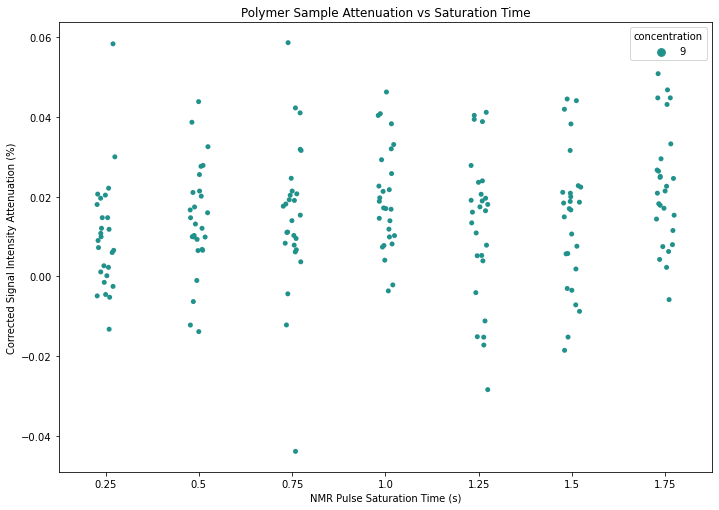

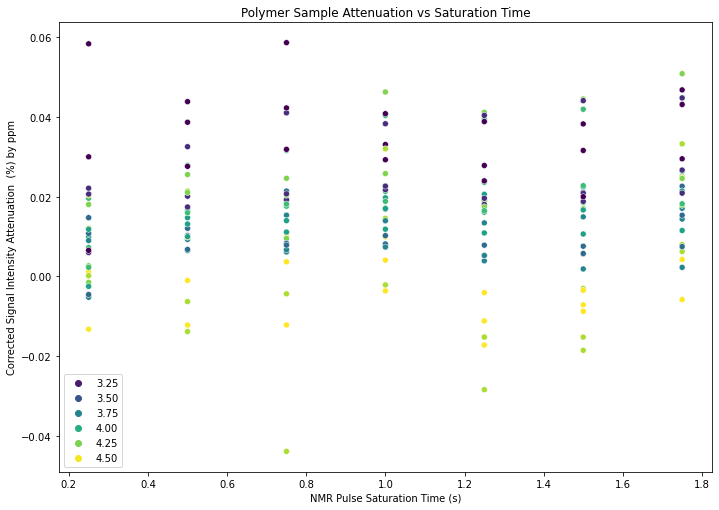

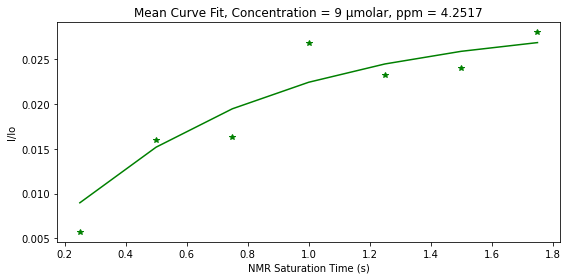

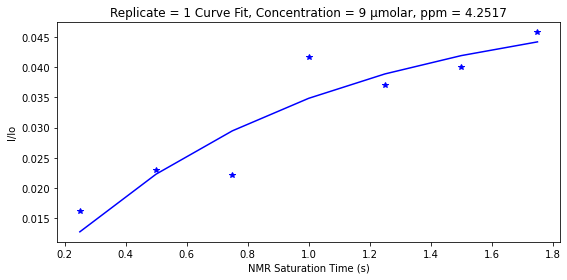

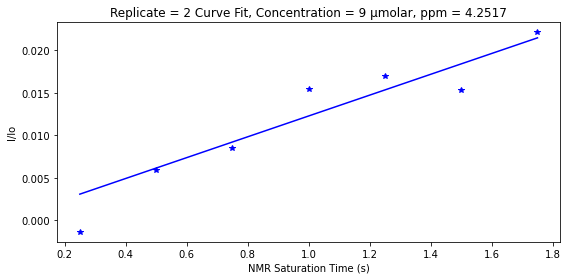

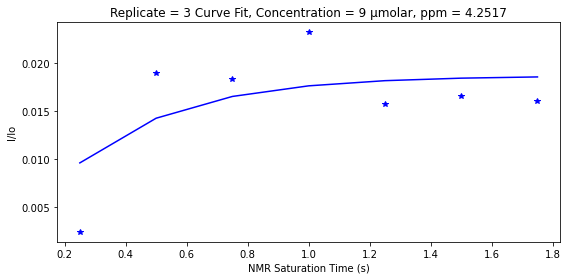

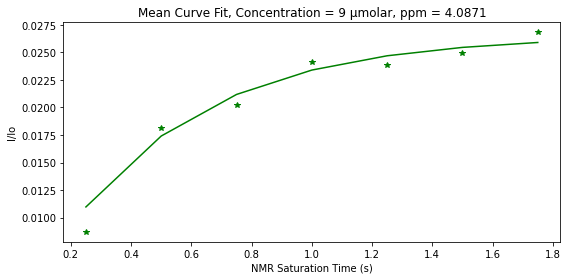

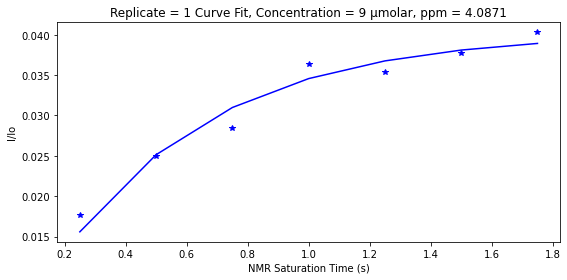

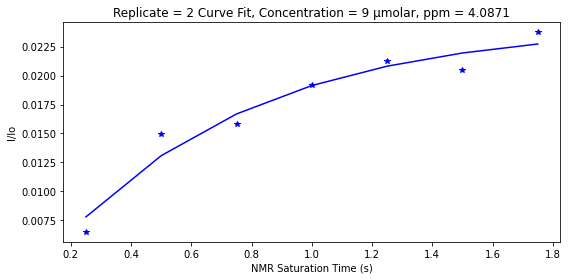

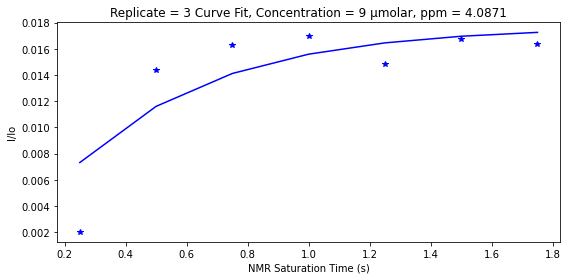

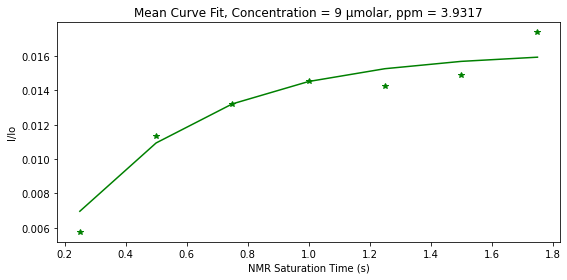

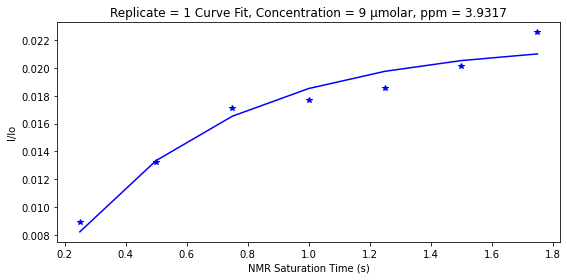

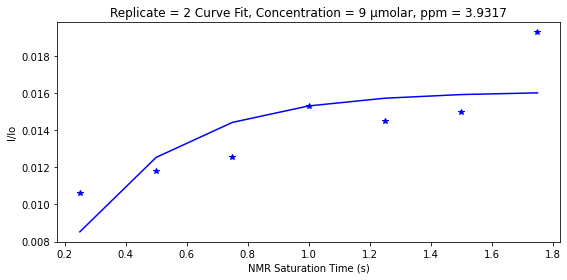

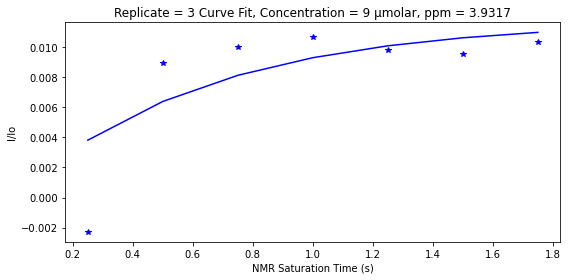

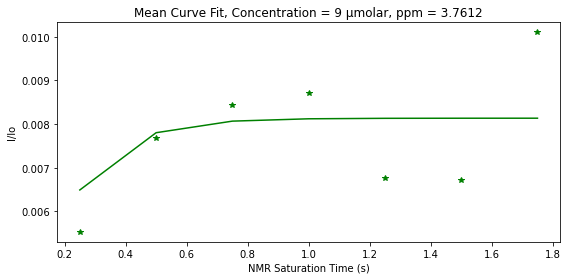

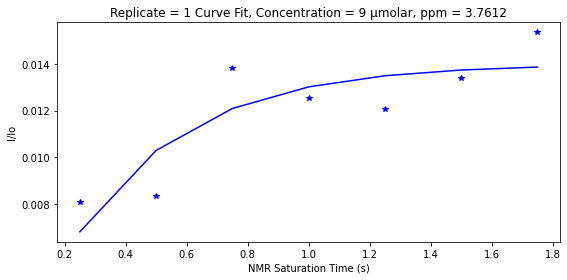

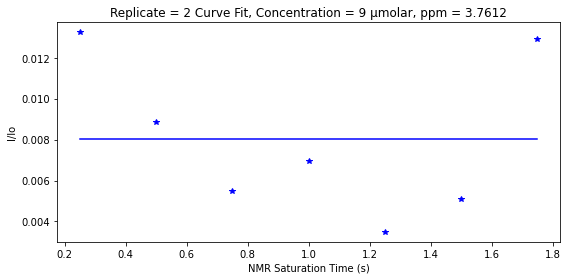

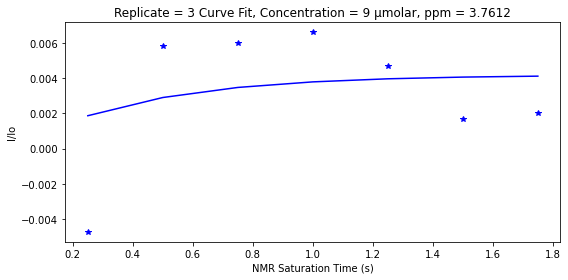

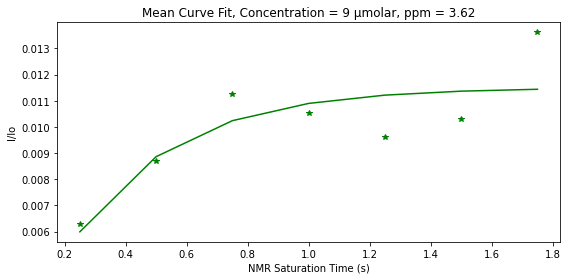

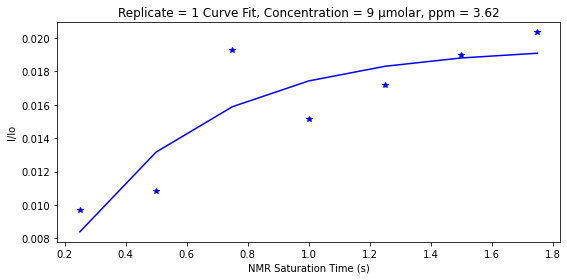

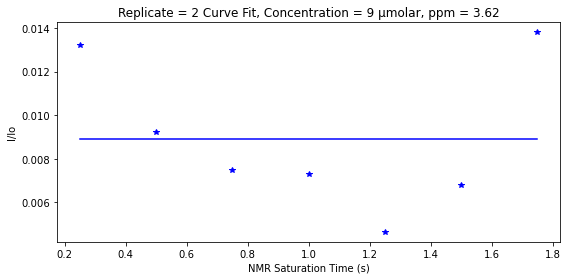

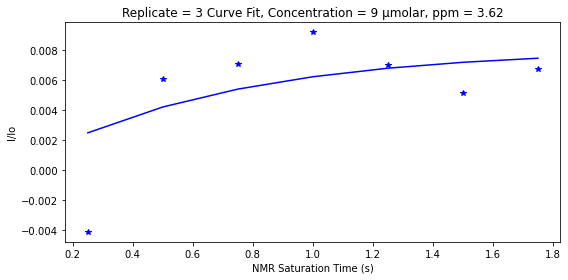

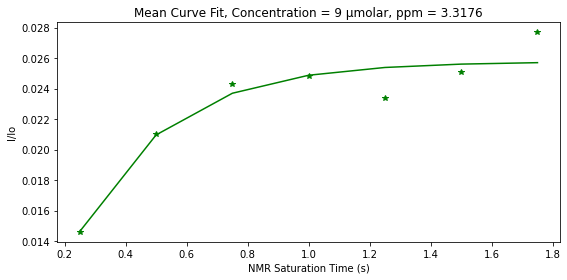

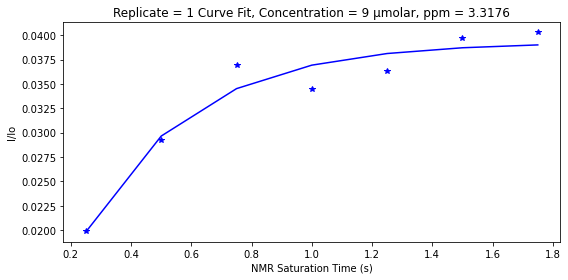

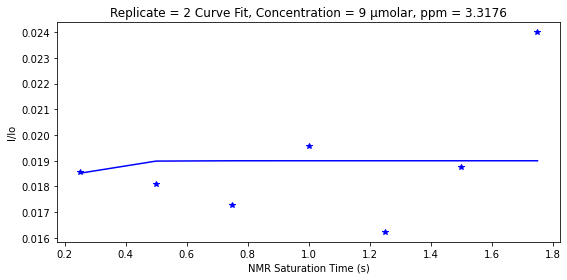

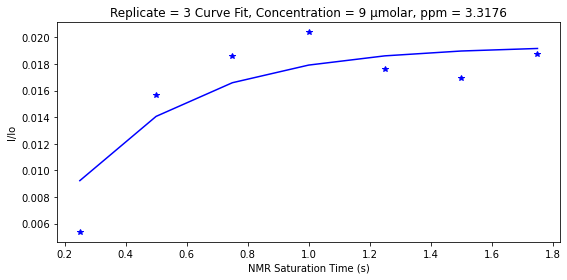

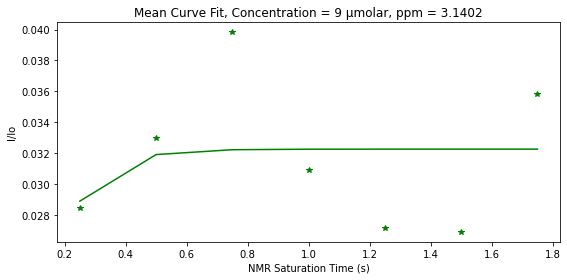

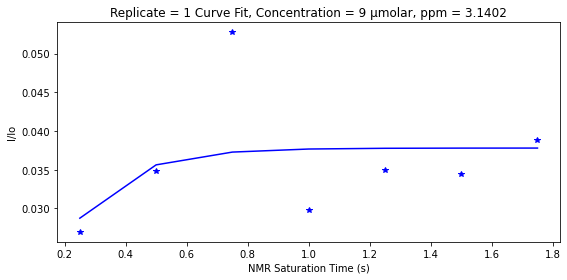

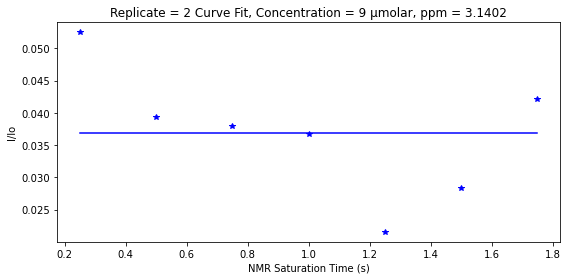

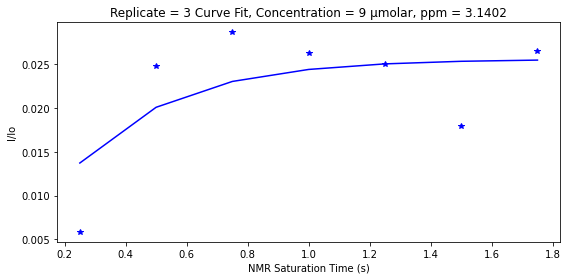

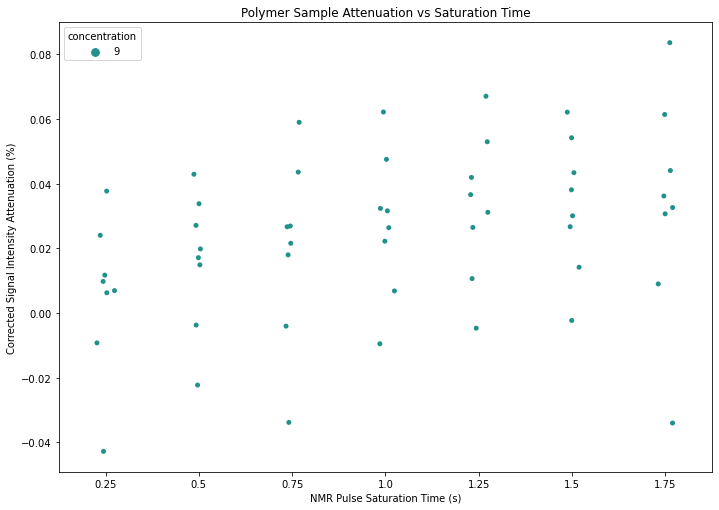

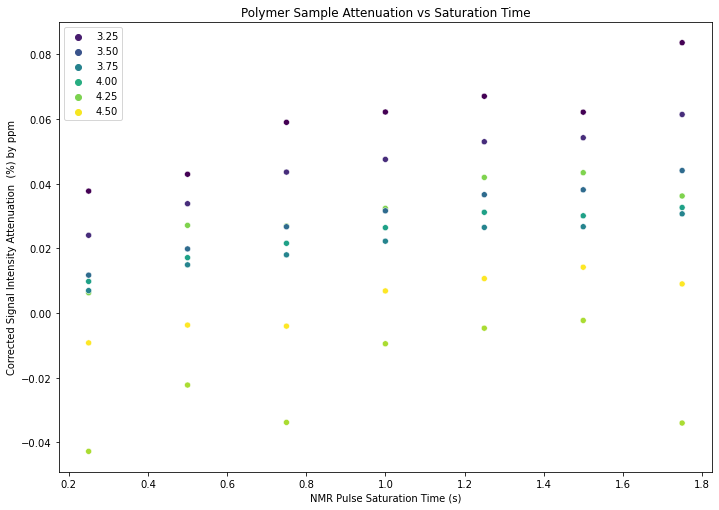

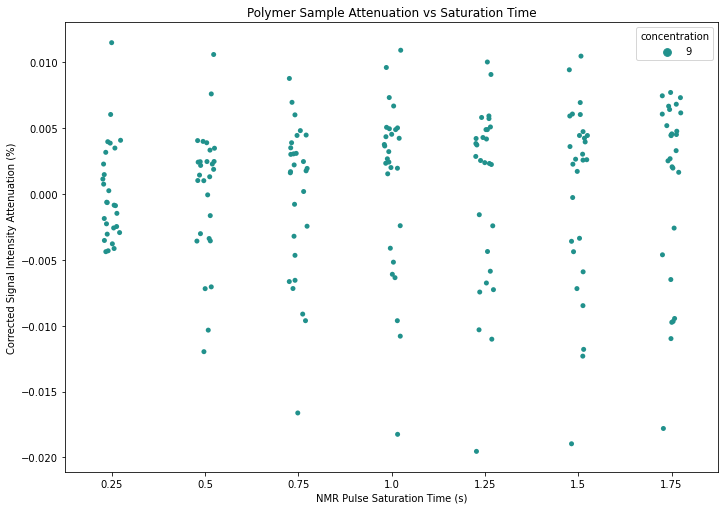

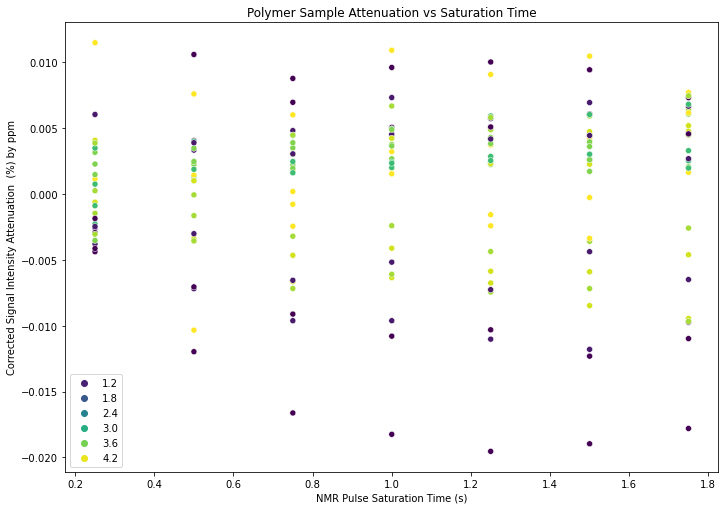

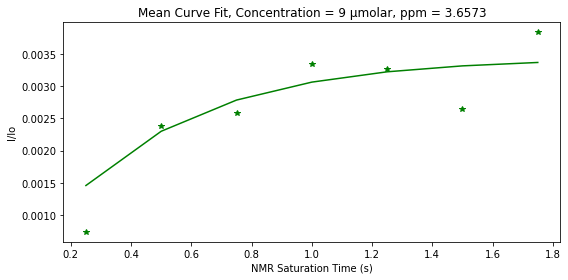

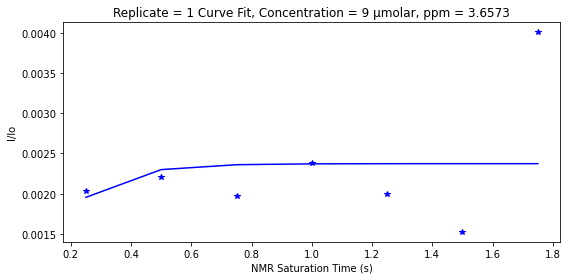

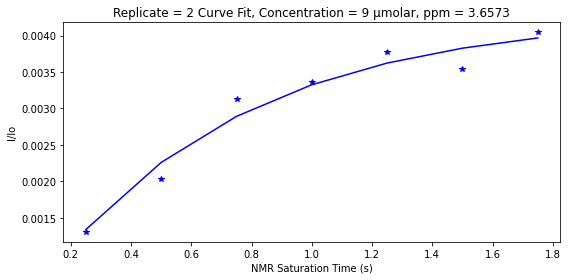

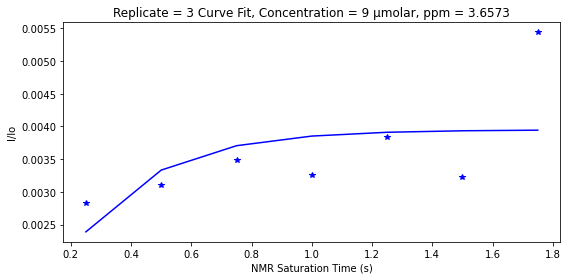

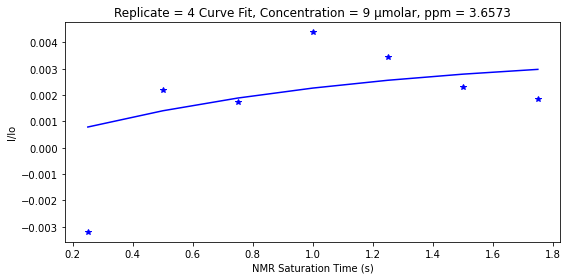

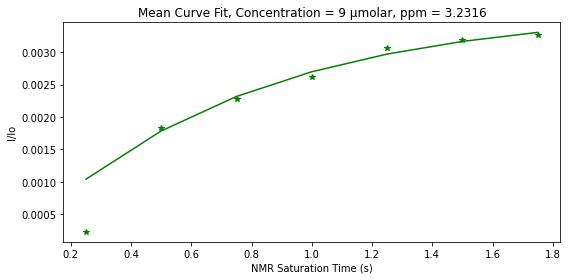

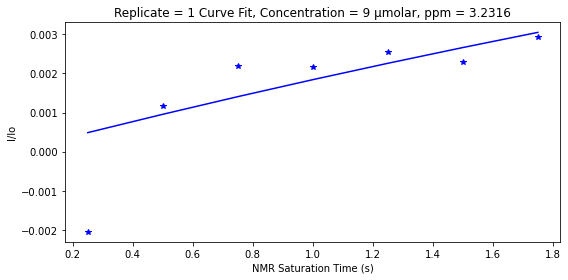

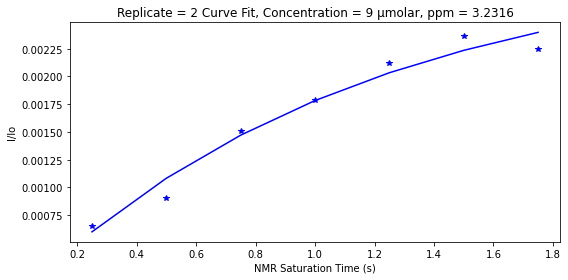

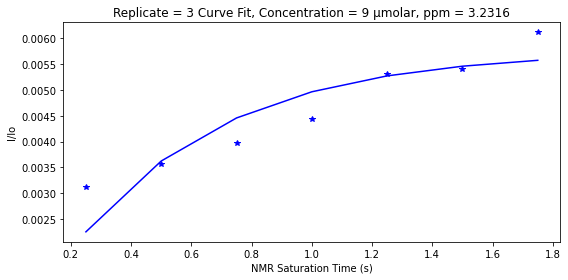

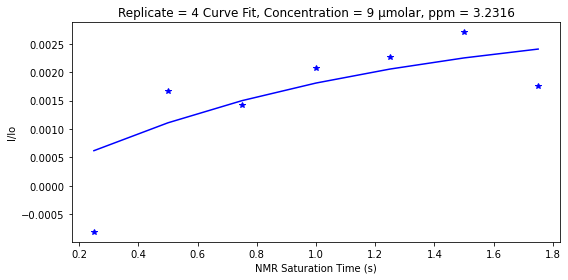

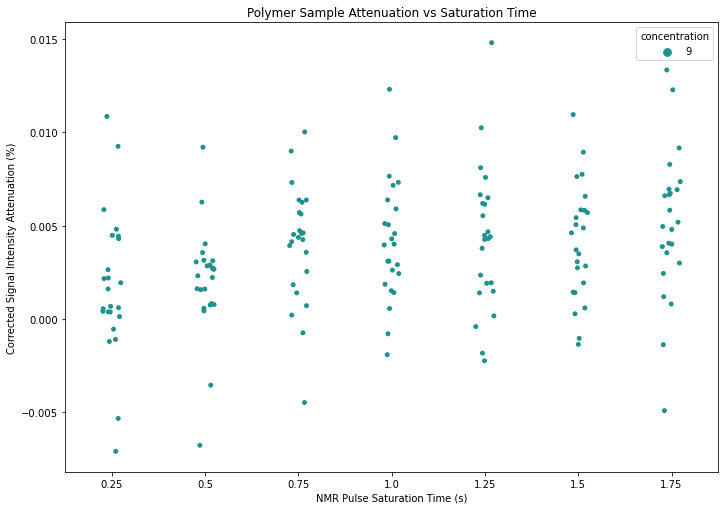

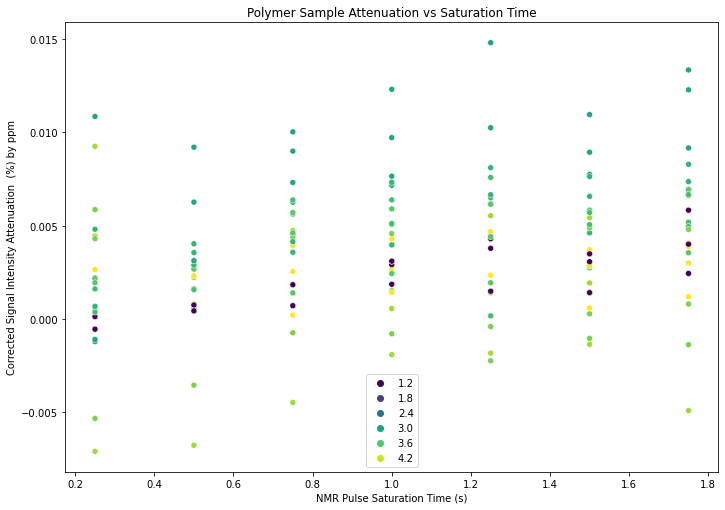

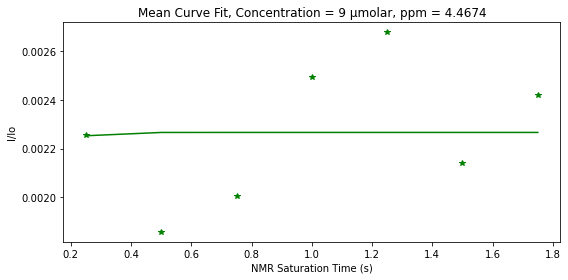

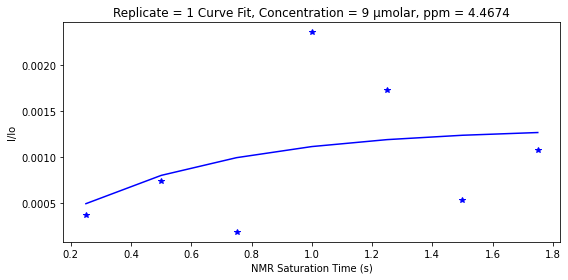

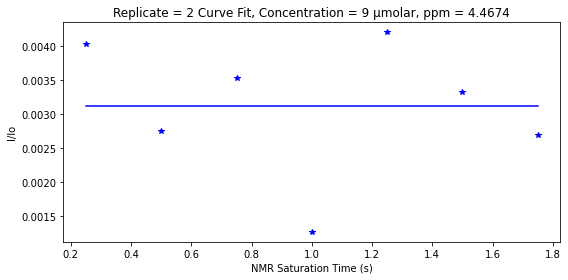

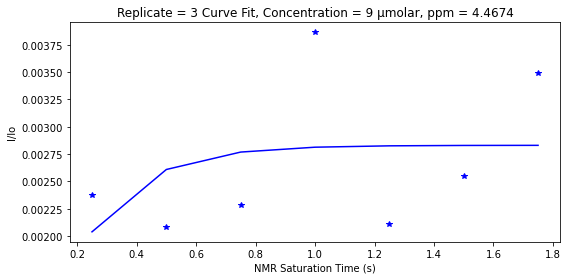

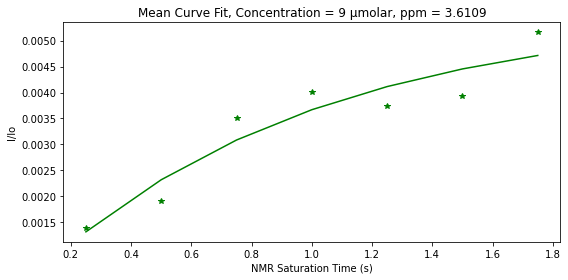

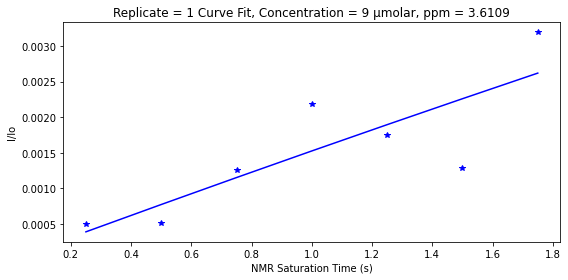

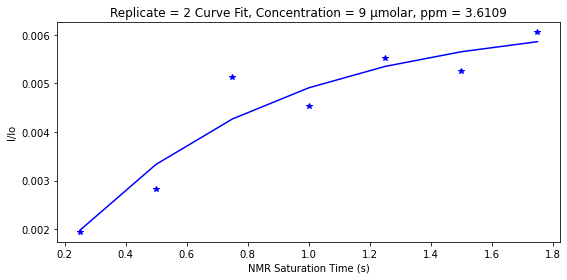

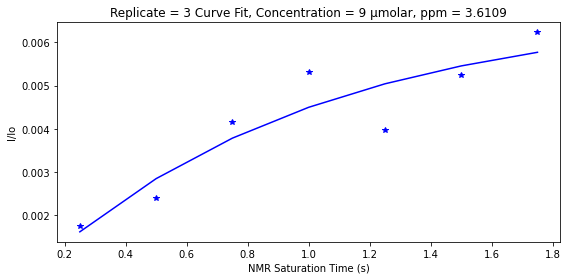

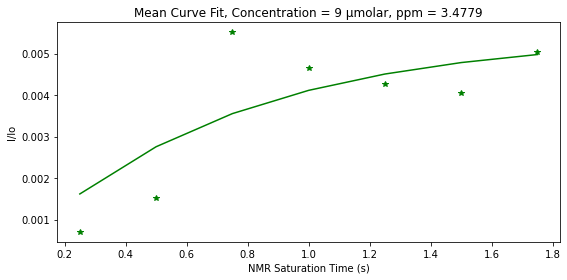

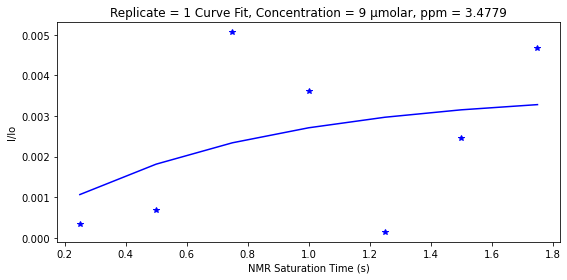

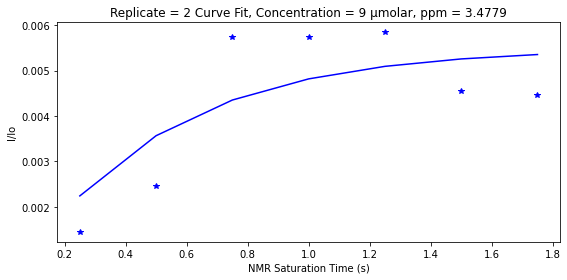

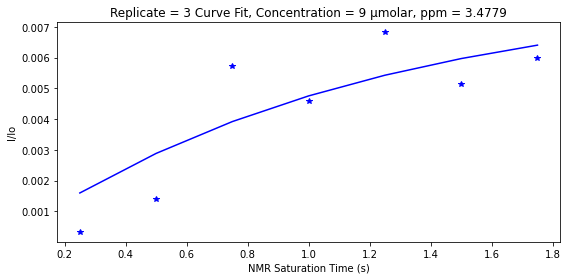

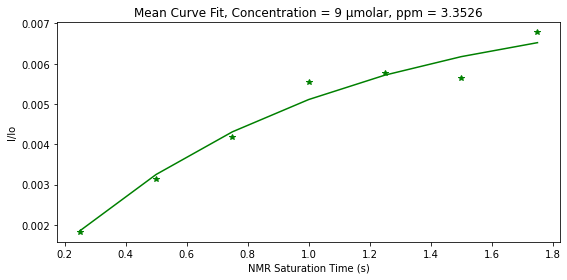

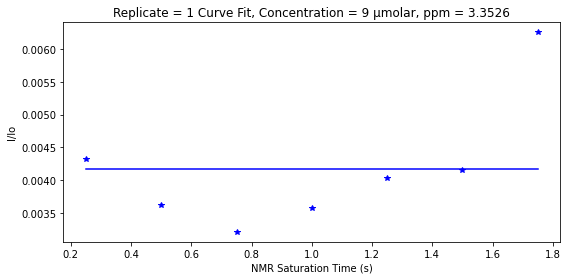

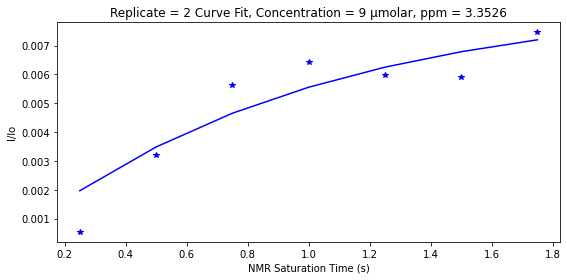

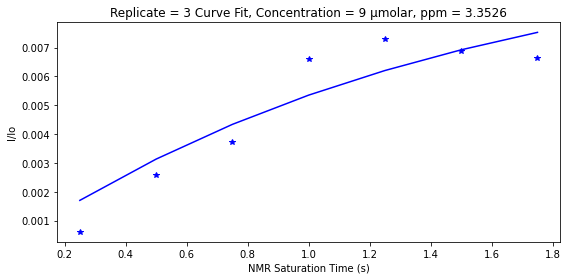

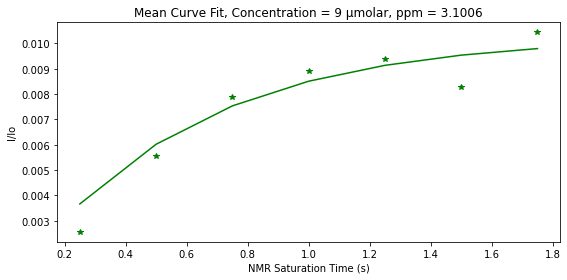

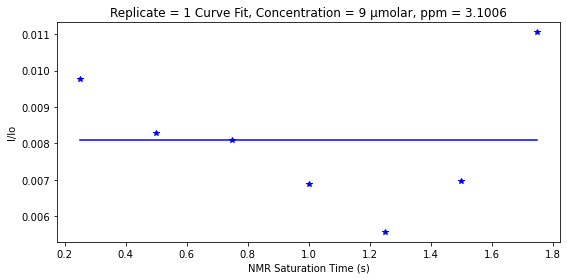

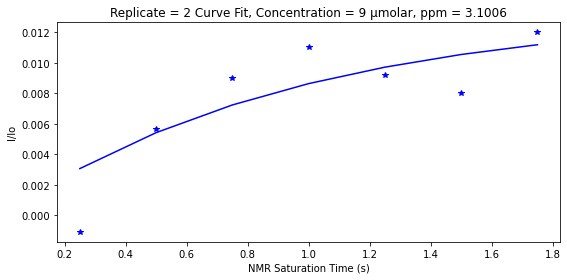

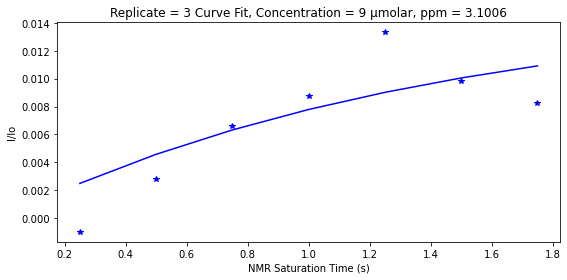

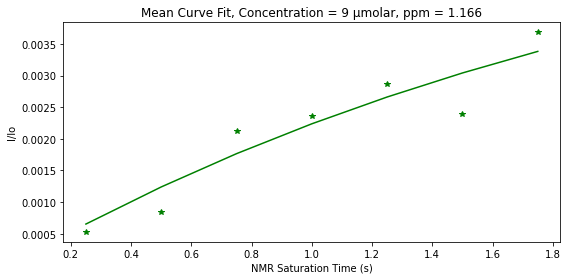

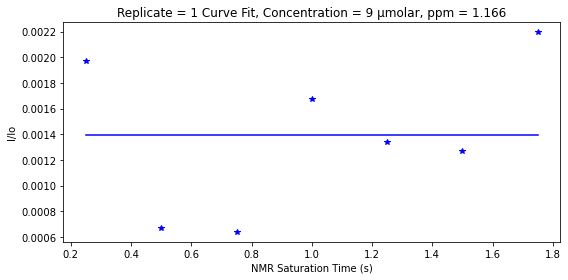

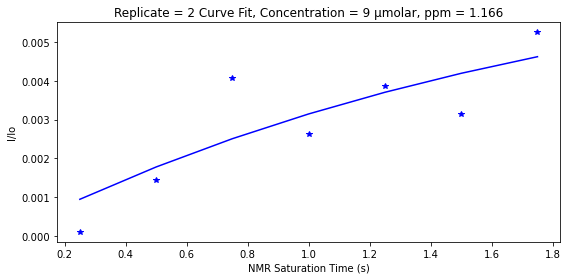

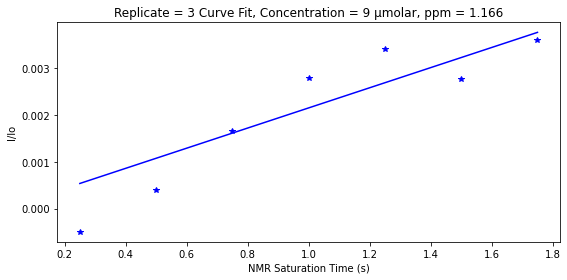

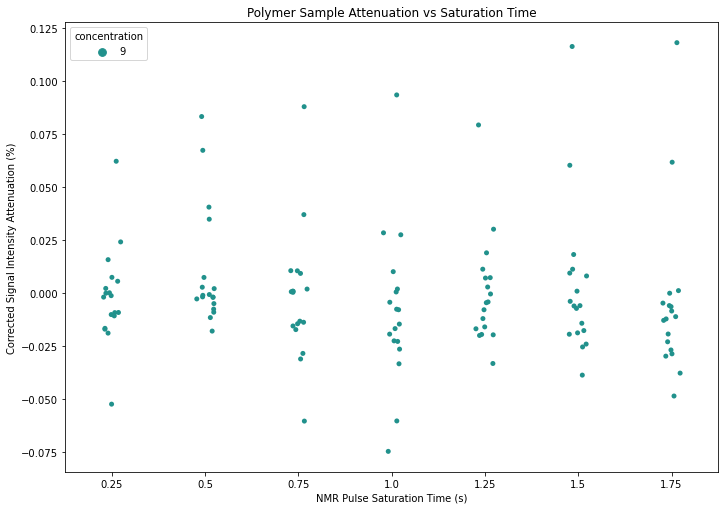

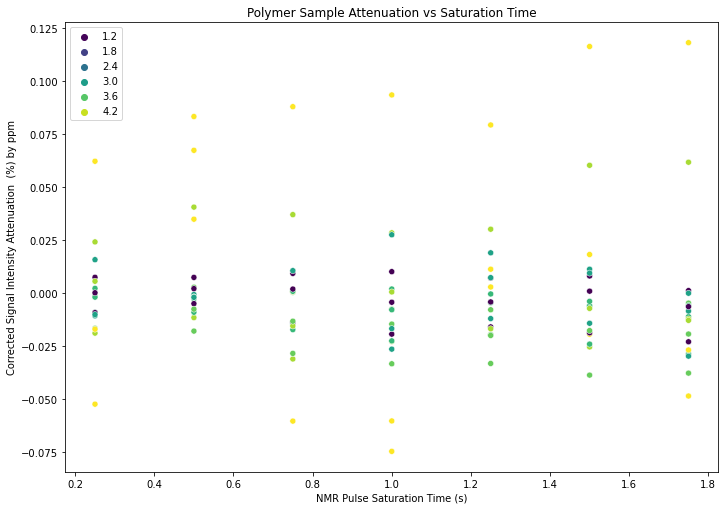

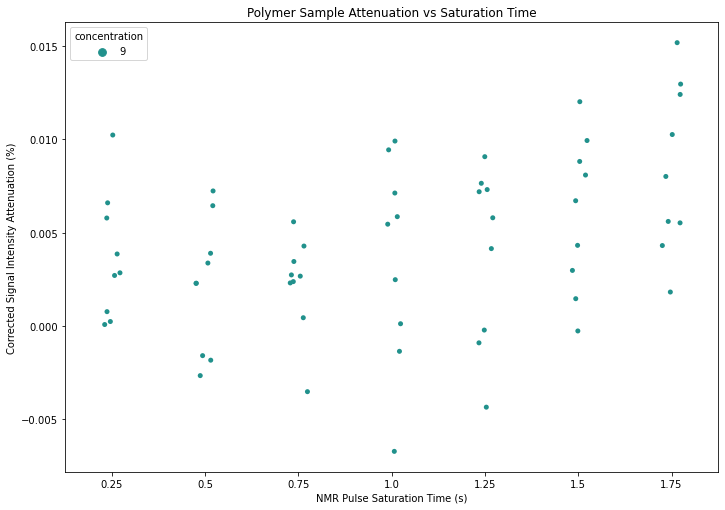

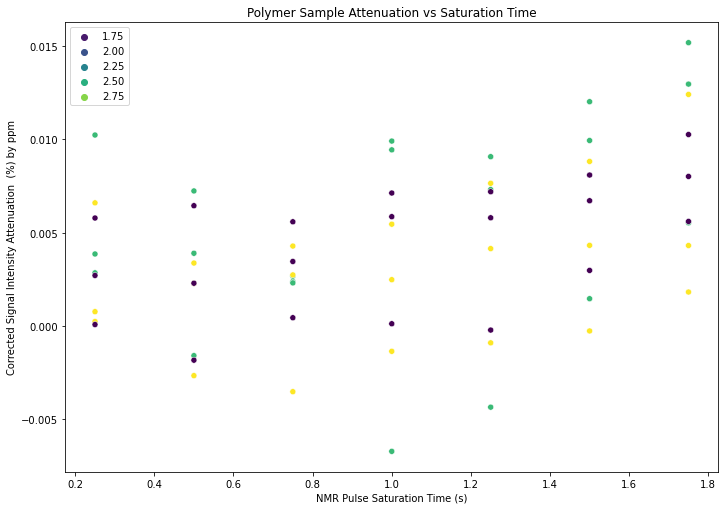

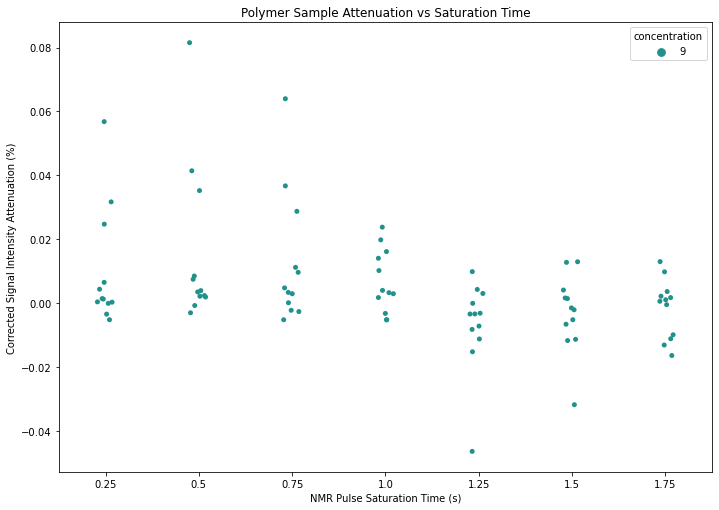

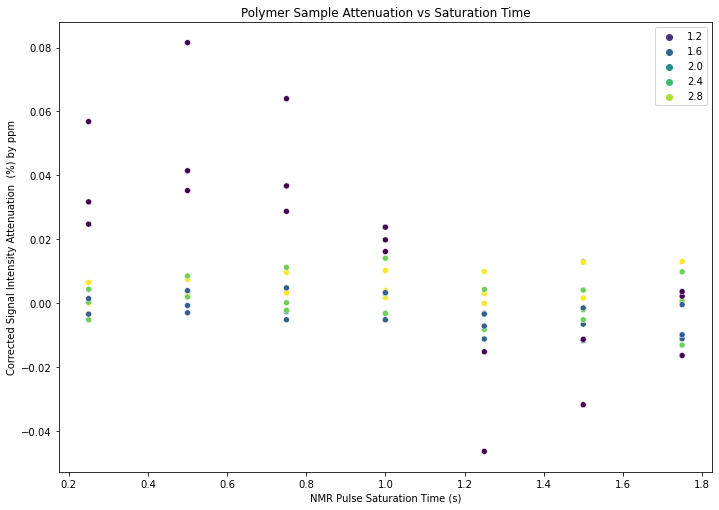

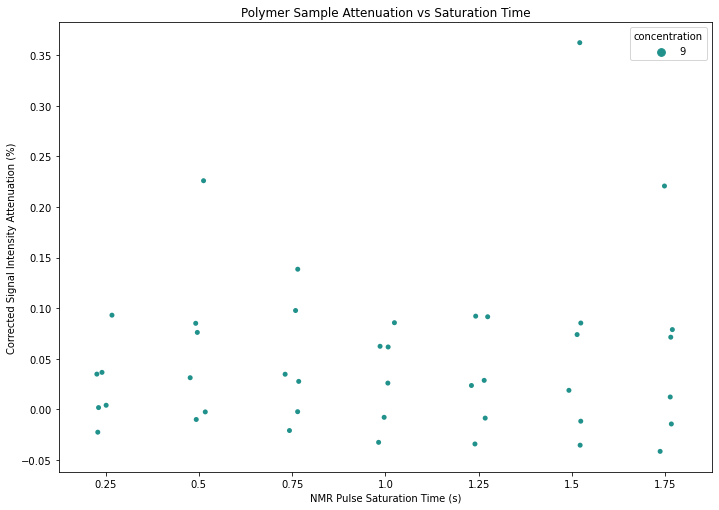

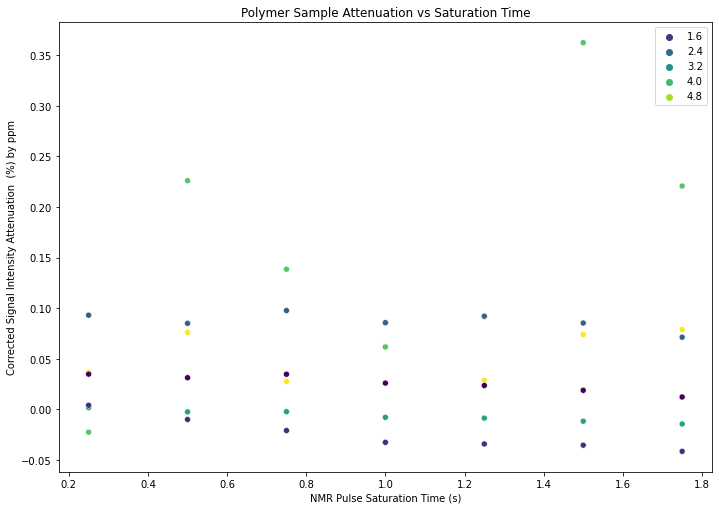

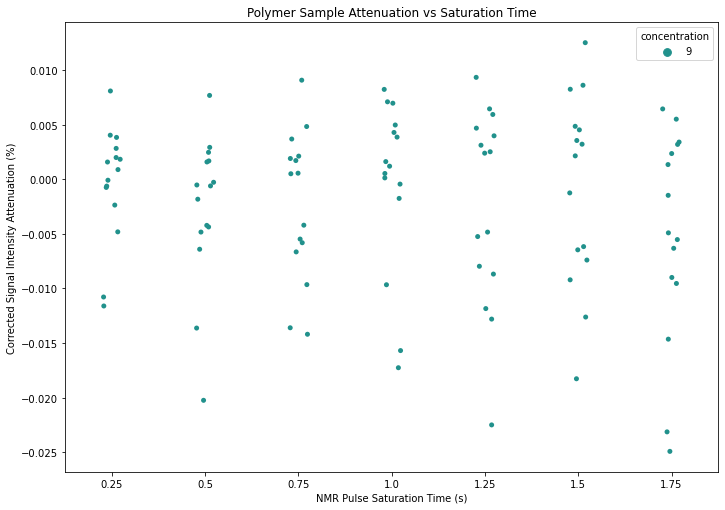

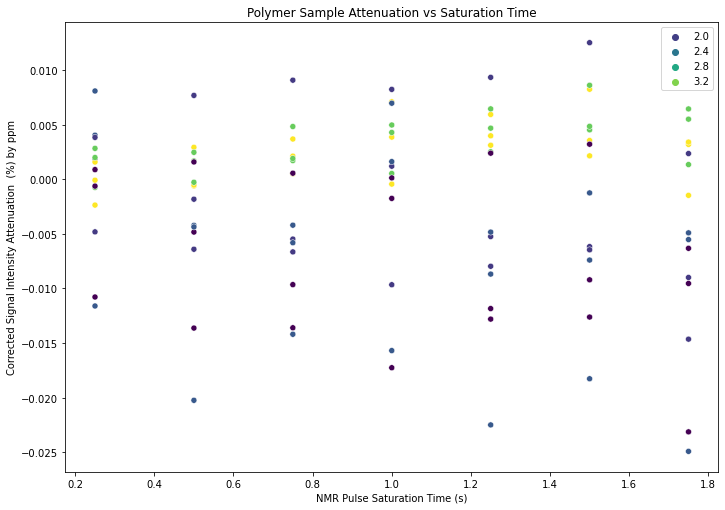

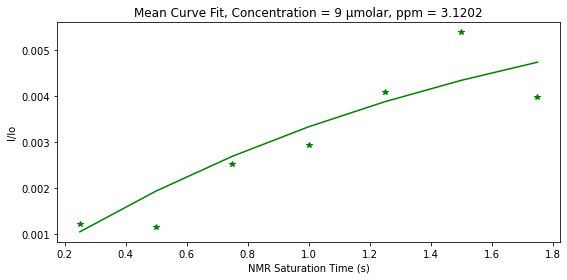

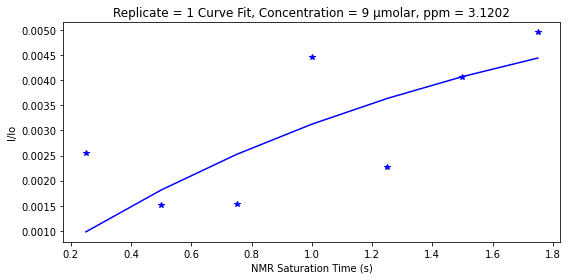

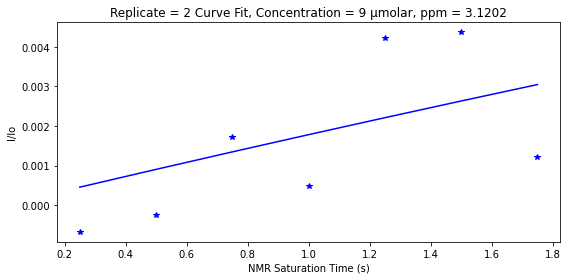

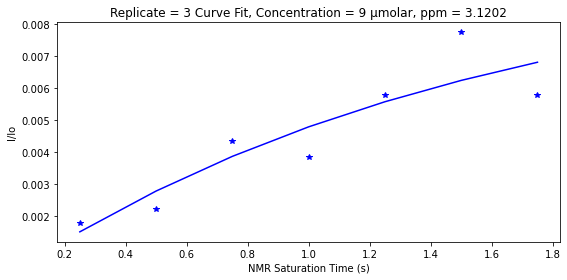

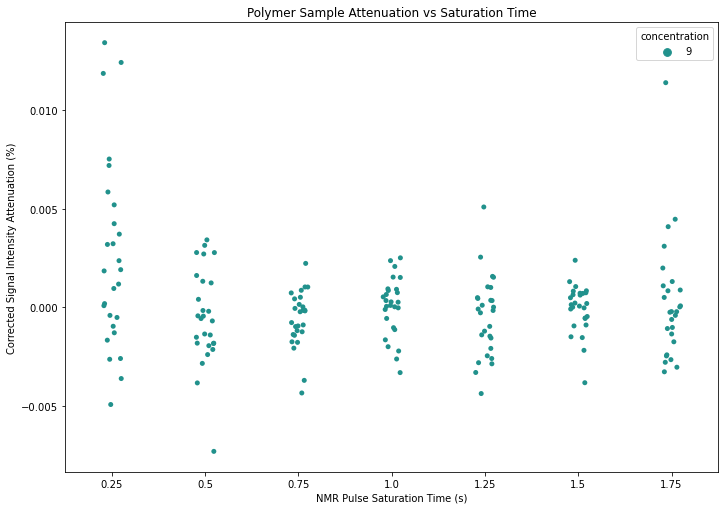

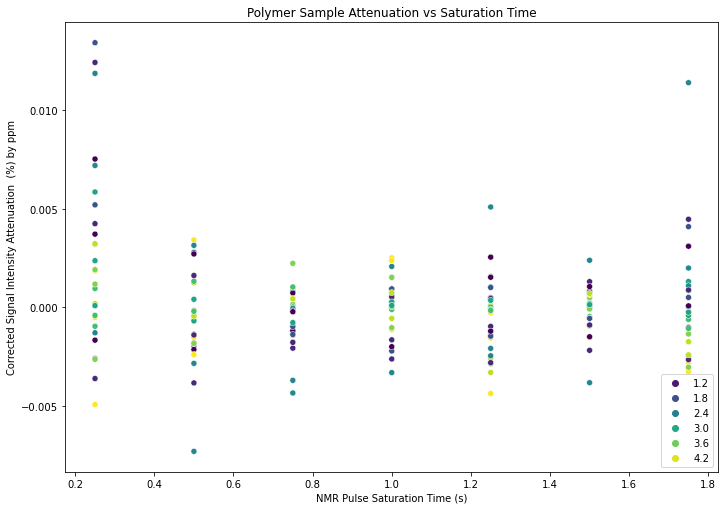

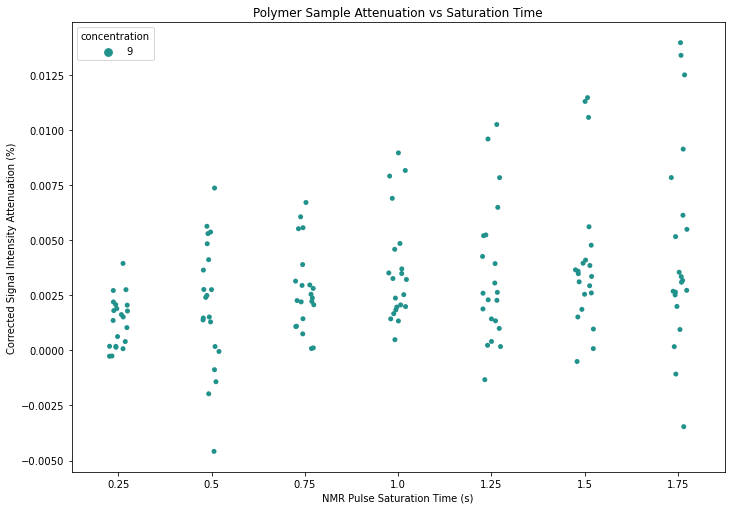

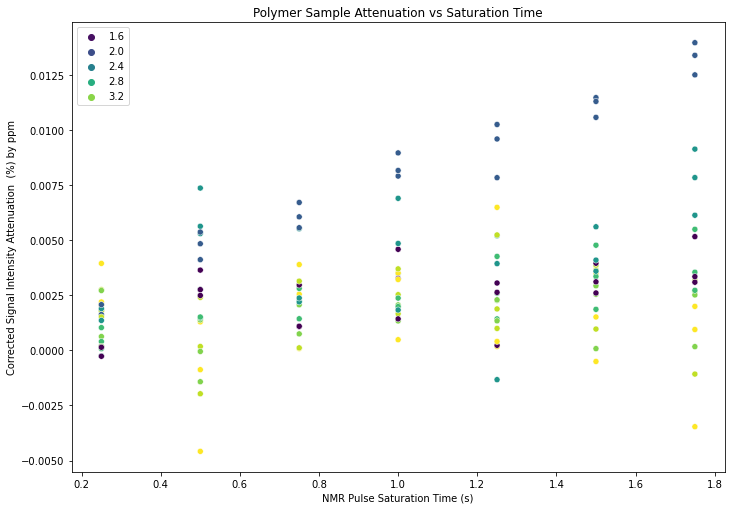

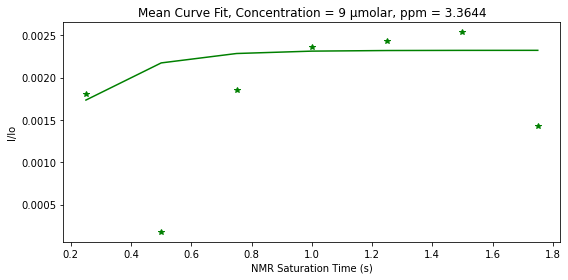

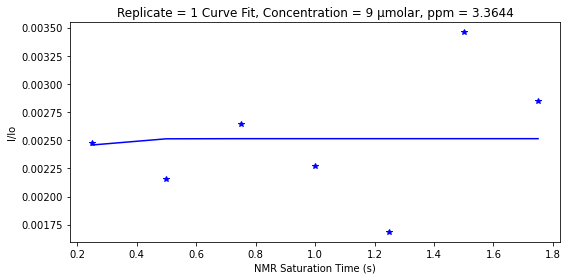

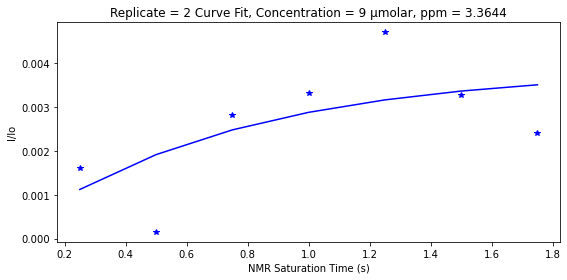

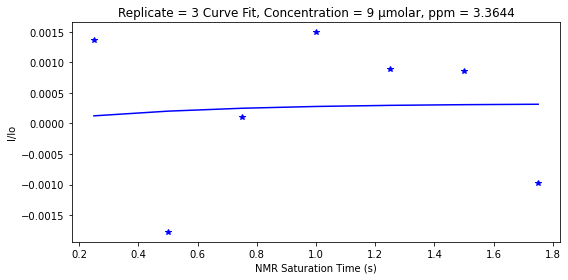

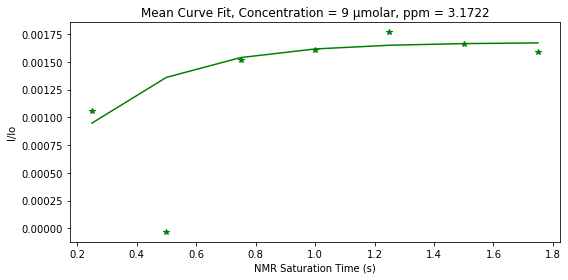

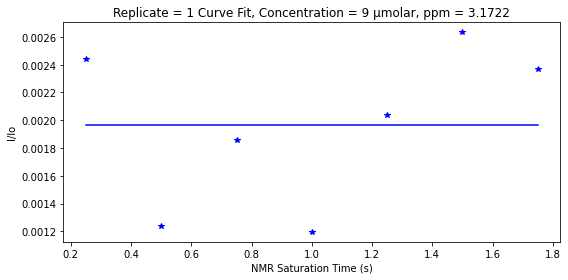

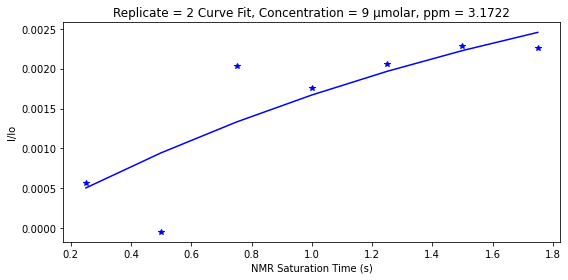

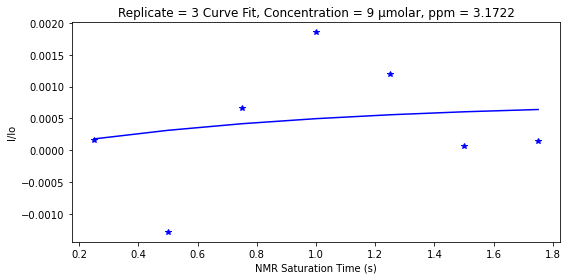

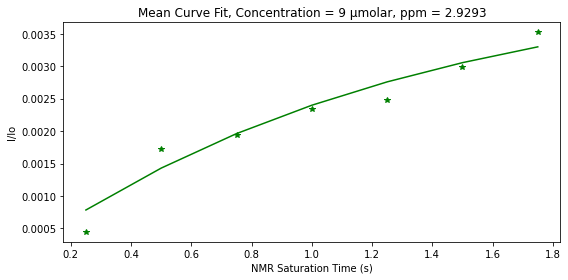

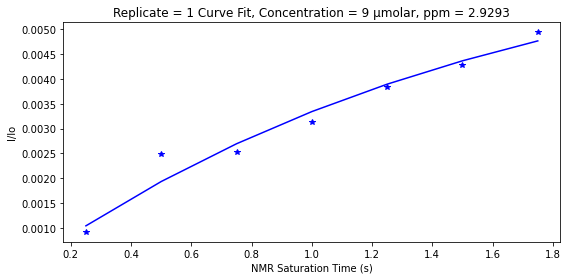

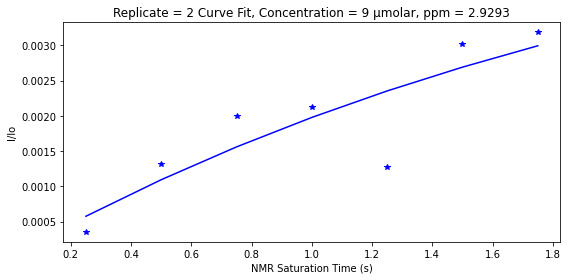

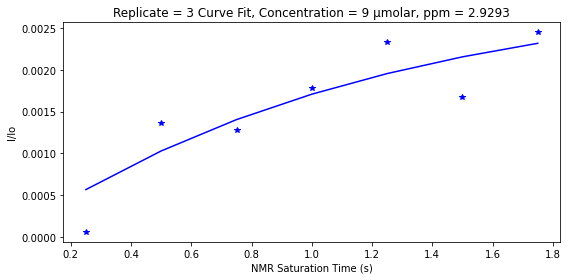

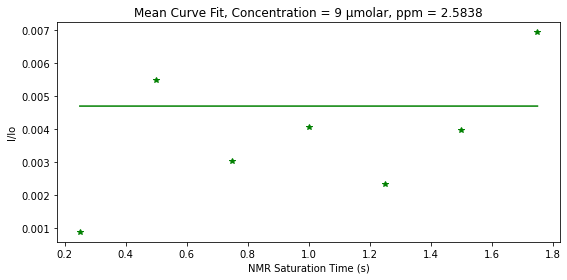

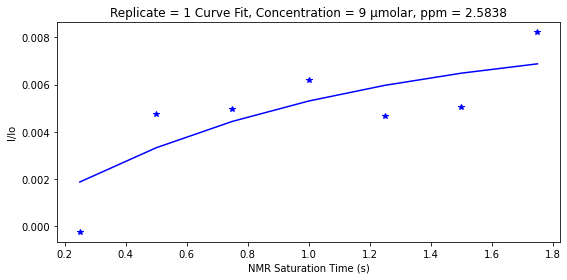

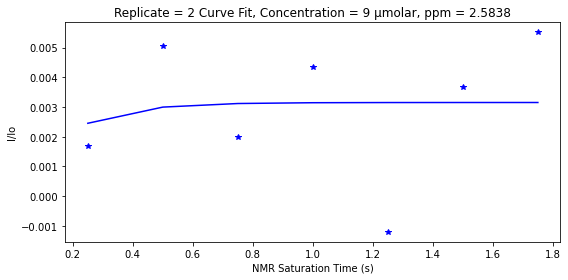

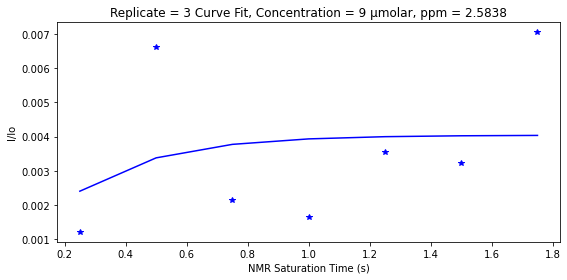

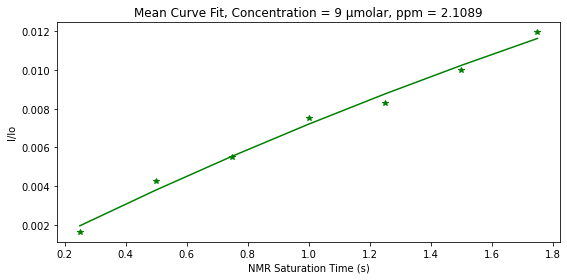

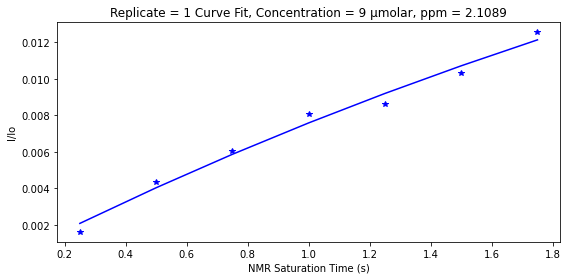

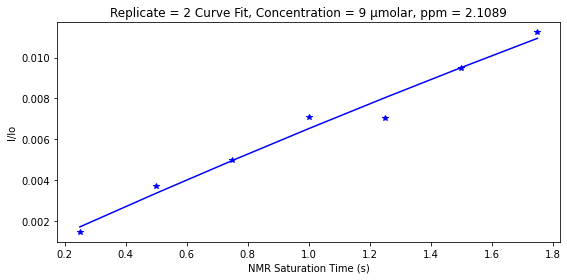

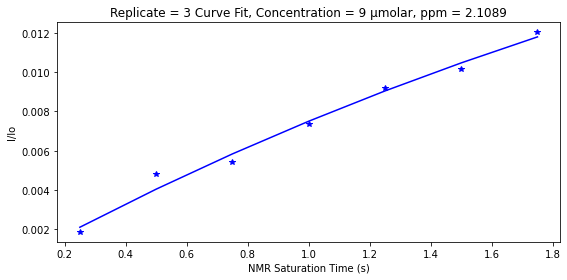

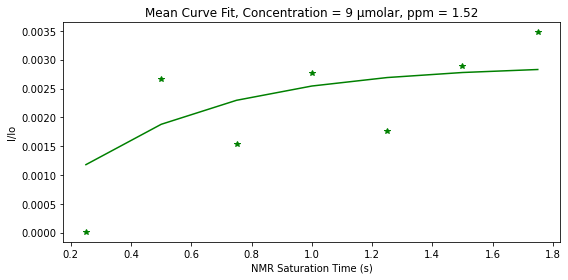

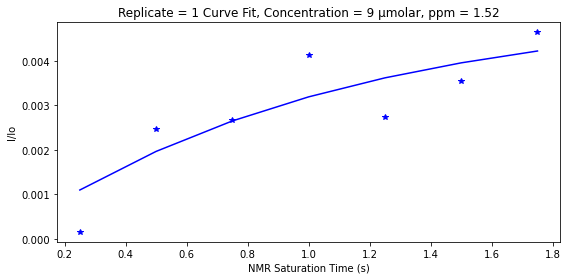

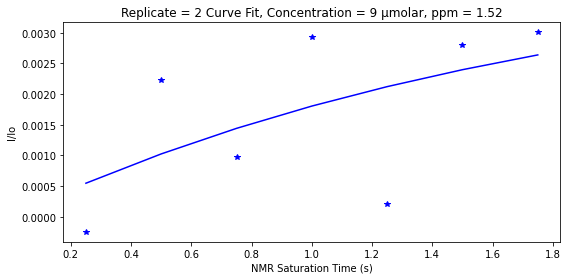

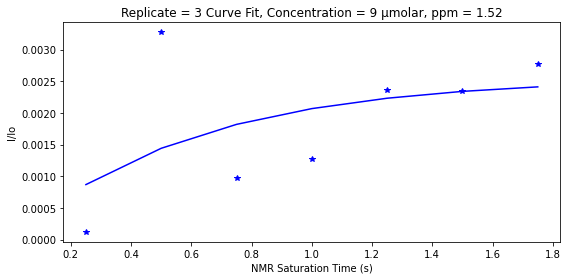

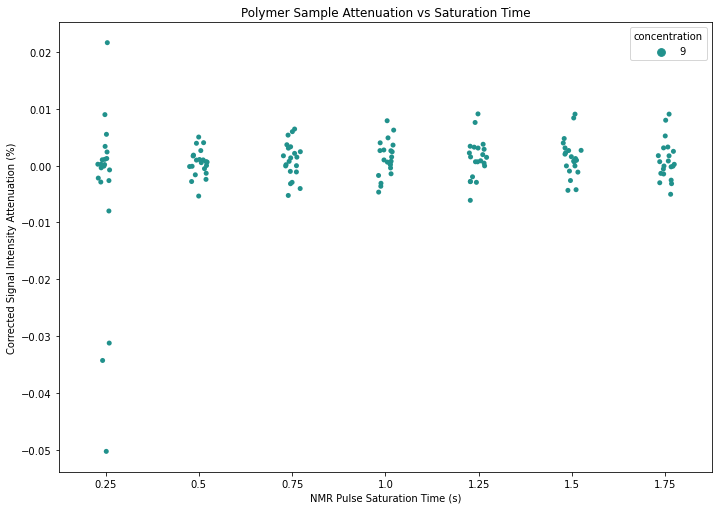

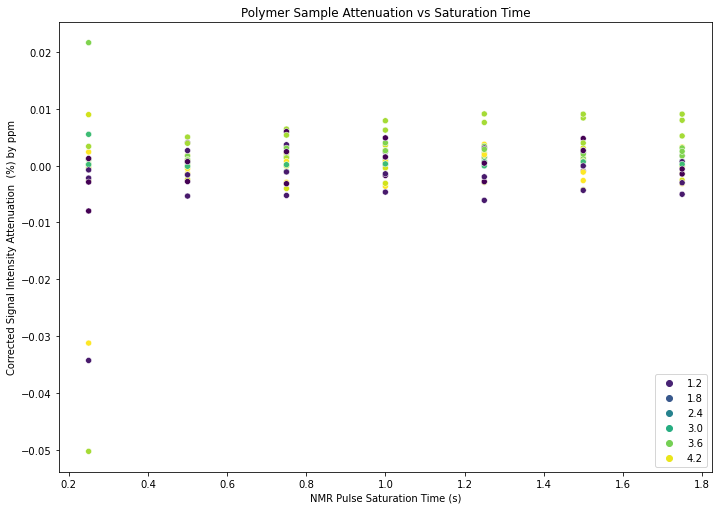

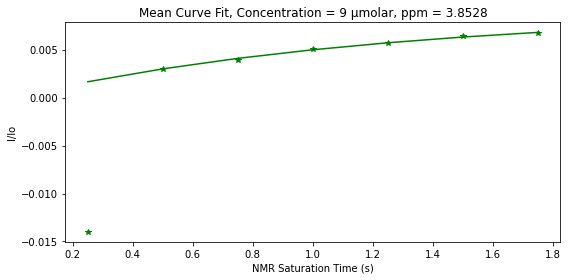

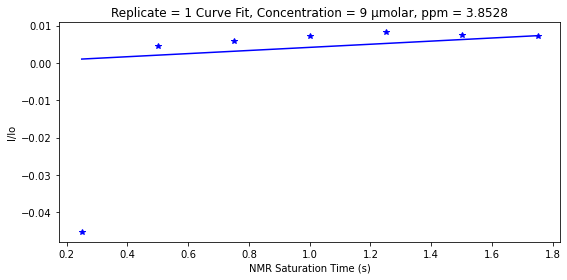

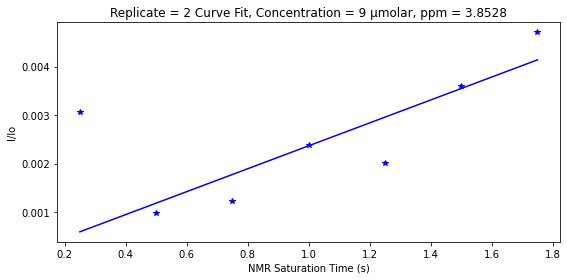

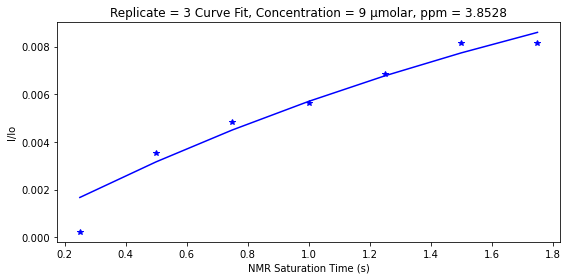

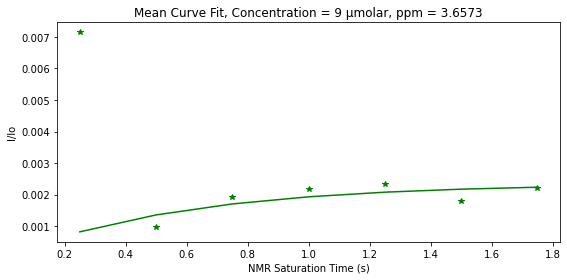

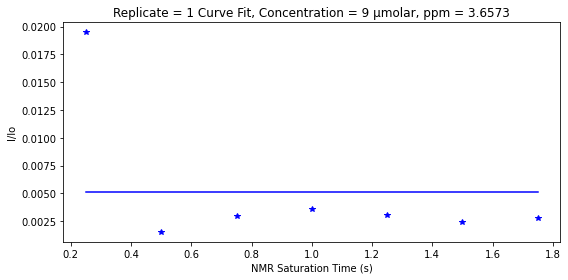

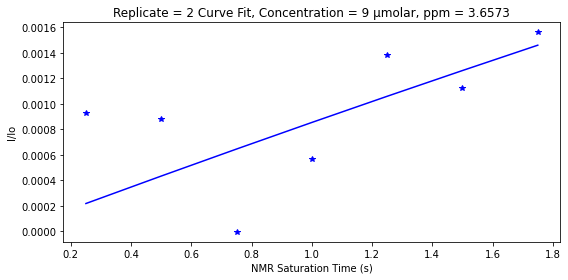

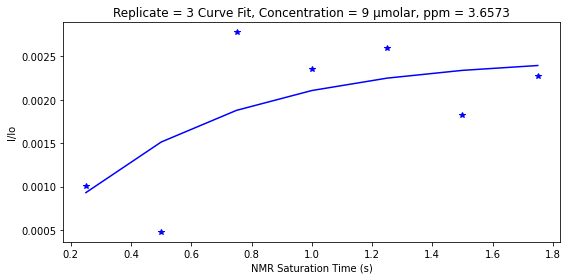

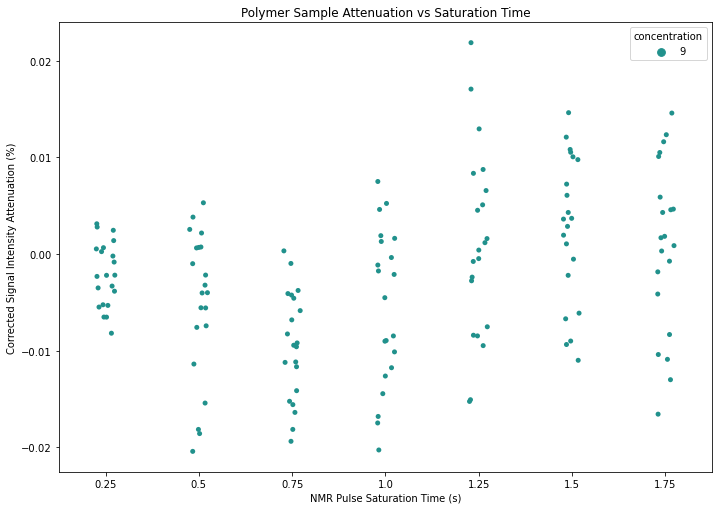

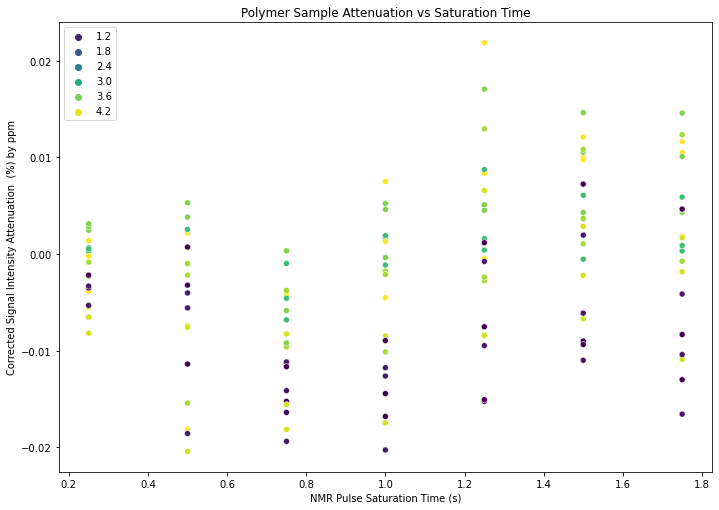

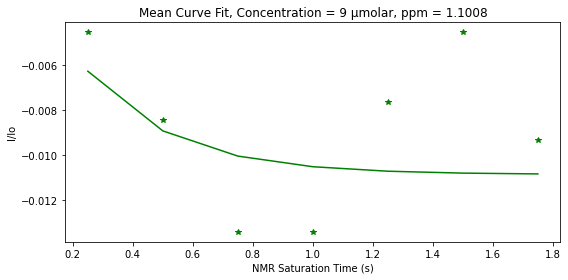

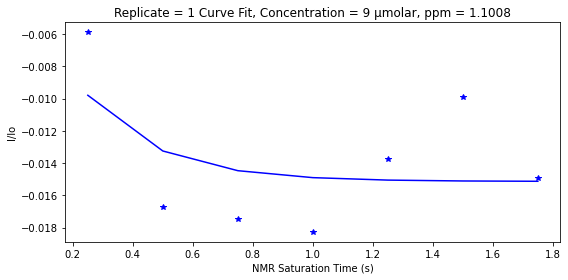

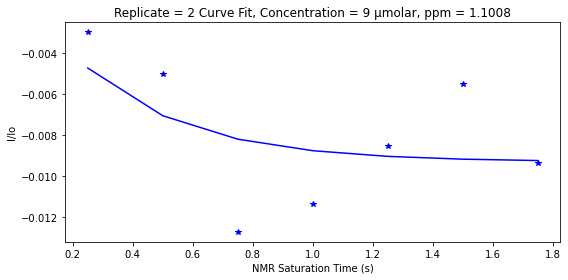

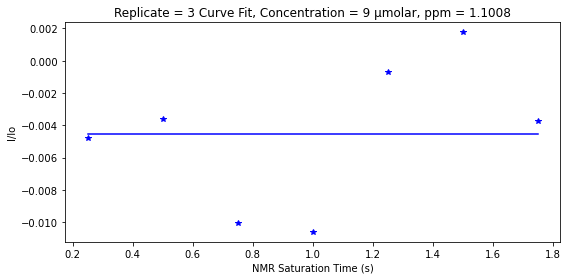

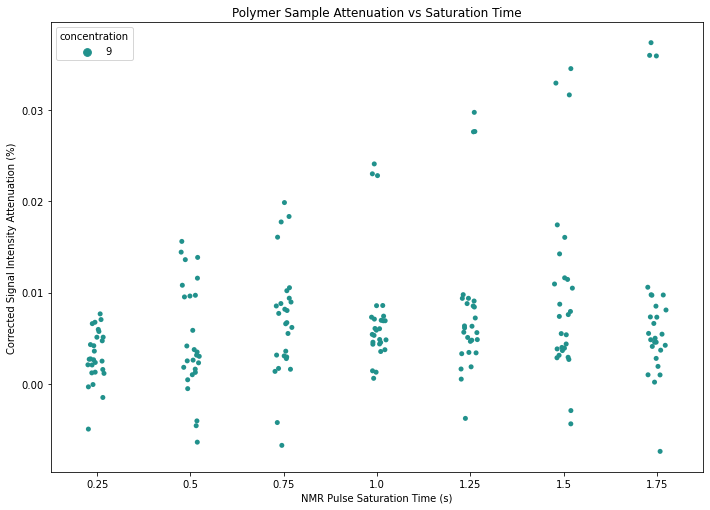

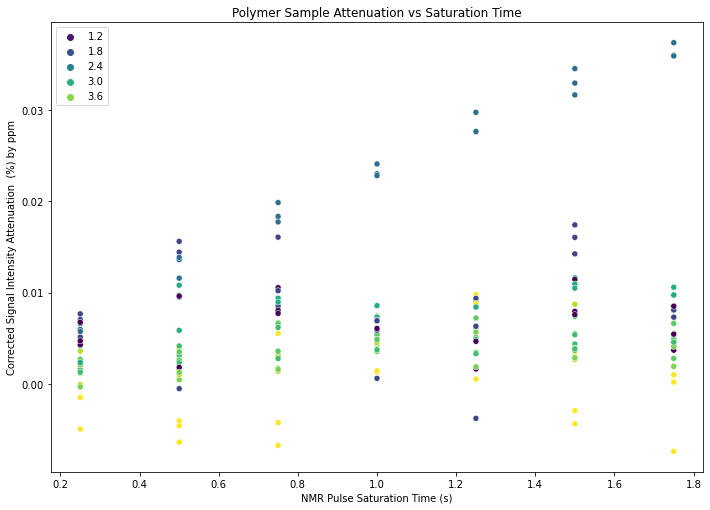

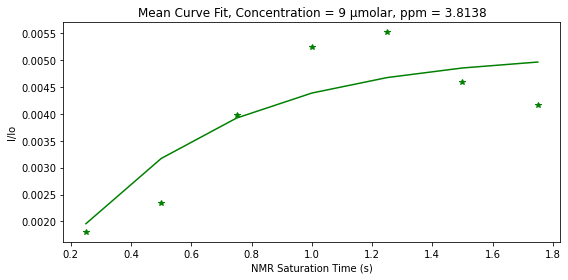

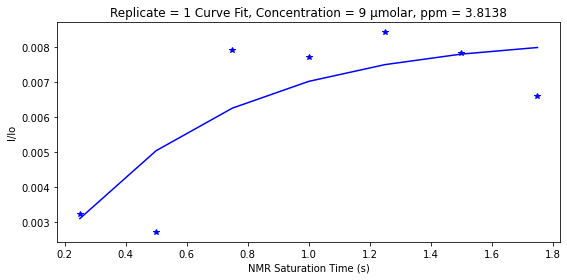

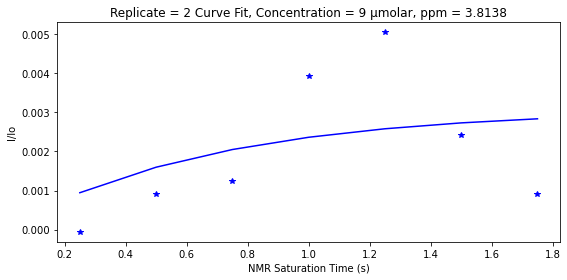

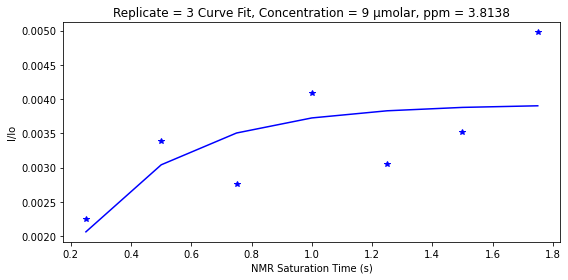

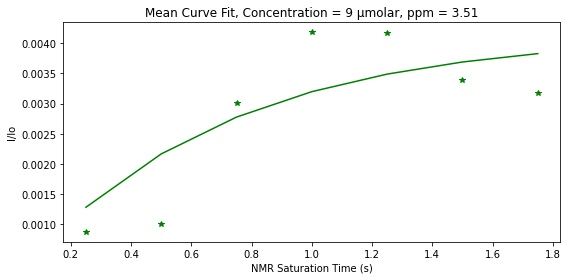

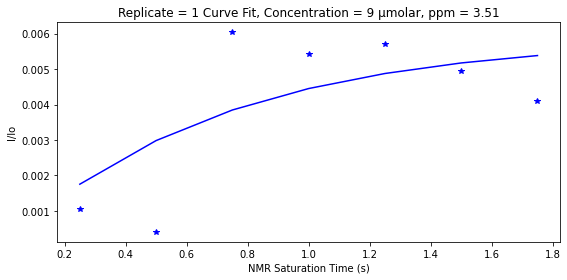

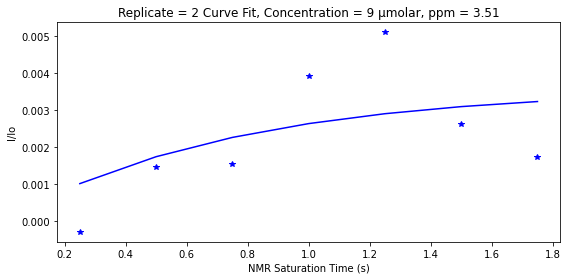

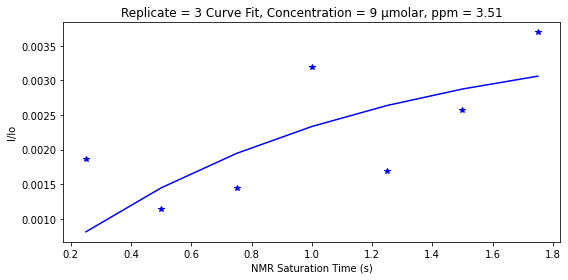

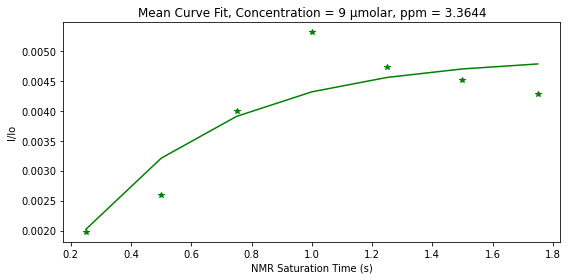

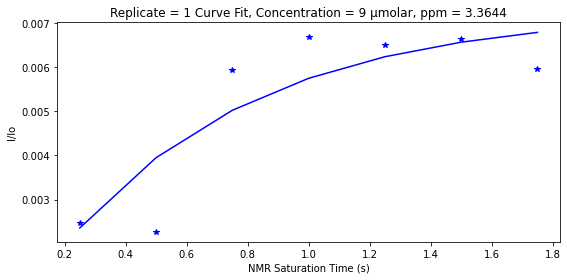

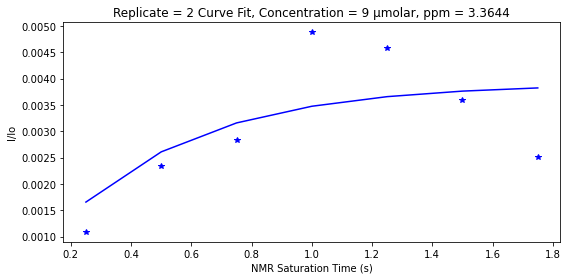

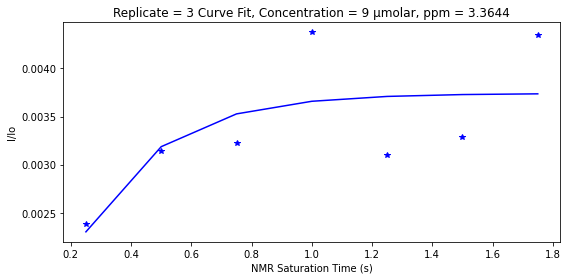

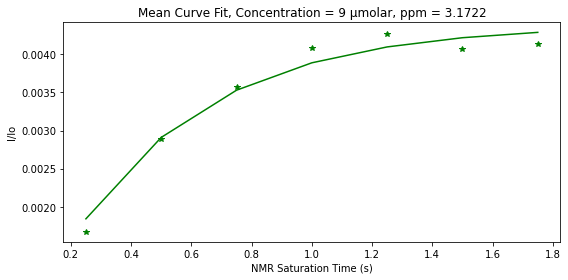

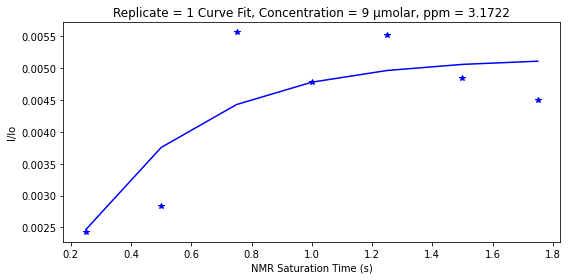

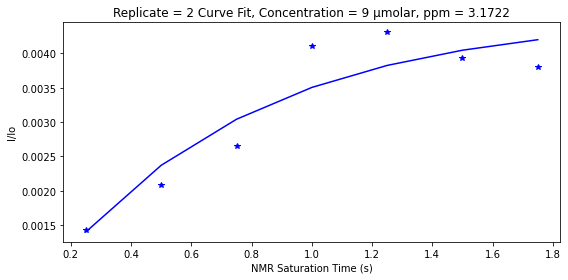

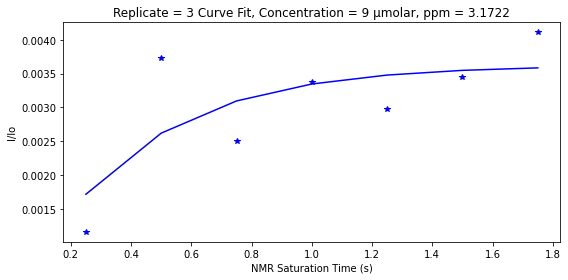

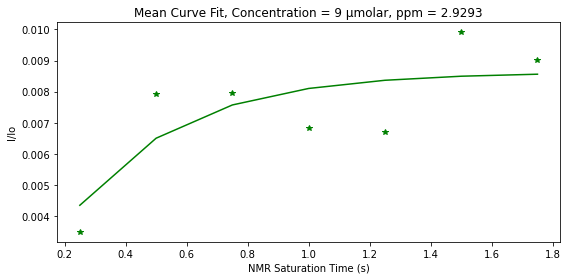

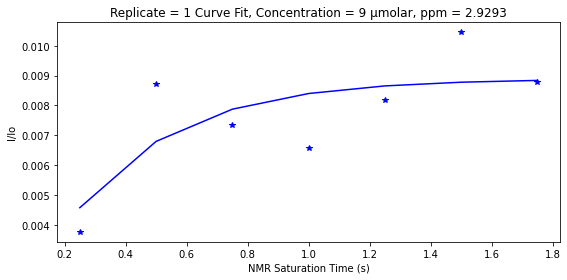

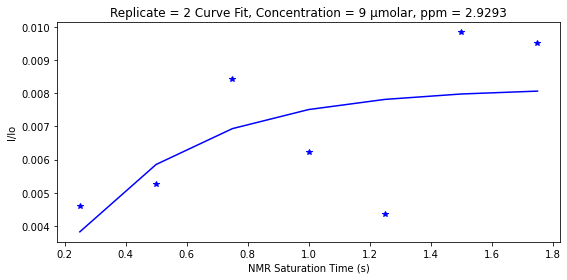

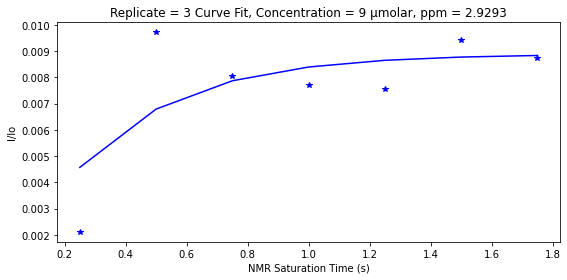

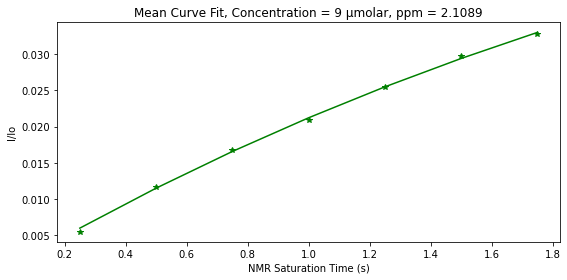

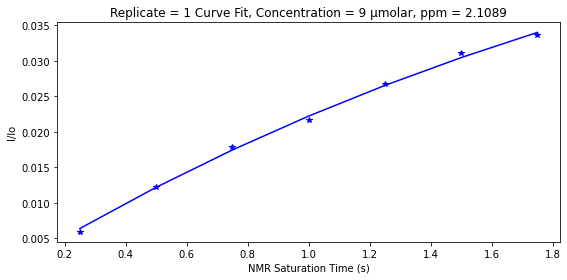

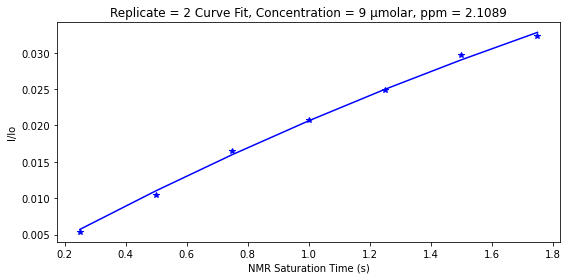

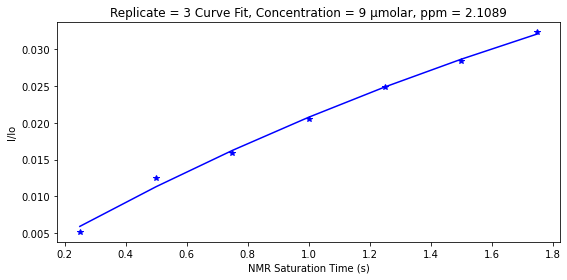

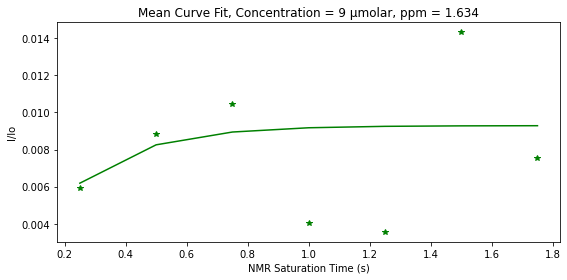

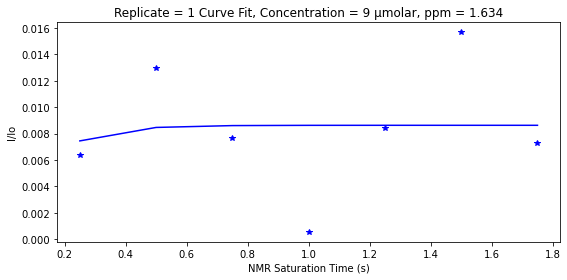

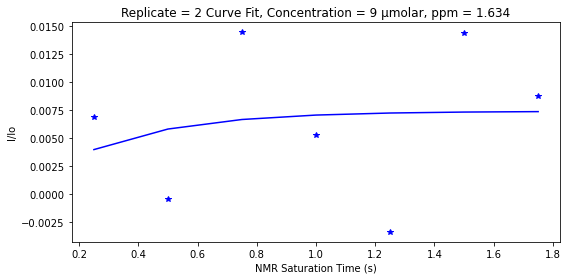

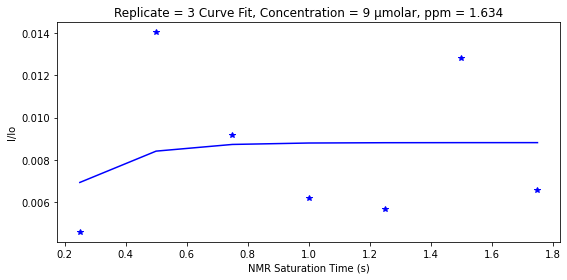

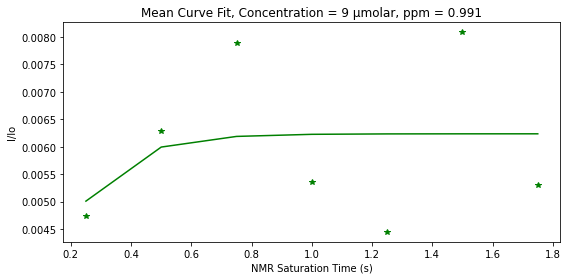

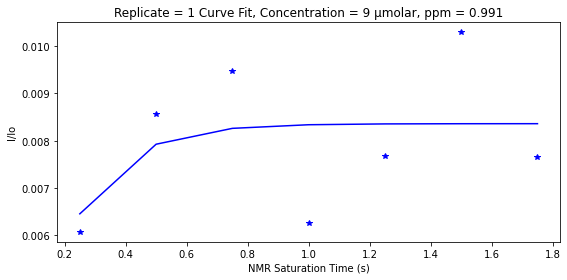

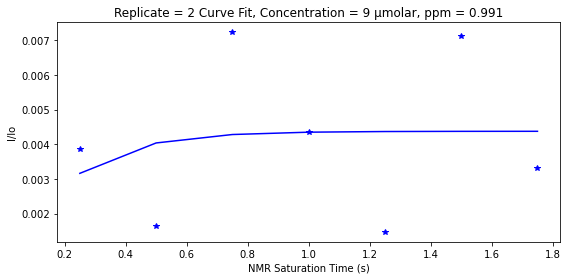

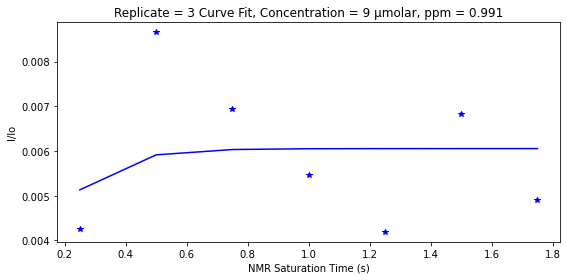

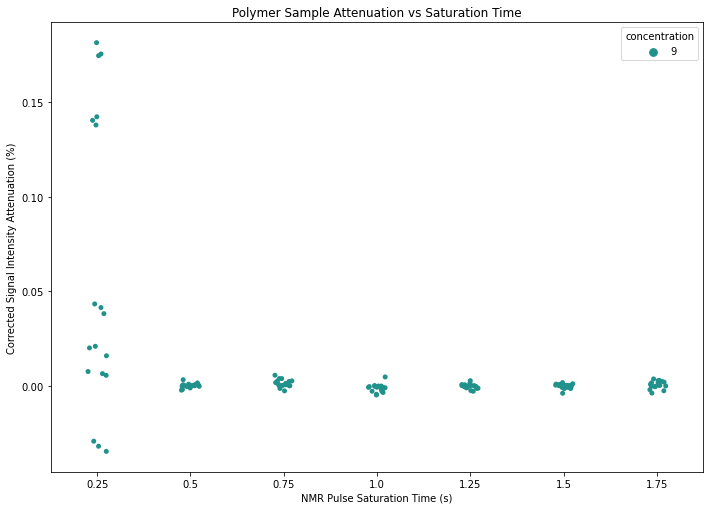

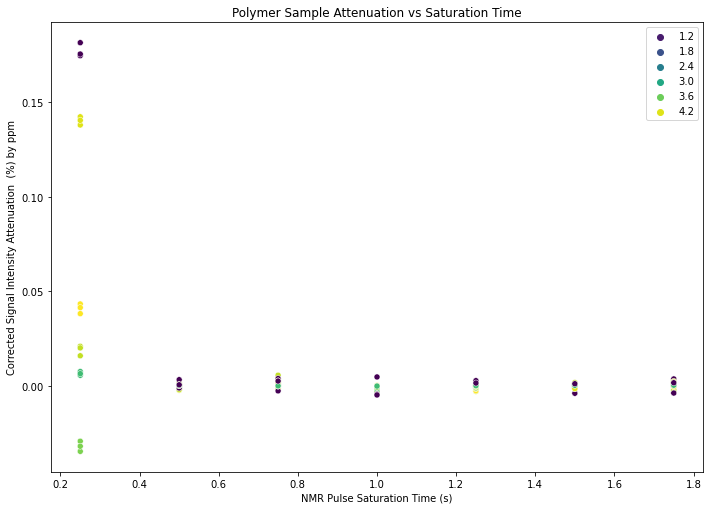

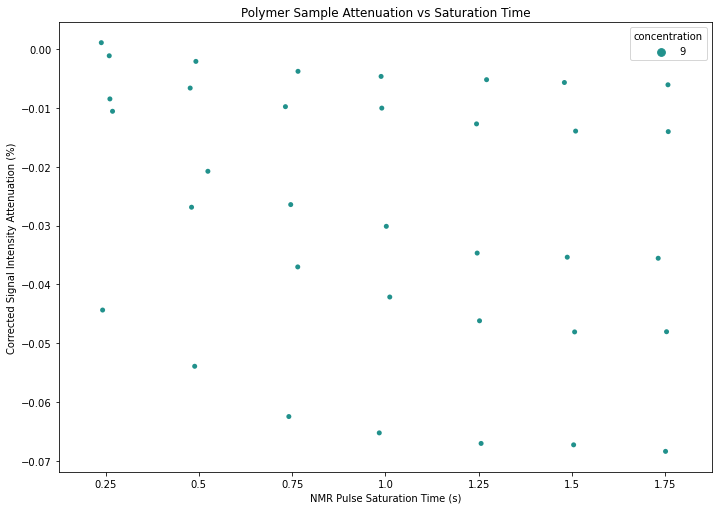

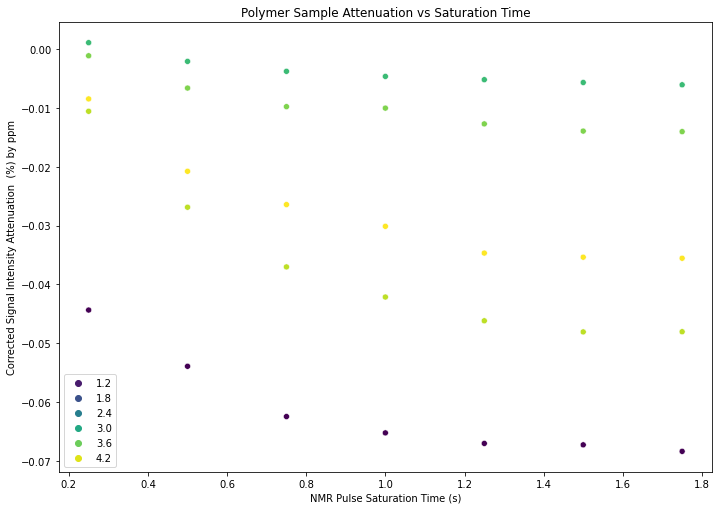

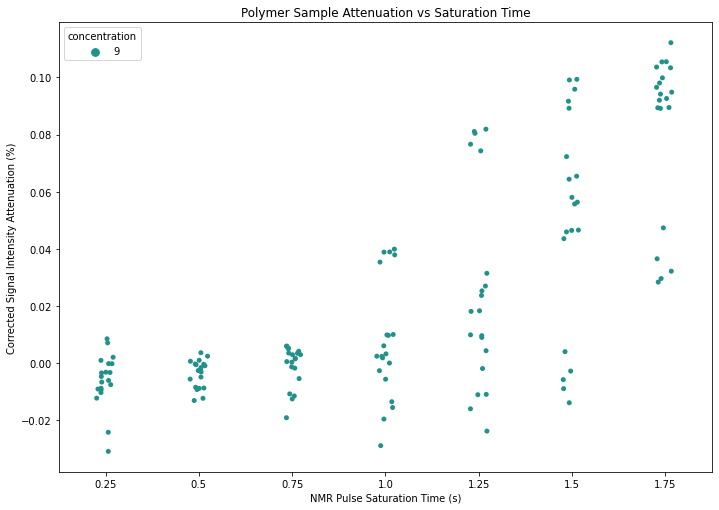

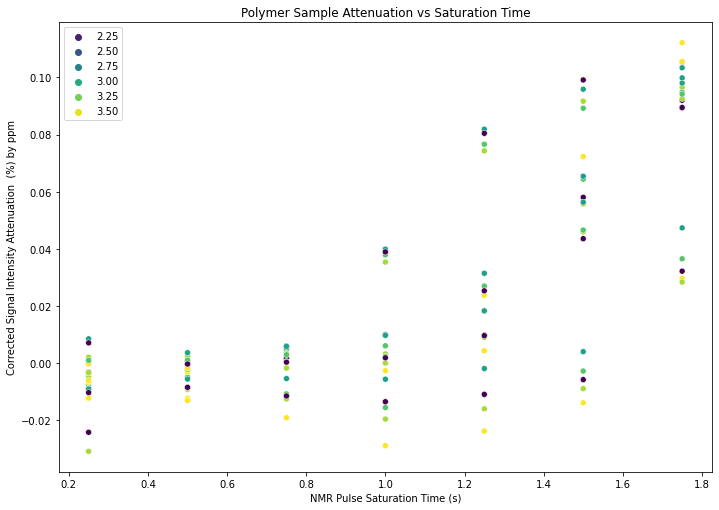

In [356]:
# LOOP THROUGH AND PROCESS EVERY CLEAN DATAFRAME IN THE BATCH LIST GENERATED ABOVE, IF ANY ----------------------------------

if len(clean_batch_tuple_list) != 0: 
    for i in range(len(clean_batch_tuple_list)):

        # BEGINNING PART 1 -------- Reading in Data and Visualizing the Results ------------------------ 

        #define current dataframe to be analyzed and its title from the tuple output of the data cleaning code
        current_df = clean_batch_tuple_list[i][1]
        current_df_title = clean_batch_tuple_list[i][0]

        print("Beginning data analysis for {}...".format(current_df_title))

        # DEFINE GLOBAL CUSTOM OUTPUT DIRECTORIES FOR THIS DATAFRAME ------------------------------------------

        # Define a global custom output directory for the current df in the list
        output_directory = "output_from_{}".format(current_df_title)

        # make global directory if there isn't already one for overall output for current df
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)

        # Define a global output exploratory directory for the exploratory plots 
        output_directory_exploratory = "{}/exploratory_plots_from_{}".format(output_directory, current_df_title)

        # make directory if there isn't already one for exploratory output 
        if not os.path.exists(output_directory_exploratory):
            os.makedirs(output_directory_exploratory)

        # Define a global output directory for the curve fit plots for the current df title
        output_directory2 = "{}/curve_fit_plots_from_{}".format(output_directory, current_df_title)

        # make this directory if there isn't already one for the curve_fit_plots
        if not os.path.exists(output_directory2):
            os.makedirs(output_directory2)  

        # Define a global output directory for the final data tables after curve fitting and stats
        output_directory3 = "{}/data_tables_from_{}".format(output_directory, current_df_title)

        # make this directory if there isn't already one for the data tables
        if not os.path.exists(output_directory3):
            os.makedirs(output_directory3)    

        # CALCULATE ATTENUATION & CORR ATTENUATION -----------------------------------

        current_df_attenuation = add_attenuation_and_corr_attenuation_to_dataframe(current_df, 'batch')

        # PERFORM EXPLORATORY DATA VISUALIZATION -----------------------------------

        print("Visualizing data for {} and saving to a custom exploratory plots output folder...".format(current_df_title))
        generate_concentration_plot(current_df_attenuation)
        generate_ppm_plot(current_df_attenuation)

        # This completes Part 1 - Data Preprocessing and Visualizing the Results!

        # BEGINNING PART 2 -------- Modelling the Data ---------------------------------------

        # STEP 1 OF 5 - Prepare and generate mean dataframe of current data for stats with degrees of freedom and sample size included -----
        current_df_mean = prep_mean_data_for_stats(current_df_attenuation, 'batch')
        current_df_replicates = prep_replicate_data_for_stats(current_df_attenuation, 'batch')

        # STEP 2 OF 5 - Perform t test for statistical significance -------------------------
        current_df_mean = get_t_test_results(current_df_mean, p=0.90)

        # STEP 3 OF 5 - Compute amplification factor -----------------------------------------
        # note: if AF denominators are different for each polymer, should make a list of all values for all polymers, then pass list[i] to af_denominator here
        current_df_mean, current_df_replicates = compute_amplification_factor(current_df_mean, current_df_replicates, af_denominator = 10)

        # STEP 4 OF 5 - Drop proton peaks from further analysis that fail our acceptance criteria -----------------------------------------
        current_df_mean, current_df_replicates = drop_bad_peaks(current_df_mean, current_df_replicates, batch_or_book = 'batch')

        # STEP 5 OF 5 - Perform curve fitting, generate plots, and export results to file  -----------------------------------------
        current_df_mean, current_df_replicates = execute_curvefit(current_df_mean, current_df_replicates, batch_or_book = 'batch')
        print("All activities are now completed for: {}".format(current_df_title))

    print("Hooray! All polymers in the input files have been processed.")



In [362]:
# The below code below can be uncommented for easily "sanity checking" the data. -----------

# It's easier to use this code than the Excel files for quick checks and graph matching imo!
# Add a new cell and create a variable with the dataframe you wish to sanity check
# To use, edit the values in the idx statement[conc, sat_time, proton_peak_index], and the col labels at the end ['SSE_bar'] (this can be removed if you want to see the whole subset for a graph).

# For Mean DataFrame
# checking = current_df_mean.loc[idx[12.5, :, 2]]['SSE_bar']
# print(checking)

# For Replicate DataFrame
# checking_rep = current_df_replicates.loc[(current_df_replicates['proton_peak_index'] == 2) & (current_df_replicates['concentration'] == 12.5) & (current_df_replicates['replicate'] == 5)]['SSE']
# print(checking_rep)